# Signate開始時のお約束

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'signate.json'", fields="files(id)").execute()
signate_api_key = results.get('files', [])

filename = "/root/.signate/signate.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=signate_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [3]:
!pip install signate

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=3369f3c35a3e6955fdb3d5f8e308e66a7daa2eab013013dc5611bdeb05e44b44
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [4]:
!signate files --competition-id=1523

  fileId  name               title                     size  updated_at
--------  -----------------  ----------------------  ------  -------------------
    3939  train.csv          学習用データ            494008  2024-08-01 12:00:28
    3940  test.csv           評価用データ            488363  2024-08-01 12:00:38
    3944  sample_submit.csv  応募用サンプルファイル   86893  2024-08-01 12:00:49
    4057  tutorial.ipynb     チュートリアルコード    323126  2024-08-01 12:01:00


In [5]:
!signate download --competition-id=1523

sample_submit.csv

tutorial.ipynb

test.csv

train.csv


Download completed.


In [6]:
!pip install kanjize

In [7]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 18.4 MB/s eta 0:00:00


In [115]:
!pip install shap

In [8]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# データフレーム読み込み
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")

In [239]:
# データ結合(番号を振り直す)
all_df = pd.concat([train_df,test_df],axis=0,ignore_index=True)
max_row = len(all_df)

In [240]:
###############
# "Age"の処理 #
###############
import unicodedata # 全角を半角に変換
from kanjize import kanji2number # 漢字を数値に変換
import re

# 漢字の判定用
p = re.compile('[一二三四五六七八九十]+')

# nanを-1歳で補完
all_df["Age"] = all_df["Age"].fillna("-1歳")

# Ageの処理
for i in range(max_row):

  # 末尾文字の取得
  tail = all_df.loc[i,"Age"][-1:]

  # 先頭文字が漢字の場合
  if(p.search(all_df.loc[i,"Age"][0])!=None):
    tmp = all_df.loc[i,"Age"][:-1]
    all_df.loc[i,"Age"] = kanji2number(tmp)
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

  # 末尾文字が歳、才、際の場合
  elif((tail=="歳")or(tail=="才")or(tail=="際")):
    all_df.loc[i,"Age"] = all_df.loc[i,"Age"][:-1]
    # 全角を半角に直す
    all_df.loc[i,"Age"] = unicodedata.normalize("NFKC", all_df.loc[i,"Age"])
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

  # 代の場合
  elif(tail == "代"):
    tmp = all_df.loc[i,"Age"][:-1]
    # 数値変換し5足す
    tmp = int(tmp)
    all_df.loc[i,"Age"] = tmp + 5
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

# 「-1」はそれ以外の中央値を代入
all_df["Age"] = all_df["Age"].replace(-1,all_df.loc[all_df["Age"]>0,"Age"].median())

# int型にキャストする
all_df["Age"] = all_df["Age"].astype(int)

<ipython-input-240-766871c38253>:42: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_df["Age"] = all_df["Age"].replace(-1,all_df.loc[all_df["Age"]>0,"Age"].median())


<Axes: >

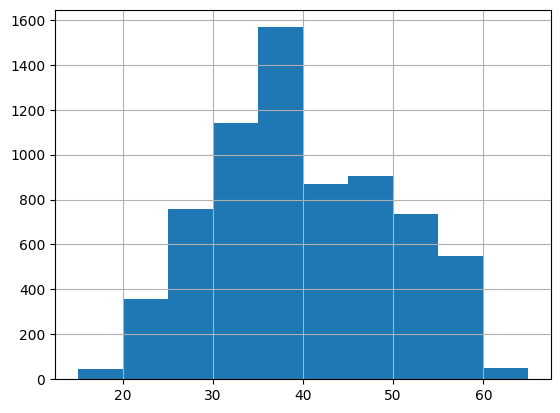

In [241]:
all_df["Age"].hist()

In [242]:
#########################
# "TypeofContact"の処理 #
#########################
# 欠損を埋める
all_df["TypeofContact"] = all_df["TypeofContact"].fillna("Self Enquiry")

In [243]:
# 分類の確認
all_df["TypeofContact"].value_counts()

,count
TypeofContact,
Self Enquiry,4462
Company Invited,2516


In [244]:
#########################
# "CityTier"の処理 #
#########################
# 分類の確認
all_df["CityTier"].value_counts()
# all_df["CityTier"].isnull().sum()

,count
CityTier,
2,3160
1,2991
3,827


In [245]:
#########################
# "DurationOfPitch"の処理 #
#########################
# nanを-1分で補完
all_df["DurationOfPitch"] = all_df["DurationOfPitch"].fillna("-1分")

# 秒を分に変換 #
for i in range(max_row):

  tail = str(all_df.loc[i,"DurationOfPitch"])[-1:]

  if(tail == "秒"):
    tmp = all_df.loc[i,"DurationOfPitch"][:-1]
    all_df.loc[i,"DurationOfPitch"] = float(tmp) / 60.0
  elif(tail == "分"):
    all_df.loc[i,"DurationOfPitch"] = all_df.loc[i,"DurationOfPitch"][:-1]

all_df["DurationOfPitch"] = all_df["DurationOfPitch"].astype("float64")

# 「-1」はそれ以外の中央値を代入
all_df["DurationOfPitch"] = all_df["DurationOfPitch"].replace(-1,all_df.loc[all_df["DurationOfPitch"]>0,"DurationOfPitch"].median())

<Axes: >

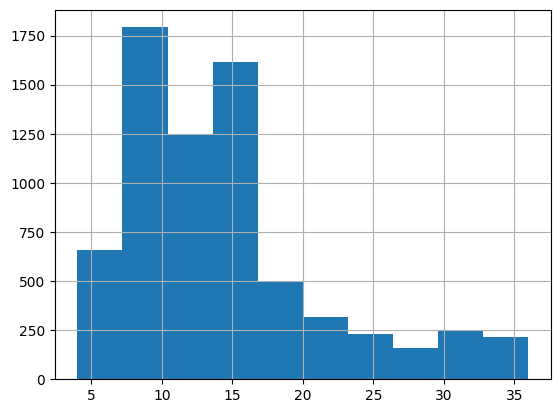

In [246]:
# 分布の確認
all_df["DurationOfPitch"].hist()

In [247]:
####################
# "Occupation"の処理 #
####################
# 個人事業主/会社員/大企業の3択のためホットエンコードにする
all_df["Occupation"].value_counts()
# all_df["Occupation"].isnull().sum()

,count
Occupation,
Small Business,3456
Salaried,2801
Large Business,721


In [248]:
##################
# "Genger"の処理 #
##################
# all_df["Gender"].isnull().sum()
# 先頭文字がMかmならMaleになる
for i in range(max_row):

  # 先頭文字の取得(半角)
  head = unicodedata.normalize("NFKC", all_df.loc[i,"Gender"][:1])

  if(head == "m"):
    all_df.loc[i,"Gender"] = "Male"

  else:
    all_df.loc[i,"Gender"] = "Female"

In [249]:
# 分類の確認
all_df["Gender"].value_counts()

,count
Gender,
Female,5946
Male,1032


In [250]:
##################################
# "NumberOfPersonVisiting"の処理 #
##################################
all_df["NumberOfPersonVisiting"].value_counts()
# all_df["NumberOfPersonVisiting"].isnull().sum()

,count
NumberOfPersonVisiting,
2.0,3163
3.0,2773
1.0,686
4.0,356


In [251]:
##################################
# "NumberOfFollowups"の処理 #
##################################
# all_df["NumberOfFollowups"].value_counts()
# all_df["NumberOfFollowups"].isnull().sum()
all_df["NumberOfFollowups"] = all_df["NumberOfFollowups"].fillna(-1)
all_df["NumberOfFollowups"] = all_df["NumberOfFollowups"].replace(-1,all_df.loc[all_df["NumberOfFollowups"]>0,"NumberOfFollowups"].median())

In [252]:
# 100回以上は記録違いとして100で割る
all_df.loc[all_df["NumberOfFollowups"]>=100,"NumberOfFollowups"] = all_df.loc[all_df["NumberOfFollowups"]>=100,"NumberOfFollowups"] / 100

In [253]:
# 分布の確認
all_df["NumberOfFollowups"].value_counts()

,count
NumberOfFollowups,
4.0,2834
3.0,2561
5.0,1122
2.0,213
1.0,178
6.0,70


In [254]:
##########################
# "ProductPitched"の処理 #
##########################
# ind_name = all_df["ProductPitched"].value_counts().index.values
# all_df["ProductPitched"].isnull().sum()

In [255]:
# ギリシャ文字をアルファベットに変換
greek_string = "αβγδεζηθικλμνξοπρστυφχψωвꓢѕꭰտᗞı𐊡"
alphabet_string = "abgdezhqiklmnxoprstufcywbssdsdib"

def greek_to_alphabet(text):
    result = ""
    for char in text:
        if char in greek_string:
            result += alphabet_string[greek_string.index(char)]
        else:
            result += char  # ギリシャ文字以外の文字はそのまま
    return result

In [256]:
# Basic, Standard, Deluxe, Super Deluxe, kingに分ける
prefix = 0
others = []
# すべて小文字に変換し判定
for i in range(len(all_df)):
  prefix = unicodedata.normalize("NFKC", greek_to_alphabet(all_df.loc[i,"ProductPitched"][:2].lower())).lower()

  if(prefix == "ba"):
    all_df.loc[i,"ProductPitched"] = "Basic"

  elif(prefix == "st"):
    all_df.loc[i,"ProductPitched"] = "Standard"

  elif(prefix == "de"):
    all_df.loc[i,"ProductPitched"] = "Deluxe"

  elif(prefix == "su"):
    all_df.loc[i,"ProductPitched"] = "SuperDeluxe"

  elif(prefix == "ki"):
    all_df.loc[i,"ProductPitched"] = "King"

  else:
    others.append(i)

In [257]:
# 分布の確認
all_df["ProductPitched"].value_counts()

,count
ProductPitched,
Basic,2347
Deluxe,2091
Standard,1614
SuperDeluxe,640
King,286


In [258]:
#################################
# "PreferredPropertyStar"の処理 #
#################################
# all_df["PreferredPropertyStar"].isnull().sum()

# 2引いて揃える
# all_df["PreferredPropertyStar"] = all_df["PreferredPropertyStar"] - 2

all_df["PreferredPropertyStar"].value_counts()

,count
PreferredPropertyStar,
3.0,4328
4.0,2254
5.0,396


In [259]:
#########################
# "NumberOfTrips"の処理 #
#########################
# nanは-1で補完
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].fillna("-1")

# 一旦オブジェクト型に変更
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].astype("object")

for i in range(max_row):

  # 先頭文字の取得(半角)
  head = all_df.loc[i,"NumberOfTrips"][:1]

  if(head == "年"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][2:3]

  elif(head == "半"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][3:4]

  elif(head == "四"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][4:5]

# int型に変更
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].astype("int")

# 「-1」はそれ以外の中央値を代入
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].replace(-1,all_df.loc[all_df["NumberOfTrips"]>0,"NumberOfTrips"].median())

<Axes: >

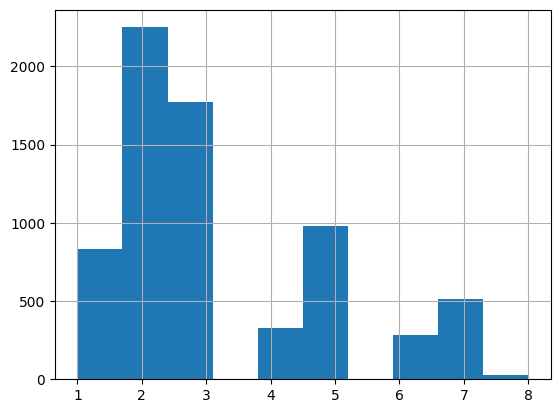

In [260]:
# ヒストグラムの確認
all_df["NumberOfTrips"].hist()

In [261]:
#########################
# "Passport"の処理 #
#########################
# all_df["Passport"].isnull().sum()
all_df["Passport"].value_counts()

,count
Passport,
0,6288
1,690


<Axes: >

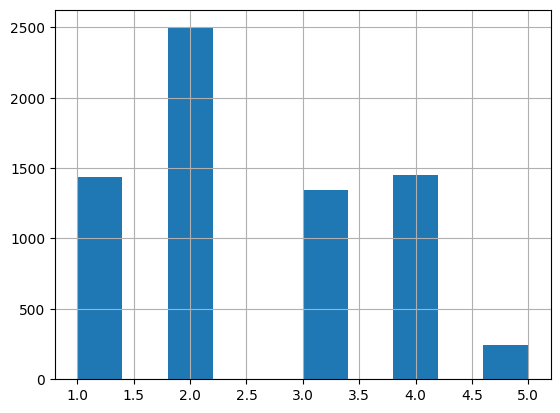

In [262]:
##################################
# "PitchSatisfactionScore"の処理 #
##################################
# all_df["PitchSatisfactionScore"].isnull().sum()
# all_df["PitchSatisfactionScore"].value_counts()
all_df["PitchSatisfactionScore"].hist()

In [263]:
#########################
# "Designation"の処理 #
#########################
# all_df["Designation"].isnull().sum()
# all_df["Designation"].value_counts()

In [264]:
# ギリシャ文字をアルファベットに変換
greek_string = "αβγδεζηθικλμνξοπρστυφχψωвꓢѕꭰտᗞı𐊡Аае"
alphabet_string = "abgdezhqiklmnxoprstufcywbssdsdibaae"

def greek_to_alphabet(text):
    result = ""
    for char in text:
        if char in greek_string:
            result += alphabet_string[greek_string.index(char)]
        else:
            result += char  # ギリシャ文字以外の文字はそのまま
    return result

In [265]:
# 文字を変換する
prefix = 0
for i in range(len(all_df)):
  prefix = unicodedata.normalize("NFKC", greek_to_alphabet(all_df.loc[i,"Designation"][:1].lower())).lower()

  # Executive: 取締役、執行役員
  if(prefix == "e"):
    all_df.loc[i,"Designation"] = "Executive"

  # Vice President: 本部長
  elif(prefix == "v"):
    all_df.loc[i,"Designation"] = "VP"

  # Associate Vice President: 本部長補佐
  elif(prefix == "a"):
    all_df.loc[i,"Designation"] = "AVP"

  # Senior Manager: 次長
  elif(prefix == "s"):
    all_df.loc[i,"Designation"] = "Senior Manager"

  # Manager: 課長
  elif(prefix == "m"):
    all_df.loc[i,"Designation"] = "Manager"

In [266]:
# 分類の確認
all_df["Designation"].value_counts()

,count
Designation,
Executive,2330
Manager,2117
Senior Manager,1632
AVP,635
VP,264


In [267]:
#########################
# "MonthlyIncome"の処理 #
#########################
import re

# 漢字の判定用
p = re.compile('[月]+')

# nanを-1で補完
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].fillna("-1")

for i in range(max_row):

  # 先頭文字の取得
  head = all_df.loc[i,"MonthlyIncome"][:1]

  # 先頭文字が漢字の場合
  if(p.search(head[0])!=None):
    tmp = all_df.loc[i,"MonthlyIncome"][2:-2]
    all_df.loc[i,"MonthlyIncome"] = float(tmp)*10000

# float型にキャストする
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].astype(float)

# 「-1」はそれ以外の中央値を代入
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].replace(-1,all_df.loc[all_df["MonthlyIncome"]>0,"MonthlyIncome"].median())

<Axes: >

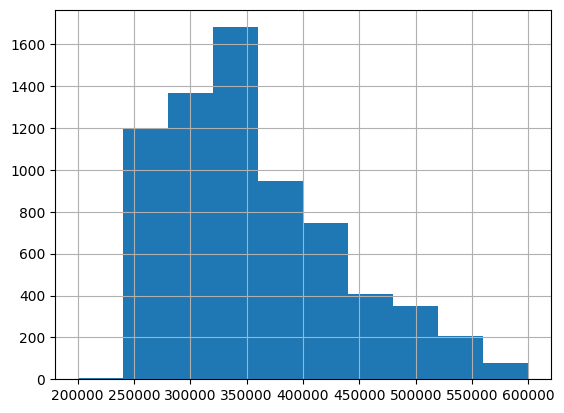

In [268]:
# 分布の確認
all_df["MonthlyIncome"].hist()

In [269]:
#########################
# "customer_info"の処理 #
#########################
import re

# 項目名
cont = []

# 区切り文字で分割する
for i in range(max_row):
  tmp = re.split("[ 　,、\n\t/／\u3000]",all_df.loc[i,"customer_info"])
  tmp = list(filter(None, tmp))
  if(type(tmp)==list):
    for j in range(len(tmp)):
      if(tmp[j] not in cont):
        cont.append(tmp[j])

# キーワード抽出
c_car = [] # 車関係
c_child = [] # 子供関係
c_married = [] # 婚姻関係
c_other = [] # その他

for i in range(len(cont)):
  # 「車あり」、「車所持」、「自家用車あり」、「車保有」、「乗用車所持」、「自動車保有」
  # 「車なし」、「車未所持」、「自家用車なし」、「車保有なし」、「乗用車なし」、「自動車未所有」
  if((cont[i][0:1] == "車") or (cont[i][0:1] == "自") or (cont[i][0:1] == "乗")):
    c_car.append(cont[i])
  # 「こども1人」、「1児」、「子供1人」、「子供有り(1人)」、「子供有り」
  # 「こども2人」、「2児」、「子供2人」、「子供有り(2人)」
  # 「こども3人」、「3児」「子供3人」、「子供有り(3人)」
  # 「子供なし」、「子供無し」、「無子」、「子供ゼロ」、「非児童家庭」
  # 「子育て状況不明」、「子の数不詳」、「子供の数不明」
  elif((cont[i][0:1] == "子") or (cont[i][0:1] == "こ") or (cont[i][-1:] == "児") or (cont[i][-1:] == "子") or (cont[i][-1:] == "庭")):
    c_child.append(cont[i])
  # 「結婚済み」、「離婚済み」、「未婚」、「独身」
  elif((cont[i][0:1] == "結") or (cont[i][0:1] == "離") or (cont[i][0:1] == "独") or (cont[i][0:1] == "離") or (cont[i][0:1] == "未")):
    c_married.append(cont[i])
  # 「1人」、「2人」、「3人」、「不明」、「わからない」
  else:
    c_other.append(cont[i])

In [270]:
# 新たなカラムを追加
all_df["CarHolder"] = 0 # 車所有
all_df["NumofChild"] = 0 # 子供の数
all_df["Married"] = "Single" # 婚姻歴

# 車
c_car_hold = ["車あり","車所持","自家用車あり","車保有","乗用車所持","自動車保有"]

# 子供
c_child_1 = ["こども1人","1児""子供1人","子供有り(1人)","子供有り"]
c_child_2 = ["こども2人","2児""子供2人","子供有り(2人)"]
c_child_3 = ["こども3人","3児""子供3人","子供有り(3人)"]

# 婚姻状況
c_pair = ["結婚済み"]
c_batu = ["離婚済み"]

# 区切り文字で分割する
for i in range(max_row):
  tmp = re.split("[ 　,、\n\t/／\u3000]",all_df.loc[i,"customer_info"])
  tmp = list(filter(None, tmp))
  if(type(tmp)==list):
    for j in range(len(tmp)):
      # 車の情報
      if(tmp[j] in c_car_hold):
        all_df.loc[i, "CarHolder"] = 1
      # 子供の情報
      if(tmp[j] in c_child_1):
        all_df.loc[i, "NumofChild"] = 1
      if(tmp[j] in c_child_2):
        all_df.loc[i, "NumofChild"] = 2
      if(tmp[j] in c_child_3):
        all_df.loc[i, "NumofChild"] = 3
      # 婚姻歴
      if(tmp[j] in c_pair):
        all_df.loc[i, "Married"] = "Married"
      if(tmp[j] in c_batu):
        all_df.loc[i, "Married"] = "Divorce"

# 使用済みカラム抹消
all_df = all_df.drop("customer_info", axis=1)

In [271]:
# 車保有率
all_df["CarHolder"].value_counts()

,count
CarHolder,
0,4408
1,2570


In [272]:
# 子供の数
all_df["NumofChild"].value_counts()

,count
NumofChild,
0,5015
1,1347
2,571
3,45


In [273]:
# 婚姻歴
all_df["Married"].value_counts()

,count
Married,
Married,2846
Single,2444
Divorce,1688


# 特徴量エンジニアリング

In [274]:
# 「Dsignation」をラベルエンコード
all_df["Designation_LE"] = 1
all_df.loc[all_df["Designation"]=="Executive","Designation_LE"] = 5
all_df.loc[all_df["Designation"]=="VP","Designation_LE"] = 4
all_df.loc[all_df["Designation"]=="AVP","Designation_LE"] = 3
all_df.loc[all_df["Designation"]=="Senior Manager","Designation_LE"] = 2
all_df.loc[all_df["Designation"]=="Manager","Designation_LE"] = 1

# 「Occupation」をラベルエンコード
all_df["Occupation_LE"] = 1
all_df.loc[all_df["Occupation"]=="Large Business","Occupation_LE"] = 3
all_df.loc[all_df["Occupation"]=="Small Business","Occupation_LE"] = 2
all_df.loc[all_df["Occupation"]=="Salaried","Occupation_LE"] = 1

# 「CarHolder」をラベルエンコード
all_df["CarHolder_LE"] = all_df["CarHolder"] + 1

# 「Gender」をラベルエンコード
all_df["Gender_LE"] = 1
all_df.loc[all_df["Gender"]=="Female","Gender_LE"]=2
all_df.loc[all_df["Gender"]=="Male","Gender_LE"]=2

# 「ProductPitched」をラベルエンコード
all_df["ProductPitched_LE"] = 1
all_df.loc[all_df["ProductPitched"]=="King","ProductPitched_LE"]=5
all_df.loc[all_df["ProductPitched"]=="SuperDeluxe","ProductPitched_LE"]=4
all_df.loc[all_df["ProductPitched"]=="Deluxe","ProductPitched_LE"]=3
all_df.loc[all_df["ProductPitched"]=="Standard","ProductPitched_LE"]=2
all_df.loc[all_df["ProductPitched"]=="Basic","ProductPitched_LE"]=1

# 「Married」をラベルエンコード
all_df["Married_LE"] = 1
all_df.loc[all_df["Married"]=="Married","Married_LE"]=3
all_df.loc[all_df["Married"]=="Divorce","Married_LE"]=2
all_df.loc[all_df["Married"]=="Single","Married_LE"]=1

# 「TypeofContact」をラベルエンコード
all_df["TypeofContact_LE"] = 1
all_df.loc[all_df["TypeofContact"]=="Company Invited","TypeofContact_LE"]=2
all_df.loc[all_df["TypeofContact"]=="Self Enquiry","TypeofContact_LE"]=1

In [275]:
# エンコード前のラベルを抹消する
all_df = all_df.drop("Designation", axis=1)
all_df = all_df.drop("Occupation", axis=1)
all_df = all_df.drop("Gender", axis=1)
all_df = all_df.drop("ProductPitched", axis=1)
all_df = all_df.drop("Married", axis=1)
all_df = all_df.drop("CarHolder", axis=1)
all_df = all_df.drop("TypeofContact", axis=1)

In [86]:
# 分布に偏りが見られそうなため、一つずつ確認していく

In [87]:
train = all_df.loc[0:len(train_df)-1]

<Axes: >

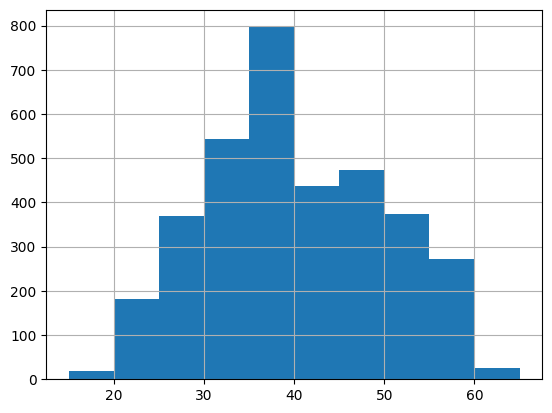

In [88]:
train["Age"].hist()

In [89]:
print(train.loc[train["Age"]<20,"ProdTaken"].mean())
print(train.loc[(train["Age"]>=20) & (train["Age"]<30),"ProdTaken"].mean())
print(train.loc[(train["Age"]>=30) & (train["Age"]<40),"ProdTaken"].mean())
print(train.loc[(train["Age"]>=40) & (train["Age"]<50),"ProdTaken"].mean())
print(train.loc[train["Age"]>=50,"ProdTaken"].mean())

0.5
0.30127041742286753
0.13965646004480955
0.08232711306256861
0.08955223880597014


In [222]:
train.loc[train["Age"]>60,"Age"]

,Age
178,65
591,65
1154,61
1215,61
2335,61
2498,61
2529,65
2646,65
3276,61


<Axes: >

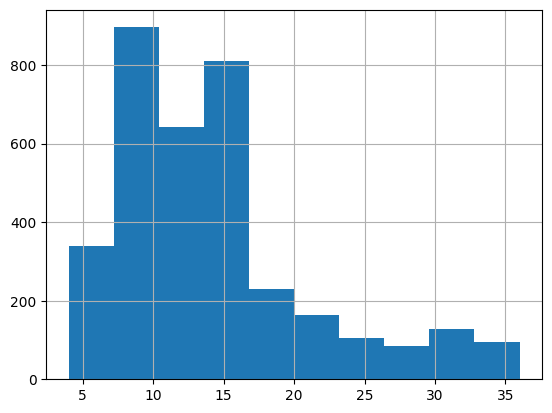

In [90]:
# DurationOfPitch [分]
train["DurationOfPitch"].hist()

In [91]:
# かけた時間と成功率に差はあるのか？
# 20分以上、10分以上、その他
# 対数変換する？
print(train.loc[train["DurationOfPitch"]>=15,"ProdTaken"].mean())
# print(train.loc[(train["DurationOfPitch"]>=10) & (train["DurationOfPitch"]<20),"ProdTaken"].mean())
# print(train.loc[train["DurationOfPitch"]<10,"ProdTaken"].mean())

0.14933135215453194


<Axes: >

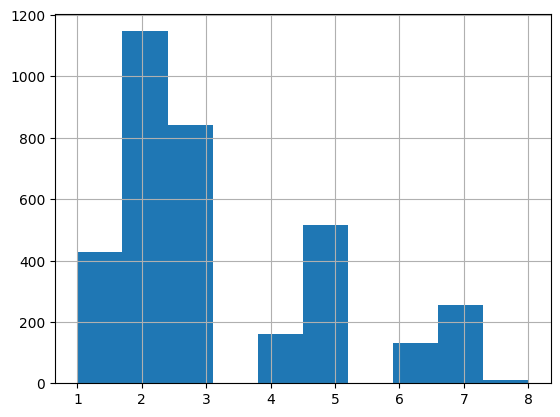

In [92]:
# NumberOfTrips
train["NumberOfTrips"].hist()

In [93]:
# 初回か6回以上の成功率が高い
print(train.loc[train["NumberOfTrips"]>=5,"ProdTaken"].mean())

# print(train.loc[train["NumberOfTrips"]>=6,"ProdTaken"].mean())
# print(train.loc[(train["NumberOfTrips"]>=3) & (train["NumberOfTrips"]<6),"ProdTaken"].mean())
# print(train.loc[train["NumberOfTrips"]<3,"ProdTaken"].mean())

0.13830954994511527


<Axes: >

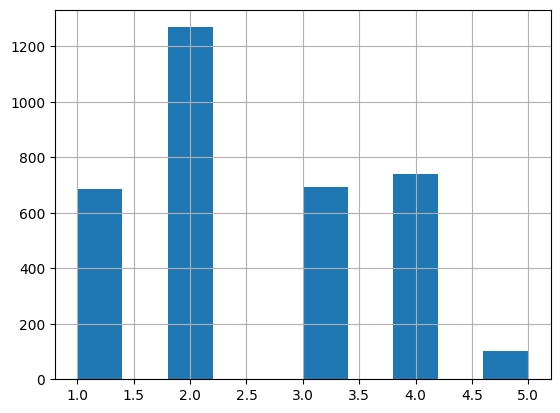

In [94]:
train["PitchSatisfactionScore"].hist()

In [95]:
# 2〜3が高い
print(train.loc[train["PitchSatisfactionScore"]==1,"ProdTaken"].mean())
print(train.loc[train["PitchSatisfactionScore"]==2,"ProdTaken"].mean())
print(train.loc[train["PitchSatisfactionScore"]==3,"ProdTaken"].mean())
print(train.loc[train["PitchSatisfactionScore"]==4,"ProdTaken"].mean())
print(train.loc[train["PitchSatisfactionScore"]==5,"ProdTaken"].mean())
# print(train.loc[(train["PitchSatisfactionScore"]<=3)&(train["PitchSatisfactionScore"]<2),"ProdTaken"].mean())

0.08017492711370262
0.17494089834515367
0.1416184971098266
0.15155615696887687
0.0970873786407767


<Axes: >

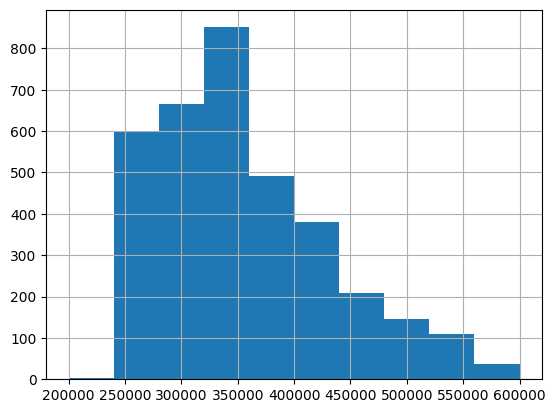

In [96]:
train["MonthlyIncome"].hist()

In [97]:
# Log取るか、月収低すぎを異常値とするか
print(train.loc[train["MonthlyIncome"]<250000,"ProdTaken"].mean())
print(train.loc[(train["MonthlyIncome"]>=250000)&(train["MonthlyIncome"]<300000),"ProdTaken"].mean())
print(train.loc[(train["MonthlyIncome"]>=300000)&(train["MonthlyIncome"]<350000),"ProdTaken"].mean())
print(train.loc[(train["MonthlyIncome"]>=350000)&(train["MonthlyIncome"]<400000),"ProdTaken"].mean())
print(train.loc[(train["MonthlyIncome"]>=400000)&(train["MonthlyIncome"]<450000),"ProdTaken"].mean())
print(train.loc[(train["MonthlyIncome"]>=450000)&(train["MonthlyIncome"]<500000),"ProdTaken"].mean())
print(train.loc[train["MonthlyIncome"]>=500000,"ProdTaken"].mean())

0.4444444444444444
0.3378995433789954
0.11547911547911548
0.06960227272727272
0.08256880733944955
0.06698564593301436
0.09787234042553192


<Axes: >

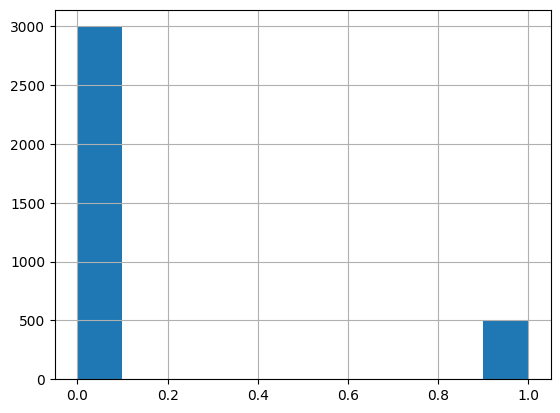

In [98]:
all_df["ProdTaken"].hist()

In [185]:
# 月収はLogを取る
# all_df["MonthlyIncomeLOG"] = np.log1p(all_df["MonthlyIncome"])

In [186]:
# 年齢はLogを取る
# all_df["AgeLOG"] = np.log1p(all_df["Age"])

In [276]:
# 検討の結果、重要度が低いものを抹消する(gain=0)
all_df = all_df.drop("Gender_LE", axis=1)

In [277]:
# 抹消対象だがまずは置いて
# all_df = all_df.drop("Age", axis=1)
# all_df = all_df.drop("MonthlyIncome", axis=1)

In [278]:
# 取り除く変数
RMV = ["id","ProdTaken"]
RMV2 = ["id"]

FEATURES = [c for c in all_df.columns if c not in RMV2]
TARGET = "ProdTaken"

In [279]:
CATS = []
for c in FEATURES:
  if all_df[c].dtype == "object":
    CATS.append(c)

In [280]:
# カラムを制限
all_df2 = all_df[FEATURES]

In [281]:
# 結合を戻す
train = all_df2.iloc[:len(train_df)].copy()
test = all_df2.iloc[len(train_df):].reset_index(drop=True).copy()

In [282]:
# 対象の列のみ取り込み
test = test.drop(TARGET,axis=1)

In [283]:
FEATURES = test.columns

In [284]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
from sklearn.metrics import mean_squared_error

lgbm_params = {
    'objective': 'binary',
    "device": "cpu",
    # 'metric': 'rmse',
    'metric': 'auc',
    'verbose': -1,              # ログ出力の制御
    'boosting_type': 'gbdt',
    'feature_fraction': 0.7177861300160412,
    'num_leaves': 100,
    'bagging_fraction': 0.42936413368667514,
    'bagging_freq': 7,
    'lambda_l1': 8.134448301407863,
    'lambda_l2': 9.742577954650878,
    'min_data_in_leaf': 96,
    'learning_rate': 0.02551719491742634,
    # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
    # 'max_depth': trial.suggest_int('max_depth', 3, 12),
    }

In [285]:
%%time
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold

FOLDS = 3 # 分割数
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=74)
# kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(train))
pred_lgb = np.zeros(len(test))
models = []
evaluations_result = {}

for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):
# for i, (train_index, test_index) in enumerate(kf.split(train)):

  print("#"*25)
  print(f"### Fold {i+1}")
  print("#"*25)

  # インデックスに割り振る

  x_train = train.loc[train_index, FEATURES].copy()
  y_train = train.loc[train_index, TARGET]
  x_valid = train.loc[test_index, FEATURES].copy()
  y_valid = train.loc[test_index, TARGET]
  # x_test = test[FEATURES].copy()

  # データセット作成
  lgb_train = lgb.Dataset(x_train, y_train)
  lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

  # 学習
  model_lgb = lgb.train(lgbm_params,
                        lgb_train,
                        num_boost_round = 2000,
                        valid_sets = [lgb_train, lgb_eval],
                        valid_names = ["train", "valid"],
                        callbacks = [
                            lgb.early_stopping(stopping_rounds=100, verbose=False),
                            lgb.record_evaluation(evaluations_result),
                            lgb.log_evaluation(100),])

  oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
  models.append(model_lgb)

from sklearn.metrics import roc_auc_score # AUC評価指標
# AUCの評価(第一引数にy_trueを入れる)
score = roc_auc_score(train[TARGET],oof_lgb)
print(score)

#########################
### Fold 1
#########################
[100]	train's auc: 0.820311	valid's auc: 0.820075
[200]	train's auc: 0.833299	valid's auc: 0.824334
[300]	train's auc: 0.842363	valid's auc: 0.828999
[400]	train's auc: 0.844721	valid's auc: 0.831615
[500]	train's auc: 0.847775	valid's auc: 0.833482
[600]	train's auc: 0.850596	valid's auc: 0.834721
[700]	train's auc: 0.852009	valid's auc: 0.835507
[800]	train's auc: 0.853398	valid's auc: 0.835573
[900]	train's auc: 0.854196	valid's auc: 0.835658
[1000]	train's auc: 0.855167	valid's auc: 0.836413
[1100]	train's auc: 0.855956	valid's auc: 0.836932
#########################
### Fold 2
#########################
[100]	train's auc: 0.833834	valid's auc: 0.818751
[200]	train's auc: 0.842451	valid's auc: 0.823845
[300]	train's auc: 0.848202	valid's auc: 0.82506
#########################
### Fold 3
#########################
[100]	train's auc: 0.823131	valid's auc: 0.810002
[200]	train's auc: 0.837005	valid's auc: 0.823316
[300]	trai

In [286]:
from sklearn.metrics import roc_auc_score # AUC評価指標
# AUCの評価(第一引数にy_trueを入れる)
score = roc_auc_score(train[TARGET],oof_lgb)
print(score)

0.8311002377903787


<Axes: >

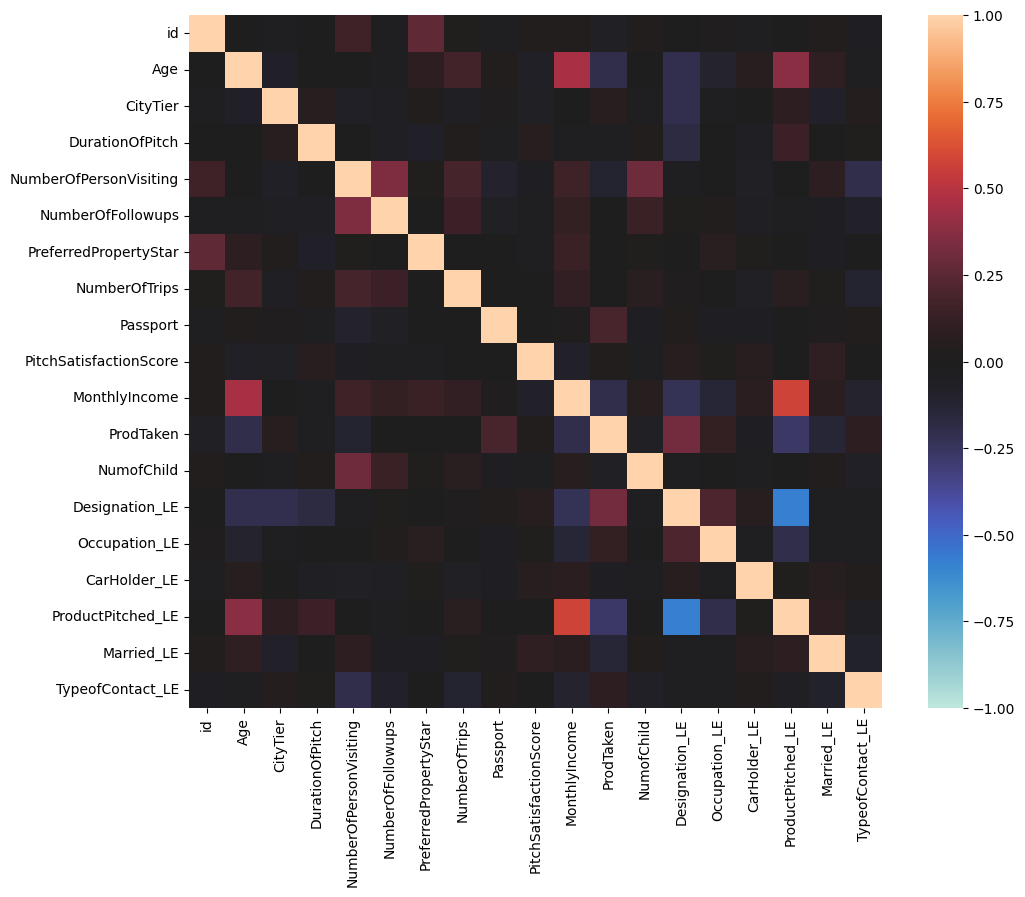

In [287]:
all_df_corr = all_df.corr()
fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(all_df_corr, square=True, vmax=1, vmin=-1, center=0)

In [ ]:
# スコアが上がる振り分けSeedを探す

In [131]:
%%time
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score # AUC評価指標

# SEEDごとのスコアを出す
def objective(seed):

  oof_lgb = np.zeros(len(train))
  pred_lgb = np.zeros(len(test))
  models = []
  evaluations_result = {}

  FOLDS = 3 # 分割数
  skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=seed)

  for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

  # インデックスに割り振る

    x_train = train.loc[train_index, FEATURES].copy()
    y_train = train.loc[train_index, TARGET]
    x_valid = train.loc[test_index, FEATURES].copy()
    y_valid = train.loc[test_index, TARGET]
    # x_test = test[FEATURES].copy()

    #データセット作成
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

    # 学習
    model_lgb = lgb.train(lgbm_params,
                          lgb_train,
                          num_boost_round = 2000,
                          valid_sets = [lgb_train, lgb_eval],
                          valid_names = ["train", "valid"],
                          callbacks = [
                              lgb.early_stopping(stopping_rounds=100, verbose=False),
                              lgb.record_evaluation(evaluations_result),
                              lgb.log_evaluation(100),])

    oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
    models.append(model_lgb)

  # AUCの評価(第一引数にy_trueを入れる)
  score = roc_auc_score(train[TARGET],oof_lgb)
  return score

CPU times: user 19 µs, sys: 0 ns, total: 19 µs
Wall time: 21 µs


In [133]:
# seedが0〜99まで試す
score_history = []

for i in range(100):
  score_history.append(objective(i))

#########################
### Fold 1
#########################
[100]	train's auc: 0.854946	valid's auc: 0.852521
[200]	train's auc: 0.869279	valid's auc: 0.849531
#########################
### Fold 2
#########################
[100]	train's auc: 0.862999	valid's auc: 0.814455
[200]	train's auc: 0.876528	valid's auc: 0.81825
[300]	train's auc: 0.887017	valid's auc: 0.81944
[400]	train's auc: 0.895676	valid's auc: 0.819839
[500]	train's auc: 0.899424	valid's auc: 0.82048
[600]	train's auc: 0.904539	valid's auc: 0.8206
#########################
### Fold 3
#########################
[100]	train's auc: 0.865547	valid's auc: 0.815364
#########################
### Fold 1
#########################
[100]	train's auc: 0.860219	valid's auc: 0.834352
[200]	train's auc: 0.873183	valid's auc: 0.837917
[300]	train's auc: 0.883352	valid's auc: 0.837603
[400]	train's auc: 0.890395	valid's auc: 0.837742
#########################
### Fold 2
#########################
[100]	train's auc: 0.85736	valid's auc: 

In [141]:
max_val = max(score_history)
max_index = score_history.index(max_val)
print(max_index)
print(max_val)

74
0.834673818310935


In [139]:
score_history[0]

np.float64(0.8270680231119336)

In [134]:
max(score_history)

np.float64(0.834673818310935)

In [ ]:
# FOLDS = 3 # 分割数
# skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

# skf_trainIND = []
# skf_validIND = []

# for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):
#   skf_trainIND.append(train_index)
#   skf_validIND.append(test_index)

In [ ]:
# # FOLDごとのdfを分ける
# train_FOLD1 = all_df.loc[skf_trainIND[0]]
# train_FOLD2 = all_df.loc[skf_trainIND[2]]
# train_FOLD3 = all_df.loc[skf_trainIND[4]]
# test_FOLD1 = all_df.loc[skf_trainIND[1]]
# test_FOLD2 = all_df.loc[skf_trainIND[3]]
# test_FOLD3 = all_df.loc[skf_trainIND[5]]

In [ ]:
# print(skf_trainIND[0])
# print(skf_validIND[0])
# print(skf_trainIND[1])
# print(skf_validIND[1])
# print(skf_trainIND[2])
# print(skf_validIND[2])

[   0    3    4 ... 3485 3486 3488]
[   1    2   16 ... 3478 3480 3487]
[   0    1    2 ... 3485 3487 3488]
[   3    4    5 ... 3482 3483 3486]
[   1    2    3 ... 3483 3486 3487]
[   0    6   13 ... 3484 3485 3488]


In [111]:
from sklearn.metrics import roc_auc_score # AUC評価指標
# AUCの評価(第一引数にy_trueを入れる)
score = roc_auc_score(train[TARGET],oof_lgb)
print(score)

0.8312185949924144


In [288]:
# FOLD1
# lgb.plot_importance(models[0], figsize=(8,4), max_num_features=20, importance_type='gain')
importance0 = pd.DataFrame(models[0].feature_importance(importance_type="gain"),index=test.columns,columns=['importance'])
importance1 = pd.DataFrame(models[1].feature_importance(importance_type="gain"),index=test.columns,columns=['importance'])
importance2 = pd.DataFrame(models[2].feature_importance(importance_type="gain"),index=test.columns,columns=['importance'])

In [289]:
feature = (importance0+importance1+importance2)/3

In [290]:
feature.sort_values("importance", ascending=False)

,importance
Designation_LE,1039.650106
ProductPitched_LE,682.045256
MonthlyIncome,571.064903
Passport,375.220178
Age,333.501785
Married_LE,268.707609
CityTier,213.108938
PitchSatisfactionScore,96.277832
NumberOfTrips,94.743118
TypeofContact_LE,75.937087


In [146]:
import shap
shap.initjs()
# 基本スコア
explainer = shap.TreeExplainer(model=models[0])

/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


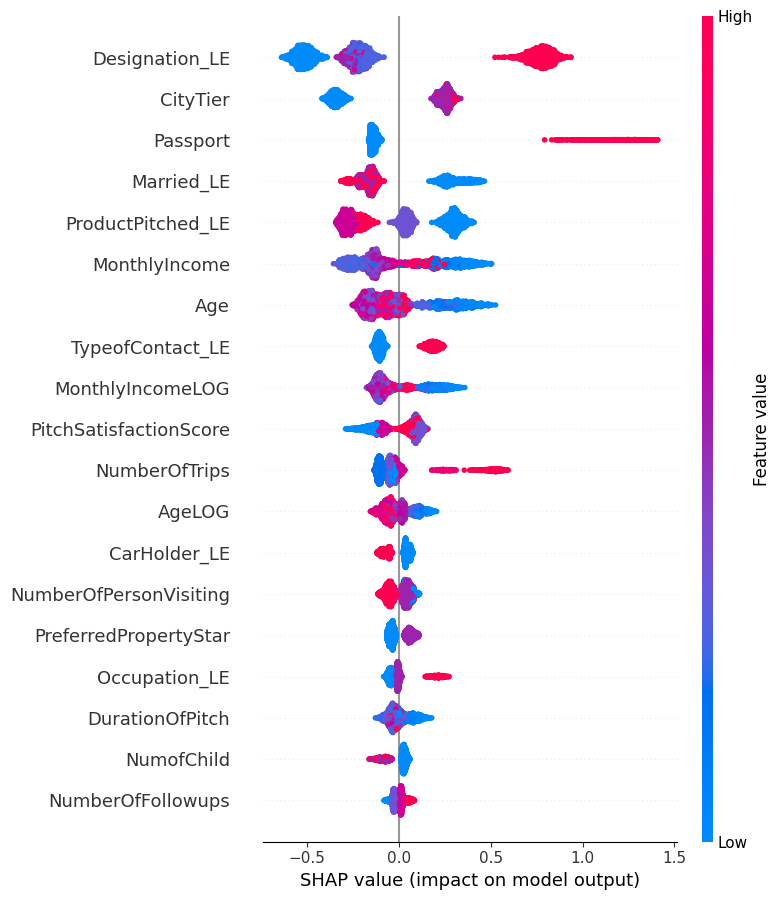

In [147]:
import shap
import lightgbm as lgb
import matplotlib.pyplot as plt

# 学習済みのモデル（例：lgb_model）
# 学習に使った特徴量データ（例：X_train）

# 横軸：SHAP値 (0からの貢献度、右=プラスの影響)
# 縦軸：特徴量 (上にあるほど重要)
# 色：その特徴の値 (赤=大きい値、青=小さい値)

# ① SHAPのexplainerを作成
explainer = shap.TreeExplainer(models[0])

# ② SHAP値を計算（X_trainは学習に使った特徴量データ）
shap_values = explainer.shap_values(train.drop("ProdTaken",axis=1))

# ③ summary plotで全体の重要度と分布を見る
shap.summary_plot(shap_values, train.drop("ProdTaken",axis=1))

In [291]:
# Optunaを使用する
import optuna
import lightgbm as lgb
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score

def objective(trial):

  lgbm_params = {
      'objective': 'binary',
      "device": "cpu",
      'metric': 'auc',
      # 'metric': 'rmse',
      'verbose': -1,              # ログ出力の制御
      'boosting_type': 'gbdt',
      'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
      'num_leaves': trial.suggest_int('num_leaves', 2, 256), # 20回
      'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1),
      'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
      # 'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1), # 2回目
      'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0),
      'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0),
      'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 100),
      'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),
      # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
      # 'max_depth': trial.suggest_int('max_depth', 3, 12),
      }

  for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    # インデックスに割り振る

    x_train = train.loc[train_index, FEATURES].copy()
    y_train = train.loc[train_index, TARGET]
    x_valid = train.loc[test_index, FEATURES].copy()
    y_valid = train.loc[test_index, TARGET]
    # x_test = test[FEATURES].copy()

    # データセット作成
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

    # 学習
    model_lgb = lgb.train(lgbm_params,
                          lgb_train,
                          num_boost_round = 2000,
                          valid_sets = [lgb_train, lgb_eval],
                          valid_names = ["train", "valid"],
                          callbacks = [
                              lgb.early_stopping(stopping_rounds=100, verbose=False),
                              # lgb.record_evaluation(evaluations_result),
                              lgb.log_evaluation(100),])

    oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)

  score = roc_auc_score(train[TARGET],oof_lgb)

  return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2025-05-22 14:49:21,646] A new study created in memory with name: no-name-e8d62f5c-af3d-4073-97ce-2f65e174cc01
<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


#########################
### Fold 1
#########################
[100]	train's auc: 0.8521	valid's auc: 0.830791
[200]	train's auc: 0.858987	valid's auc: 0.833942
[300]	train's auc: 0.863571	valid's auc: 0.835023
[400]	train's auc: 0.864433	valid's auc: 0.835331
#########################
### Fold 2
#########################
[100]	train's auc: 0.857265	valid's auc: 0.82918


[I 2025-05-22 14:49:22,290] Trial 0 finished with value: 0.8289933450973219 and parameters: {'feature_fraction': 0.5234738557352521, 'num_leaves': 20, 'bagging_fraction': 0.5256980346162979, 'bagging_freq': 3, 'lambda_l1': 9.976579326858404, 'lambda_l2': 2.9992574938990955, 'min_data_in_leaf': 18, 'learning_rate': 0.09009307499868047}. Best is trial 0 with value: 0.8289933450973219.


#########################
### Fold 3
#########################
[100]	train's auc: 0.85133	valid's auc: 0.825159
[200]	train's auc: 0.853591	valid's auc: 0.826435
#########################
### Fold 1
#########################


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.826401	valid's auc: 0.808993
#########################
### Fold 2
#########################
[100]	train's auc: 0.833882	valid's auc: 0.808289
[200]	train's auc: 0.836828	valid's auc: 0.809755
[300]	train's auc: 0.838182	valid's auc: 0.809522
#########################
### Fold 3
#########################


[I 2025-05-22 14:49:23,021] Trial 1 finished with value: 0.7972097289620073 and parameters: {'feature_fraction': 0.7611997019075859, 'num_leaves': 216, 'bagging_fraction': 0.7029819534955924, 'bagging_freq': 5, 'lambda_l1': 5.318225122241127, 'lambda_l2': 2.7256754882637453, 'min_data_in_leaf': 16, 'learning_rate': 0.0004066165026256652}. Best is trial 0 with value: 0.8289933450973219.


[100]	train's auc: 0.830794	valid's auc: 0.795439
#########################
### Fold 1
#########################
[100]	train's auc: 0.829363	valid's auc: 0.820615


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[200]	train's auc: 0.830748	valid's auc: 0.819661
#########################
### Fold 2
#########################
[100]	train's auc: 0.830724	valid's auc: 0.815338
#########################
### Fold 3
#########################
[100]	train's auc: 0.835162	valid's auc: 0.807357
[200]	train's auc: 0.835522	valid's auc: 0.809689
[300]	train's auc: 0.836081	valid's auc: 0.809665


[I 2025-05-22 14:49:23,851] Trial 2 finished with value: 0.7782554282916752 and parameters: {'feature_fraction': 0.5342998979240525, 'num_leaves': 28, 'bagging_fraction': 0.47201500663917834, 'bagging_freq': 5, 'lambda_l1': 1.0456690904823187, 'lambda_l2': 1.0578078932578043, 'min_data_in_leaf': 74, 'learning_rate': 0.0013332814904705413}. Best is trial 0 with value: 0.8289933450973219.


[400]	train's auc: 0.837449	valid's auc: 0.812224
[500]	train's auc: 0.83915	valid's auc: 0.813129
#########################
### Fold 1
#########################


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.816469	valid's auc: 0.811745
#########################
### Fold 2
#########################
[100]	train's auc: 0.823405	valid's auc: 0.81041
#########################
### Fold 3
#########################
[100]	train's auc: 0.824215	valid's auc: 0.797887


[I 2025-05-22 14:49:24,372] Trial 3 finished with value: 0.7952625512432887 and parameters: {'feature_fraction': 0.48778440995596434, 'num_leaves': 213, 'bagging_fraction': 0.47151837895101834, 'bagging_freq': 4, 'lambda_l1': 4.397674341709124, 'lambda_l2': 6.07364435422028, 'min_data_in_leaf': 36, 'learning_rate': 0.000209843110233068}. Best is trial 0 with value: 0.8289933450973219.


[200]	train's auc: 0.822508	valid's auc: 0.795567
#########################
### Fold 1
#########################
[100]	train's auc: 0.815627	valid's auc: 0.81373
[200]	train's auc: 0.817546	valid's auc: 0.811842


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


#########################
### Fold 2
#########################
[100]	train's auc: 0.820386	valid's auc: 0.807395
#########################
### Fold 3
#########################
[100]	train's auc: 0.824963	valid's auc: 0.795315
[200]	train's auc: 0.826411	valid's auc: 0.797838
[300]	train's auc: 0.826826	valid's auc: 0.799198
[400]	train's auc: 0.828953	valid's auc: 0.801482
[500]	train's auc: 0.83147	valid's auc: 0.802138
[600]	train's auc: 0.83326	valid's auc: 0.802979
[700]	train's auc: 0.834882	valid's auc: 0.804409
[800]	train's auc: 0.837509	valid's auc: 0.806795
[900]	train's auc: 0.839364	valid's auc: 0.808563
[1000]	train's auc: 0.841168	valid's auc: 0.810901
[1100]	train's auc: 0.842954	valid's auc: 0.812923
[1200]	train's auc: 0.8445	valid's auc: 0.814253
[1300]	train's auc: 0.846286	valid's auc: 0.815753
[1400]	train's auc: 0.84731	valid's auc: 0.816645
[1500]	train's auc: 0.848605	valid's auc: 0.817884
[1600]	train's auc: 0.849745	valid's auc: 0.818892
[1700]	train's auc: 0.

[I 2025-05-22 14:49:26,568] Trial 4 finished with value: 0.7787688699039155 and parameters: {'feature_fraction': 0.6518028601914957, 'num_leaves': 120, 'bagging_fraction': 0.6335823466738515, 'bagging_freq': 6, 'lambda_l1': 2.6147354398911746, 'lambda_l2': 9.053643270212218, 'min_data_in_leaf': 81, 'learning_rate': 0.0017607145366931418}. Best is trial 0 with value: 0.8289933450973219.


[2000]	train's auc: 0.853901	valid's auc: 0.822238
#########################
### Fold 1
#########################
[100]	train's auc: 0.8411	valid's auc: 0.824105


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[200]	train's auc: 0.842715	valid's auc: 0.824186
#########################
### Fold 2
#########################
[100]	train's auc: 0.842269	valid's auc: 0.815622
#########################
### Fold 3
#########################
[100]	train's auc: 0.840107	valid's auc: 0.804971


[I 2025-05-22 14:49:27,261] Trial 5 finished with value: 0.8018764323911383 and parameters: {'feature_fraction': 0.598875661924967, 'num_leaves': 217, 'bagging_fraction': 0.6775537511200436, 'bagging_freq': 4, 'lambda_l1': 2.7841288107368043, 'lambda_l2': 0.22105677279876557, 'min_data_in_leaf': 36, 'learning_rate': 0.00025513585087287864}. Best is trial 0 with value: 0.8289933450973219.
<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e

#########################
### Fold 1
#########################
[100]	train's auc: 0.828389	valid's auc: 0.819108
[200]	train's auc: 0.843642	valid's auc: 0.82938
[300]	train's auc: 0.850907	valid's auc: 0.831337
[400]	train's auc: 0.855828	valid's auc: 0.833694
[500]	train's auc: 0.859346	valid's auc: 0.834262
[600]	train's auc: 0.862564	valid's auc: 0.834981
[700]	train's auc: 0.866318	valid's auc: 0.835519
[800]	train's auc: 0.867998	valid's auc: 0.836425
[900]	train's auc: 0.86958	valid's auc: 0.836522
#########################
### Fold 2
#########################
[100]	train's auc: 0.833651	valid's auc: 0.816561
[200]	train's auc: 0.85016	valid's auc: 0.825038
[300]	train's auc: 0.857929	valid's auc: 0.827343
[400]	train's auc: 0.863665	valid's auc: 0.828099
[500]	train's auc: 0.867931	valid's auc: 0.828576
[600]	train's auc: 0.870992	valid's auc: 0.83005
[700]	train's auc: 0.873165	valid's auc: 0.829881
#########################
### Fold 3
#########################
[100]	train's a

[I 2025-05-22 14:49:29,486] Trial 6 finished with value: 0.8310592162601276 and parameters: {'feature_fraction': 0.5831666900870449, 'num_leaves': 89, 'bagging_fraction': 0.6193810643054116, 'bagging_freq': 6, 'lambda_l1': 6.429553277590012, 'lambda_l2': 8.82047052088358, 'min_data_in_leaf': 58, 'learning_rate': 0.017141763681255813}. Best is trial 6 with value: 0.8310592162601276.
<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.

#########################
### Fold 1
#########################
[100]	train's auc: 0.825824	valid's auc: 0.817008
[200]	train's auc: 0.825516	valid's auc: 0.815815
#########################
### Fold 2
#########################
[100]	train's auc: 0.82893	valid's auc: 0.809872
[200]	train's auc: 0.83428	valid's auc: 0.811758
[300]	train's auc: 0.83646	valid's auc: 0.812564
[400]	train's auc: 0.841219	valid's auc: 0.814371
[500]	train's auc: 0.844039	valid's auc: 0.815773
[600]	train's auc: 0.846236	valid's auc: 0.817519
[700]	train's auc: 0.849248	valid's auc: 0.818921
[800]	train's auc: 0.851821	valid's auc: 0.82054
[900]	train's auc: 0.854282	valid's auc: 0.821869
#########################
### Fold 3
#########################
[100]	train's auc: 0.832049	valid's auc: 0.79779
[200]	train's auc: 0.833805	valid's auc: 0.801433
[300]	train's auc: 0.835655	valid's auc: 0.803225
[400]	train's auc: 0.837964	valid's auc: 0.806729
[500]	train's auc: 0.840972	valid's auc: 0.809237
[600]	train's au

[I 2025-05-22 14:49:34,287] Trial 7 finished with value: 0.7964353635180065 and parameters: {'feature_fraction': 0.605309322534328, 'num_leaves': 196, 'bagging_fraction': 0.4780571858110515, 'bagging_freq': 6, 'lambda_l1': 2.131806554342453, 'lambda_l2': 3.642710071901896, 'min_data_in_leaf': 37, 'learning_rate': 0.0018695670327204812}. Best is trial 6 with value: 0.8310592162601276.


[2000]	train's auc: 0.866269	valid's auc: 0.82604
#########################
### Fold 1
#########################
[100]	train's auc: 0.834818	valid's auc: 0.814117


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[200]	train's auc: 0.83683	valid's auc: 0.814733
[300]	train's auc: 0.840489	valid's auc: 0.813434
#########################
### Fold 2
#########################
[100]	train's auc: 0.836239	valid's auc: 0.80551
[200]	train's auc: 0.838597	valid's auc: 0.808301
[300]	train's auc: 0.841166	valid's auc: 0.808685
[400]	train's auc: 0.845413	valid's auc: 0.811806
[500]	train's auc: 0.849576	valid's auc: 0.814788
[600]	train's auc: 0.85247	valid's auc: 0.815993
[700]	train's auc: 0.855108	valid's auc: 0.817785
[800]	train's auc: 0.85841	valid's auc: 0.819785
[900]	train's auc: 0.861644	valid's auc: 0.821579
[1000]	train's auc: 0.864087	valid's auc: 0.822331
[1100]	train's auc: 0.86658	valid's auc: 0.822872
[1200]	train's auc: 0.868679	valid's auc: 0.823676
[1300]	train's auc: 0.870701	valid's auc: 0.824159
[1400]	train's auc: 0.872639	valid's auc: 0.824516
[1500]	train's auc: 0.874426	valid's auc: 0.824757


[I 2025-05-22 14:49:36,802] Trial 8 finished with value: 0.7899260536480917 and parameters: {'feature_fraction': 0.8977390626065944, 'num_leaves': 242, 'bagging_fraction': 0.8198479303208359, 'bagging_freq': 6, 'lambda_l1': 5.900282419774433, 'lambda_l2': 2.883264203982761, 'min_data_in_leaf': 9, 'learning_rate': 0.0019135414682355826}. Best is trial 6 with value: 0.8310592162601276.


#########################
### Fold 3
#########################
[100]	train's auc: 0.839831	valid's auc: 0.794067
#########################
### Fold 1
#########################


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.821678	valid's auc: 0.812141
#########################
### Fold 2
#########################
[100]	train's auc: 0.826725	valid's auc: 0.804289
[200]	train's auc: 0.828677	valid's auc: 0.804362
#########################
### Fold 3
#########################
[100]	train's auc: 0.826291	valid's auc: 0.796721


[I 2025-05-22 14:49:37,459] Trial 9 finished with value: 0.7853366858907456 and parameters: {'feature_fraction': 0.6769184401209131, 'num_leaves': 189, 'bagging_fraction': 0.4854543955305152, 'bagging_freq': 4, 'lambda_l1': 2.993415875432098, 'lambda_l2': 7.918332658726153, 'min_data_in_leaf': 17, 'learning_rate': 0.00021378139742232196}. Best is trial 6 with value: 0.8310592162601276.


[200]	train's auc: 0.828133	valid's auc: 0.797641
#########################
### Fold 1
#########################


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.836096	valid's auc: 0.821969
[200]	train's auc: 0.851441	valid's auc: 0.831259
[300]	train's auc: 0.858095	valid's auc: 0.833627
[400]	train's auc: 0.862478	valid's auc: 0.834099
[500]	train's auc: 0.865714	valid's auc: 0.834401
[600]	train's auc: 0.867799	valid's auc: 0.834528
[700]	train's auc: 0.86884	valid's auc: 0.834667
#########################
### Fold 2
#########################
[100]	train's auc: 0.84352	valid's auc: 0.822069
[200]	train's auc: 0.857639	valid's auc: 0.828038
[300]	train's auc: 0.865535	valid's auc: 0.829241
#########################
### Fold 3
#########################
[100]	train's auc: 0.841274	valid's auc: 0.809258
[200]	train's auc: 0.852562	valid's auc: 0.820945
[300]	train's auc: 0.859292	valid's auc: 0.825621
[400]	train's auc: 0.863295	valid's auc: 0.827929
[500]	train's auc: 0.86581	valid's auc: 0.828427
[600]	train's auc: 0.867269	valid's auc: 0.829028


[I 2025-05-22 14:49:39,318] Trial 10 finished with value: 0.8301809520222942 and parameters: {'feature_fraction': 0.41367079642441135, 'num_leaves': 88, 'bagging_fraction': 0.978506245925294, 'bagging_freq': 1, 'lambda_l1': 7.828157109270737, 'lambda_l2': 6.480910292925014, 'min_data_in_leaf': 64, 'learning_rate': 0.02122458764010987}. Best is trial 6 with value: 0.8310592162601276.


[700]	train's auc: 0.867949	valid's auc: 0.829313
[800]	train's auc: 0.868486	valid's auc: 0.829526
[900]	train's auc: 0.868875	valid's auc: 0.829653


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


#########################
### Fold 1
#########################
[100]	train's auc: 0.843816	valid's auc: 0.825368
[200]	train's auc: 0.857945	valid's auc: 0.833319
[300]	train's auc: 0.864784	valid's auc: 0.833893
[400]	train's auc: 0.868548	valid's auc: 0.834346
[500]	train's auc: 0.870115	valid's auc: 0.834522
#########################
### Fold 2
#########################
[100]	train's auc: 0.848725	valid's auc: 0.823492
[200]	train's auc: 0.863673	valid's auc: 0.828189
[300]	train's auc: 0.871417	valid's auc: 0.828268
#########################
### Fold 3
#########################
[100]	train's auc: 0.846972	valid's auc: 0.815085
[200]	train's auc: 0.859121	valid's auc: 0.824783
[300]	train's auc: 0.86574	valid's auc: 0.827078
[400]	train's auc: 0.868624	valid's auc: 0.827643
[500]	train's auc: 0.869222	valid's auc: 0.828129
[600]	train's auc: 0.869497	valid's auc: 0.828433
[700]	train's auc: 0.869641	valid's auc: 0.828542


[I 2025-05-22 14:49:40,966] Trial 11 finished with value: 0.8293928006541926 and parameters: {'feature_fraction': 0.45405425114171216, 'num_leaves': 90, 'bagging_fraction': 0.991639962997025, 'bagging_freq': 1, 'lambda_l1': 7.947401328074957, 'lambda_l2': 6.818453467709704, 'min_data_in_leaf': 61, 'learning_rate': 0.027398017866287653}. Best is trial 6 with value: 0.8310592162601276.


[800]	train's auc: 0.869678	valid's auc: 0.828627
[900]	train's auc: 0.869781	valid's auc: 0.828615
[1000]	train's auc: 0.869917	valid's auc: 0.82873
#########################
### Fold 1
#########################


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.829767	valid's auc: 0.817319
[200]	train's auc: 0.844534	valid's auc: 0.826008
[300]	train's auc: 0.852062	valid's auc: 0.831639
[400]	train's auc: 0.857022	valid's auc: 0.833893
[500]	train's auc: 0.860403	valid's auc: 0.834636
[600]	train's auc: 0.863426	valid's auc: 0.834745
[700]	train's auc: 0.866037	valid's auc: 0.835065
#########################
### Fold 2
#########################
[100]	train's auc: 0.834207	valid's auc: 0.816008
[200]	train's auc: 0.850234	valid's auc: 0.825241
[300]	train's auc: 0.858494	valid's auc: 0.827833
[400]	train's auc: 0.864439	valid's auc: 0.829041
[500]	train's auc: 0.868323	valid's auc: 0.82918
[600]	train's auc: 0.871346	valid's auc: 0.829078
#########################
### Fold 3
#########################
[100]	train's auc: 0.836478	valid's auc: 0.804761
[200]	train's auc: 0.846432	valid's auc: 0.817426
[300]	train's auc: 0.853059	valid's auc: 0.82151
[400]	train's auc: 0.858212	valid's auc: 0.825087
[500]	train's auc: 0.86136

[I 2025-05-22 14:49:44,919] Trial 12 finished with value: 0.8297774615608087 and parameters: {'feature_fraction': 0.41646059652479306, 'num_leaves': 74, 'bagging_fraction': 0.9965703082711249, 'bagging_freq': 1, 'lambda_l1': 7.500467293540844, 'lambda_l2': 9.88071296893378, 'min_data_in_leaf': 60, 'learning_rate': 0.01434530512020062}. Best is trial 6 with value: 0.8310592162601276.


[1000]	train's auc: 0.869716	valid's auc: 0.828457
#########################
### Fold 1
#########################
[100]	train's auc: 0.820941	valid's auc: 0.814594


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[200]	train's auc: 0.83477	valid's auc: 0.821389
[300]	train's auc: 0.844905	valid's auc: 0.828368
[400]	train's auc: 0.850939	valid's auc: 0.831041
[500]	train's auc: 0.854958	valid's auc: 0.831954
[600]	train's auc: 0.858468	valid's auc: 0.832522
[700]	train's auc: 0.861372	valid's auc: 0.833229
[800]	train's auc: 0.86363	valid's auc: 0.833839
[900]	train's auc: 0.86516	valid's auc: 0.83422
[1000]	train's auc: 0.866632	valid's auc: 0.834745
[1100]	train's auc: 0.868095	valid's auc: 0.834854
[1200]	train's auc: 0.869265	valid's auc: 0.834703
#########################
### Fold 2
#########################
[100]	train's auc: 0.825841	valid's auc: 0.808371
[200]	train's auc: 0.844785	valid's auc: 0.820419
[300]	train's auc: 0.853331	valid's auc: 0.823489
[400]	train's auc: 0.85908	valid's auc: 0.825525
[500]	train's auc: 0.862876	valid's auc: 0.826419
[600]	train's auc: 0.866176	valid's auc: 0.827211
[700]	train's auc: 0.869247	valid's auc: 0.827857
[800]	train's auc: 0.870942	valid's auc

[I 2025-05-22 14:49:48,032] Trial 13 finished with value: 0.8291957628121672 and parameters: {'feature_fraction': 0.788076570755663, 'num_leaves': 149, 'bagging_fraction': 0.8517130451037802, 'bagging_freq': 7, 'lambda_l1': 7.447423086909705, 'lambda_l2': 5.4551290866825415, 'min_data_in_leaf': 98, 'learning_rate': 0.010074069063585265}. Best is trial 6 with value: 0.8310592162601276.


[1100]	train's auc: 0.867792	valid's auc: 0.826696
[1200]	train's auc: 0.868943	valid's auc: 0.82689


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


#########################
### Fold 1
#########################
[100]	train's auc: 0.85979	valid's auc: 0.828328
[200]	train's auc: 0.868735	valid's auc: 0.8308
[300]	train's auc: 0.872317	valid's auc: 0.83138
#########################
### Fold 2
#########################
[100]	train's auc: 0.867231	valid's auc: 0.82631
[200]	train's auc: 0.876968	valid's auc: 0.827833
#########################
### Fold 3
#########################
[100]	train's auc: 0.861637	valid's auc: 0.819815


[I 2025-05-22 14:49:48,931] Trial 14 finished with value: 0.8269577357191276 and parameters: {'feature_fraction': 0.9725619692966005, 'num_leaves': 68, 'bagging_fraction': 0.8400141694140005, 'bagging_freq': 2, 'lambda_l1': 9.518136166343863, 'lambda_l2': 7.7118719700071345, 'min_data_in_leaf': 48, 'learning_rate': 0.059905622477929986}. Best is trial 6 with value: 0.8310592162601276.


[200]	train's auc: 0.870136	valid's auc: 0.823319
[300]	train's auc: 0.873003	valid's auc: 0.824072
#########################
### Fold 1
#########################


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.817074	valid's auc: 0.811329
[200]	train's auc: 0.823186	valid's auc: 0.815715
[300]	train's auc: 0.83164	valid's auc: 0.822754
[400]	train's auc: 0.838949	valid's auc: 0.826265
[500]	train's auc: 0.843489	valid's auc: 0.829407
[600]	train's auc: 0.846588	valid's auc: 0.831168
[700]	train's auc: 0.849153	valid's auc: 0.832528
[800]	train's auc: 0.851384	valid's auc: 0.833501
[900]	train's auc: 0.853295	valid's auc: 0.833869
[1000]	train's auc: 0.855015	valid's auc: 0.834516
[1100]	train's auc: 0.856321	valid's auc: 0.834951
[1200]	train's auc: 0.857668	valid's auc: 0.835537
[1300]	train's auc: 0.858953	valid's auc: 0.835452
#########################
### Fold 2
#########################
[100]	train's auc: 0.821249	valid's auc: 0.811289
[200]	train's auc: 0.830621	valid's auc: 0.816767
[300]	train's auc: 0.839463	valid's auc: 0.82283
[400]	train's auc: 0.844952	valid's auc: 0.826002
[500]	train's auc: 0.849358	valid's auc: 0.827555
#########################
### Fold 

[I 2025-05-22 14:49:51,911] Trial 15 finished with value: 0.8285414357804581 and parameters: {'feature_fraction': 0.5693704285003957, 'num_leaves': 141, 'bagging_fraction': 0.5907083636712284, 'bagging_freq': 2, 'lambda_l1': 6.34841557249051, 'lambda_l2': 8.32849781416347, 'min_data_in_leaf': 76, 'learning_rate': 0.00702636430083129}. Best is trial 6 with value: 0.8310592162601276.


[1300]	train's auc: 0.858932	valid's auc: 0.830722
#########################
### Fold 1
#########################


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.836744	valid's auc: 0.828201
[200]	train's auc: 0.848204	valid's auc: 0.833615
[300]	train's auc: 0.853645	valid's auc: 0.835138
[400]	train's auc: 0.856286	valid's auc: 0.835289
[500]	train's auc: 0.858263	valid's auc: 0.835331
#########################
### Fold 2
#########################
[100]	train's auc: 0.842443	valid's auc: 0.824271
[200]	train's auc: 0.854508	valid's auc: 0.829688
#########################
### Fold 3
#########################
[100]	train's auc: 0.839747	valid's auc: 0.816621
[200]	train's auc: 0.848574	valid's auc: 0.826714
[300]	train's auc: 0.854047	valid's auc: 0.8287
[400]	train's auc: 0.856692	valid's auc: 0.831086
[500]	train's auc: 0.858333	valid's auc: 0.832088
[600]	train's auc: 0.859834	valid's auc: 0.832945
[700]	train's auc: 0.860814	valid's auc: 0.832975


[I 2025-05-22 14:49:53,416] Trial 16 finished with value: 0.8316731942456881 and parameters: {'feature_fraction': 0.40682163819350176, 'num_leaves': 107, 'bagging_fraction': 0.7484273879276786, 'bagging_freq': 7, 'lambda_l1': 8.541794451399975, 'lambda_l2': 4.717532703567859, 'min_data_in_leaf': 91, 'learning_rate': 0.0301647456913371}. Best is trial 16 with value: 0.8316731942456881.


[800]	train's auc: 0.861434	valid's auc: 0.8334
[900]	train's auc: 0.862029	valid's auc: 0.8334
#########################
### Fold 1
#########################


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.817293	valid's auc: 0.81135
[200]	train's auc: 0.819471	valid's auc: 0.813446
[300]	train's auc: 0.824639	valid's auc: 0.815398
[400]	train's auc: 0.83038	valid's auc: 0.818706
[500]	train's auc: 0.83601	valid's auc: 0.822833
[600]	train's auc: 0.839847	valid's auc: 0.825945
[700]	train's auc: 0.842132	valid's auc: 0.827301
[800]	train's auc: 0.845544	valid's auc: 0.82993
[900]	train's auc: 0.847961	valid's auc: 0.831223
[1000]	train's auc: 0.849742	valid's auc: 0.832304
[1100]	train's auc: 0.851061	valid's auc: 0.833386
[1200]	train's auc: 0.852318	valid's auc: 0.833573
[1300]	train's auc: 0.853289	valid's auc: 0.833923
[1400]	train's auc: 0.854125	valid's auc: 0.83402
#########################
### Fold 2
#########################
[100]	train's auc: 0.818661	valid's auc: 0.808462


[I 2025-05-22 14:49:56,672] Trial 17 finished with value: 0.7918641528314271 and parameters: {'feature_fraction': 0.7315990486973591, 'num_leaves': 48, 'bagging_fraction': 0.7612613684019787, 'bagging_freq': 7, 'lambda_l1': 8.548979887853607, 'lambda_l2': 4.515242110291074, 'min_data_in_leaf': 98, 'learning_rate': 0.0046098935281058805}. Best is trial 16 with value: 0.8316731942456881.


[200]	train's auc: 0.823329	valid's auc: 0.810126
#########################
### Fold 3
#########################
[100]	train's auc: 0.821744	valid's auc: 0.793381
[200]	train's auc: 0.824816	valid's auc: 0.794361


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


#########################
### Fold 1
#########################
[100]	train's auc: 0.854166	valid's auc: 0.829694
[200]	train's auc: 0.869044	valid's auc: 0.833555
#########################
### Fold 2
#########################
[100]	train's auc: 0.863748	valid's auc: 0.820618
[200]	train's auc: 0.879443	valid's auc: 0.821694
#########################
### Fold 3
#########################
[100]	train's auc: 0.853957	valid's auc: 0.820101
[200]	train's auc: 0.86863	valid's auc: 0.821564


[I 2025-05-22 14:49:57,703] Trial 18 finished with value: 0.8269550457827177 and parameters: {'feature_fraction': 0.8529660984492875, 'num_leaves': 117, 'bagging_fraction': 0.5607882761572162, 'bagging_freq': 7, 'lambda_l1': 4.453585370736906, 'lambda_l2': 5.045625076531354, 'min_data_in_leaf': 47, 'learning_rate': 0.034408878441085866}. Best is trial 16 with value: 0.8316731942456881.


[300]	train's auc: 0.878195	valid's auc: 0.826155
[400]	train's auc: 0.886074	valid's auc: 0.828305


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


#########################
### Fold 1
#########################
[100]	train's auc: 0.830162	valid's auc: 0.825482
[200]	train's auc: 0.84139	valid's auc: 0.829893
[300]	train's auc: 0.84562	valid's auc: 0.832401
[400]	train's auc: 0.849785	valid's auc: 0.834431
[500]	train's auc: 0.851871	valid's auc: 0.835198
[600]	train's auc: 0.853416	valid's auc: 0.835754
[700]	train's auc: 0.855622	valid's auc: 0.836848
#########################
### Fold 2
#########################
[100]	train's auc: 0.834935	valid's auc: 0.820905
[200]	train's auc: 0.845463	valid's auc: 0.82634
[300]	train's auc: 0.85075	valid's auc: 0.828637
[400]	train's auc: 0.853704	valid's auc: 0.829247
[500]	train's auc: 0.855526	valid's auc: 0.829924
[600]	train's auc: 0.858479	valid's auc: 0.830491
[700]	train's auc: 0.859741	valid's auc: 0.830703
#########################
### Fold 3
#########################
[100]	train's auc: 0.834338	valid's auc: 0.818063
[200]	train's auc: 0.839241	valid's auc: 0.826131
[300]	train's a

[I 2025-05-22 14:49:59,427] Trial 19 finished with value: 0.8332084754516402 and parameters: {'feature_fraction': 0.4755712571258622, 'num_leaves': 160, 'bagging_fraction': 0.4110857369151418, 'bagging_freq': 5, 'lambda_l1': 8.726818181559906, 'lambda_l2': 4.14184226000431, 'min_data_in_leaf': 87, 'learning_rate': 0.04271955006122382}. Best is trial 19 with value: 0.8332084754516402.


[600]	train's auc: 0.849836	valid's auc: 0.835094
[700]	train's auc: 0.851682	valid's auc: 0.834493
#########################
### Fold 1
#########################


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.848231	valid's auc: 0.831235
[200]	train's auc: 0.858047	valid's auc: 0.833875
[300]	train's auc: 0.861132	valid's auc: 0.83509
[400]	train's auc: 0.862893	valid's auc: 0.835307
[500]	train's auc: 0.864291	valid's auc: 0.835821
[600]	train's auc: 0.864445	valid's auc: 0.835851
#########################
### Fold 2
#########################
[100]	train's auc: 0.853996	valid's auc: 0.826084
[200]	train's auc: 0.86404	valid's auc: 0.826365
#########################
### Fold 3
#########################
[100]	train's auc: 0.849242	valid's auc: 0.818328
[200]	train's auc: 0.859079	valid's auc: 0.825402
[300]	train's auc: 0.862379	valid's auc: 0.826617
[400]	train's auc: 0.863698	valid's auc: 0.827188
[500]	train's auc: 0.864792	valid's auc: 0.828287
[600]	train's auc: 0.865689	valid's auc: 0.828475
[700]	train's auc: 0.86644	valid's auc: 0.828961


[I 2025-05-22 14:50:00,807] Trial 20 finished with value: 0.8294835860080267 and parameters: {'feature_fraction': 0.47339185551298635, 'num_leaves': 172, 'bagging_fraction': 0.9081148166538479, 'bagging_freq': 5, 'lambda_l1': 9.161975221141558, 'lambda_l2': 1.922153855386885, 'min_data_in_leaf': 87, 'learning_rate': 0.04168223858690508}. Best is trial 19 with value: 0.8332084754516402.
<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4

#########################
### Fold 1
#########################
[100]	train's auc: 0.846067	valid's auc: 0.833223
#########################
### Fold 2
#########################
[100]	train's auc: 0.849265	valid's auc: 0.823108
[200]	train's auc: 0.859972	valid's auc: 0.822268
#########################
### Fold 3
#########################
[100]	train's auc: 0.841238	valid's auc: 0.827455
[200]	train's auc: 0.850914	valid's auc: 0.829999
[300]	train's auc: 0.855527	valid's auc: 0.831402
[400]	train's auc: 0.857091	valid's auc: 0.833242


[I 2025-05-22 14:50:01,611] Trial 21 finished with value: 0.8291473439567889 and parameters: {'feature_fraction': 0.4063949837272438, 'num_leaves': 107, 'bagging_fraction': 0.4162158515913863, 'bagging_freq': 6, 'lambda_l1': 6.684212638000229, 'lambda_l2': 4.097471173883607, 'min_data_in_leaf': 93, 'learning_rate': 0.0982599165552331}. Best is trial 19 with value: 0.8332084754516402.


[500]	train's auc: 0.859621	valid's auc: 0.832799
#########################
### Fold 1
#########################
[100]	train's auc: 0.8263	valid's auc: 0.818773


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[200]	train's auc: 0.840853	valid's auc: 0.828842
[300]	train's auc: 0.847451	valid's auc: 0.832736
[400]	train's auc: 0.851623	valid's auc: 0.834026
[500]	train's auc: 0.853728	valid's auc: 0.835507
[600]	train's auc: 0.856024	valid's auc: 0.836014
[700]	train's auc: 0.85757	valid's auc: 0.83599
[800]	train's auc: 0.858963	valid's auc: 0.836491
[900]	train's auc: 0.860135	valid's auc: 0.836721
[1000]	train's auc: 0.861398	valid's auc: 0.836945
[1100]	train's auc: 0.862031	valid's auc: 0.837198
[1200]	train's auc: 0.862801	valid's auc: 0.837186
#########################
### Fold 2
#########################
[100]	train's auc: 0.831288	valid's auc: 0.816329
[200]	train's auc: 0.847387	valid's auc: 0.824655
[300]	train's auc: 0.85447	valid's auc: 0.827313
[400]	train's auc: 0.858975	valid's auc: 0.828479
[500]	train's auc: 0.861689	valid's auc: 0.829543
[600]	train's auc: 0.863979	valid's auc: 0.829265
#########################
### Fold 3
#########################
[100]	train's auc: 0.831

[I 2025-05-22 14:50:03,915] Trial 22 finished with value: 0.8317108533554267 and parameters: {'feature_fraction': 0.5203056361112691, 'num_leaves': 154, 'bagging_fraction': 0.7445689470836852, 'bagging_freq': 5, 'lambda_l1': 8.773973092791492, 'lambda_l2': 4.903846496379097, 'min_data_in_leaf': 86, 'learning_rate': 0.015727844037552736}. Best is trial 19 with value: 0.8332084754516402.


[500]	train's auc: 0.854571	valid's auc: 0.82918
[600]	train's auc: 0.856517	valid's auc: 0.830078
[700]	train's auc: 0.857071	valid's auc: 0.830564


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


#########################
### Fold 1
#########################
[100]	train's auc: 0.817811	valid's auc: 0.811972
[200]	train's auc: 0.82713	valid's auc: 0.818525
[300]	train's auc: 0.834479	valid's auc: 0.823244
[400]	train's auc: 0.840403	valid's auc: 0.826419
[500]	train's auc: 0.843974	valid's auc: 0.829337
[600]	train's auc: 0.847666	valid's auc: 0.831839
[700]	train's auc: 0.849841	valid's auc: 0.833422
[800]	train's auc: 0.851428	valid's auc: 0.833923
[900]	train's auc: 0.853139	valid's auc: 0.834485
[1000]	train's auc: 0.854435	valid's auc: 0.834993
[1100]	train's auc: 0.8554	valid's auc: 0.835223
[1200]	train's auc: 0.856316	valid's auc: 0.835615
[1300]	train's auc: 0.857475	valid's auc: 0.835603
[1400]	train's auc: 0.858353	valid's auc: 0.83576
#########################
### Fold 2
#########################
[100]	train's auc: 0.824471	valid's auc: 0.811434
[200]	train's auc: 0.834992	valid's auc: 0.815546
[300]	train's auc: 0.84227	valid's auc: 0.820265
[400]	train's auc: 0.848

[I 2025-05-22 14:50:08,681] Trial 23 finished with value: 0.8296886936592819 and parameters: {'feature_fraction': 0.5134349083304277, 'num_leaves': 147, 'bagging_fraction': 0.7591198224208898, 'bagging_freq': 5, 'lambda_l1': 8.836774122526766, 'lambda_l2': 5.305179875750849, 'min_data_in_leaf': 87, 'learning_rate': 0.007933620479456734}. Best is trial 19 with value: 0.8332084754516402.
<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4

#########################
### Fold 1
#########################
[100]	train's auc: 0.848562	valid's auc: 0.832957
[200]	train's auc: 0.857961	valid's auc: 0.834159
[300]	train's auc: 0.862184	valid's auc: 0.835929
[400]	train's auc: 0.864539	valid's auc: 0.836207
#########################
### Fold 2
#########################
[100]	train's auc: 0.854278	valid's auc: 0.827779
#########################
### Fold 3
#########################
[100]	train's auc: 0.849148	valid's auc: 0.822062
[200]	train's auc: 0.858771	valid's auc: 0.828633
[300]	train's auc: 0.862048	valid's auc: 0.830704
[400]	train's auc: 0.864553	valid's auc: 0.831433
[500]	train's auc: 0.86698	valid's auc: 0.832975


[I 2025-05-22 14:50:09,890] Trial 24 finished with value: 0.830415312732007 and parameters: {'feature_fraction': 0.4713238526779289, 'num_leaves': 166, 'bagging_fraction': 0.7361238638752299, 'bagging_freq': 3, 'lambda_l1': 8.45129018573575, 'lambda_l2': 3.947745426544866, 'min_data_in_leaf': 72, 'learning_rate': 0.05513523744392955}. Best is trial 19 with value: 0.8332084754516402.


[600]	train's auc: 0.869248	valid's auc: 0.833449
[700]	train's auc: 0.871097	valid's auc: 0.833388
#########################
### Fold 1
#########################


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.821484	valid's auc: 0.812851
[200]	train's auc: 0.833585	valid's auc: 0.82222
[300]	train's auc: 0.841828	valid's auc: 0.828087
[400]	train's auc: 0.84661	valid's auc: 0.832346
[500]	train's auc: 0.84927	valid's auc: 0.834721
[600]	train's auc: 0.851803	valid's auc: 0.835434
[700]	train's auc: 0.853433	valid's auc: 0.83576
[800]	train's auc: 0.85475	valid's auc: 0.836087
[900]	train's auc: 0.855657	valid's auc: 0.836232
[1000]	train's auc: 0.856469	valid's auc: 0.836346
[1100]	train's auc: 0.857164	valid's auc: 0.836503
[1200]	train's auc: 0.857626	valid's auc: 0.836648
[1300]	train's auc: 0.858109	valid's auc: 0.836836
[1400]	train's auc: 0.858671	valid's auc: 0.836993
#########################
### Fold 2
#########################
[100]	train's auc: 0.826937	valid's auc: 0.812371
[200]	train's auc: 0.840386	valid's auc: 0.818461
[300]	train's auc: 0.848336	valid's auc: 0.82512
[400]	train's auc: 0.853178	valid's auc: 0.826473
[500]	train's auc: 0.856188	valid's au

[I 2025-05-22 14:50:14,065] Trial 25 finished with value: 0.831927393236424 and parameters: {'feature_fraction': 0.45194684513631056, 'num_leaves': 166, 'bagging_fraction': 0.8006908690556866, 'bagging_freq': 3, 'lambda_l1': 9.814236028508867, 'lambda_l2': 5.818223024229341, 'min_data_in_leaf': 88, 'learning_rate': 0.011745147393122228}. Best is trial 19 with value: 0.8332084754516402.


[1900]	train's auc: 0.86063	valid's auc: 0.8319
[2000]	train's auc: 0.860929	valid's auc: 0.832107
#########################
### Fold 1
#########################


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.818258	valid's auc: 0.810229
[200]	train's auc: 0.820549	valid's auc: 0.811652
[300]	train's auc: 0.826075	valid's auc: 0.813392
[400]	train's auc: 0.833489	valid's auc: 0.818489
[500]	train's auc: 0.838719	valid's auc: 0.821606
[600]	train's auc: 0.842529	valid's auc: 0.825156
[700]	train's auc: 0.845771	valid's auc: 0.827682
[800]	train's auc: 0.848172	valid's auc: 0.829126
[900]	train's auc: 0.850196	valid's auc: 0.830365
[1000]	train's auc: 0.851944	valid's auc: 0.831392
[1100]	train's auc: 0.853168	valid's auc: 0.83199
[1200]	train's auc: 0.854388	valid's auc: 0.832703
[1300]	train's auc: 0.855432	valid's auc: 0.833029
[1400]	train's auc: 0.856404	valid's auc: 0.833301
[1500]	train's auc: 0.857276	valid's auc: 0.833585
[1600]	train's auc: 0.858133	valid's auc: 0.833984
[1700]	train's auc: 0.858786	valid's auc: 0.834087
[1800]	train's auc: 0.859378	valid's auc: 0.834105
#########################
### Fold 2
#########################
[100]	train's auc: 0.823018	v

[I 2025-05-22 14:50:19,776] Trial 26 finished with value: 0.8006787382046289 and parameters: {'feature_fraction': 0.6326934386688357, 'num_leaves': 169, 'bagging_fraction': 0.8996354051847142, 'bagging_freq': 3, 'lambda_l1': 9.749945244142545, 'lambda_l2': 7.190313198083174, 'min_data_in_leaf': 80, 'learning_rate': 0.004725241585082508}. Best is trial 19 with value: 0.8332084754516402.
<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4

#########################
### Fold 1
#########################
[100]	train's auc: 0.825576	valid's auc: 0.815268
[200]	train's auc: 0.841555	valid's auc: 0.825824
[300]	train's auc: 0.847919	valid's auc: 0.830612
[400]	train's auc: 0.85338	valid's auc: 0.83292
[500]	train's auc: 0.857334	valid's auc: 0.834425
[600]	train's auc: 0.859961	valid's auc: 0.835241
[700]	train's auc: 0.862746	valid's auc: 0.835936
[800]	train's auc: 0.864739	valid's auc: 0.836123
#########################
### Fold 2
#########################
[100]	train's auc: 0.830691	valid's auc: 0.812534
[200]	train's auc: 0.846299	valid's auc: 0.821165
[300]	train's auc: 0.854057	valid's auc: 0.825259
[400]	train's auc: 0.859629	valid's auc: 0.82709
[500]	train's auc: 0.864282	valid's auc: 0.827537
[600]	train's auc: 0.867943	valid's auc: 0.82834
[700]	train's auc: 0.870613	valid's auc: 0.828262
#########################
### Fold 3
#########################
[100]	train's auc: 0.832305	valid's auc: 0.801977
[200]	train's a

[I 2025-05-22 14:50:22,764] Trial 27 finished with value: 0.8303060340653547 and parameters: {'feature_fraction': 0.5494380781502878, 'num_leaves': 134, 'bagging_fraction': 0.7880569431466764, 'bagging_freq': 4, 'lambda_l1': 6.938825562082906, 'lambda_l2': 5.849674067322262, 'min_data_in_leaf': 71, 'learning_rate': 0.011709557488343066}. Best is trial 19 with value: 0.8332084754516402.
<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4

#########################
### Fold 1
#########################
[100]	train's auc: 0.817311	valid's auc: 0.810277
#########################
### Fold 2
#########################
[100]	train's auc: 0.820249	valid's auc: 0.809347
[200]	train's auc: 0.824275	valid's auc: 0.811111
[300]	train's auc: 0.828635	valid's auc: 0.813613
[400]	train's auc: 0.832929	valid's auc: 0.816069
[500]	train's auc: 0.836055	valid's auc: 0.818528
[600]	train's auc: 0.83883	valid's auc: 0.820389
[700]	train's auc: 0.841409	valid's auc: 0.82277
[800]	train's auc: 0.843847	valid's auc: 0.824739
[900]	train's auc: 0.845611	valid's auc: 0.826069
[1000]	train's auc: 0.847642	valid's auc: 0.827476
[1100]	train's auc: 0.849332	valid's auc: 0.827893
[1200]	train's auc: 0.85054	valid's auc: 0.828032
[1300]	train's auc: 0.851782	valid's auc: 0.82851
[1400]	train's auc: 0.852588	valid's auc: 0.828328
#########################
### Fold 3
#########################
[100]	train's auc: 0.821585	valid's auc: 0.793703
[200]	trai

[I 2025-05-22 14:50:26,290] Trial 28 finished with value: 0.7959273017785861 and parameters: {'feature_fraction': 0.4582099307332352, 'num_leaves': 185, 'bagging_fraction': 0.678304822821654, 'bagging_freq': 2, 'lambda_l1': 9.333607843532134, 'lambda_l2': 2.073713629220339, 'min_data_in_leaf': 81, 'learning_rate': 0.0036105102109083268}. Best is trial 19 with value: 0.8332084754516402.


[1900]	train's auc: 0.851009	valid's auc: 0.826769
[2000]	train's auc: 0.851527	valid's auc: 0.827139
#########################
### Fold 1
#########################


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.828723	valid's auc: 0.819806
[200]	train's auc: 0.844234	valid's auc: 0.829485
[300]	train's auc: 0.850386	valid's auc: 0.832636
[400]	train's auc: 0.853837	valid's auc: 0.834667
[500]	train's auc: 0.856439	valid's auc: 0.835652
[600]	train's auc: 0.858068	valid's auc: 0.835833
[700]	train's auc: 0.85888	valid's auc: 0.836026
[800]	train's auc: 0.859666	valid's auc: 0.835996
[900]	train's auc: 0.860346	valid's auc: 0.836026
[1000]	train's auc: 0.860868	valid's auc: 0.836268
[1100]	train's auc: 0.861527	valid's auc: 0.836455
[1200]	train's auc: 0.861959	valid's auc: 0.836473
[1300]	train's auc: 0.862307	valid's auc: 0.836473
[1400]	train's auc: 0.862814	valid's auc: 0.836522
#########################
### Fold 2
#########################
[100]	train's auc: 0.836823	valid's auc: 0.817174
[200]	train's auc: 0.850792	valid's auc: 0.825809
[300]	train's auc: 0.857386	valid's auc: 0.827597
[400]	train's auc: 0.861644	valid's auc: 0.828165
[500]	train's auc: 0.864368	valid

[I 2025-05-22 14:50:29,027] Trial 29 finished with value: 0.8309038724324556 and parameters: {'feature_fraction': 0.5187079670491743, 'num_leaves': 250, 'bagging_fraction': 0.9122935699515488, 'bagging_freq': 3, 'lambda_l1': 9.925386121818953, 'lambda_l2': 3.415821686477626, 'min_data_in_leaf': 100, 'learning_rate': 0.017698802327883012}. Best is trial 19 with value: 0.8332084754516402.


[800]	train's auc: 0.859935	valid's auc: 0.828663
[900]	train's auc: 0.860555	valid's auc: 0.829088


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


#########################
### Fold 1
#########################
[100]	train's auc: 0.837296	valid's auc: 0.830014
[200]	train's auc: 0.844443	valid's auc: 0.832383
[300]	train's auc: 0.85167	valid's auc: 0.835597
[400]	train's auc: 0.854366	valid's auc: 0.836449
#########################
### Fold 2
#########################
[100]	train's auc: 0.845115	valid's auc: 0.827126
#########################
### Fold 3
#########################
[100]	train's auc: 0.838539	valid's auc: 0.824479
[200]	train's auc: 0.846562	valid's auc: 0.831657


[I 2025-05-22 14:50:31,801] Trial 30 finished with value: 0.829972818192578 and parameters: {'feature_fraction': 0.4976108246610014, 'num_leaves': 159, 'bagging_fraction': 0.408739033418201, 'bagging_freq': 3, 'lambda_l1': 8.01308424302451, 'lambda_l2': 4.618894602514555, 'min_data_in_leaf': 88, 'learning_rate': 0.06230104348518484}. Best is trial 19 with value: 0.8332084754516402.


[300]	train's auc: 0.849342	valid's auc: 0.833382
[400]	train's auc: 0.851453	valid's auc: 0.835896
[500]	train's auc: 0.853055	valid's auc: 0.835714


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


#########################
### Fold 1
#########################
[100]	train's auc: 0.835541	valid's auc: 0.826165
[200]	train's auc: 0.846769	valid's auc: 0.832975
[300]	train's auc: 0.85129	valid's auc: 0.83463
[400]	train's auc: 0.854699	valid's auc: 0.834528
#########################
### Fold 2
#########################
[100]	train's auc: 0.840074	valid's auc: 0.822721
[200]	train's auc: 0.852582	valid's auc: 0.828069
[300]	train's auc: 0.858256	valid's auc: 0.82854
[400]	train's auc: 0.861127	valid's auc: 0.829905
[500]	train's auc: 0.863324	valid's auc: 0.83051
[600]	train's auc: 0.864769	valid's auc: 0.830498
#########################
### Fold 3
#########################
[100]	train's auc: 0.837908	valid's auc: 0.812744
[200]	train's auc: 0.84626	valid's auc: 0.823277
[300]	train's auc: 0.851769	valid's auc: 0.82802
[400]	train's auc: 0.85358	valid's auc: 0.830819
[500]	train's auc: 0.855691	valid's auc: 0.830667


[I 2025-05-22 14:50:33,596] Trial 31 finished with value: 0.8312979481165066 and parameters: {'feature_fraction': 0.4390333651937102, 'num_leaves': 128, 'bagging_fraction': 0.715418518578775, 'bagging_freq': 5, 'lambda_l1': 8.795473260950398, 'lambda_l2': 4.810103894036729, 'min_data_in_leaf': 92, 'learning_rate': 0.028385626726958508}. Best is trial 19 with value: 0.8332084754516402.


[600]	train's auc: 0.857026	valid's auc: 0.831864
[700]	train's auc: 0.858751	valid's auc: 0.831985


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


#########################
### Fold 1
#########################
[100]	train's auc: 0.845429	valid's auc: 0.832044
[200]	train's auc: 0.857105	valid's auc: 0.834274
[300]	train's auc: 0.861822	valid's auc: 0.83538
[400]	train's auc: 0.864722	valid's auc: 0.83463
#########################
### Fold 2
#########################
[100]	train's auc: 0.85221	valid's auc: 0.82757
[200]	train's auc: 0.863762	valid's auc: 0.828745
[300]	train's auc: 0.868405	valid's auc: 0.828896
#########################
### Fold 3
#########################
[100]	train's auc: 0.848132	valid's auc: 0.822384
[200]	train's auc: 0.857181	valid's auc: 0.827182
[300]	train's auc: 0.86095	valid's auc: 0.828153
[400]	train's auc: 0.8631	valid's auc: 0.830686


[I 2025-05-22 14:50:34,932] Trial 32 finished with value: 0.831107635115506 and parameters: {'feature_fraction': 0.43884719140701534, 'num_leaves': 106, 'bagging_fraction': 0.7912110628936281, 'bagging_freq': 5, 'lambda_l1': 8.412919916707956, 'lambda_l2': 6.184969940017912, 'min_data_in_leaf': 67, 'learning_rate': 0.045270466353522096}. Best is trial 19 with value: 0.8332084754516402.


[500]	train's auc: 0.865258	valid's auc: 0.831086
[600]	train's auc: 0.865437	valid's auc: 0.831329
#########################
### Fold 1
#########################
[100]	train's auc: 0.812975	valid's auc: 0.809824


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[200]	train's auc: 0.812223	valid's auc: 0.808395
#########################
### Fold 2
#########################
[100]	train's auc: 0.817375	valid's auc: 0.808434
#########################
### Fold 3
#########################
[100]	train's auc: 0.817023	valid's auc: 0.791161
[200]	train's auc: 0.817446	valid's auc: 0.793202


[I 2025-05-22 14:50:35,642] Trial 33 finished with value: 0.7886490063374901 and parameters: {'feature_fraction': 0.5441074066629022, 'num_leaves': 203, 'bagging_fraction': 0.6831195743378823, 'bagging_freq': 7, 'lambda_l1': 9.921847709034852, 'lambda_l2': 4.3186555683593415, 'min_data_in_leaf': 93, 'learning_rate': 0.0008608351645174055}. Best is trial 19 with value: 0.8332084754516402.
<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e

#########################
### Fold 1
#########################
[100]	train's auc: 0.818204	valid's auc: 0.81215
#########################
### Fold 2
#########################
[100]	train's auc: 0.822114	valid's auc: 0.811812
#########################
### Fold 3
#########################
[100]	train's auc: 0.820377	valid's auc: 0.799238


[I 2025-05-22 14:50:36,223] Trial 34 finished with value: 0.7954458031612132 and parameters: {'feature_fraction': 0.40104407066740533, 'num_leaves': 179, 'bagging_fraction': 0.653130031374854, 'bagging_freq': 4, 'lambda_l1': 5.255655866281479, 'lambda_l2': 5.5550705325197125, 'min_data_in_leaf': 83, 'learning_rate': 0.00011639283347585137}. Best is trial 19 with value: 0.8332084754516402.


[200]	train's auc: 0.818822	valid's auc: 0.799414
#########################
### Fold 1
#########################


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.865793	valid's auc: 0.830763
[200]	train's auc: 0.892642	valid's auc: 0.833041
[300]	train's auc: 0.910127	valid's auc: 0.832854
#########################
### Fold 2
#########################
[100]	train's auc: 0.873865	valid's auc: 0.823205
[200]	train's auc: 0.899922	valid's auc: 0.826038
#########################
### Fold 3
#########################
[100]	train's auc: 0.866074	valid's auc: 0.819384
[200]	train's auc: 0.890819	valid's auc: 0.829854


[I 2025-05-22 14:50:37,526] Trial 35 finished with value: 0.829213919882934 and parameters: {'feature_fraction': 0.5034943156444717, 'num_leaves': 11, 'bagging_fraction': 0.8695581978979119, 'bagging_freq': 5, 'lambda_l1': 0.11001945129317114, 'lambda_l2': 3.268869176597429, 'min_data_in_leaf': 77, 'learning_rate': 0.024726791217141855}. Best is trial 19 with value: 0.8332084754516402.


[300]	train's auc: 0.908441	valid's auc: 0.830655
[400]	train's auc: 0.922646	valid's auc: 0.829082
#########################
### Fold 1
#########################


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.827228	valid's auc: 0.814153
[200]	train's auc: 0.83356	valid's auc: 0.819325
[300]	train's auc: 0.842008	valid's auc: 0.824878
[400]	train's auc: 0.848166	valid's auc: 0.828854
[500]	train's auc: 0.85232	valid's auc: 0.831494
[600]	train's auc: 0.855447	valid's auc: 0.832848
[700]	train's auc: 0.857779	valid's auc: 0.834316
[800]	train's auc: 0.85999	valid's auc: 0.834999
[900]	train's auc: 0.86213	valid's auc: 0.835229
[1000]	train's auc: 0.863909	valid's auc: 0.835766
[1100]	train's auc: 0.865381	valid's auc: 0.836171
[1200]	train's auc: 0.866532	valid's auc: 0.836008
#########################
### Fold 2
#########################
[100]	train's auc: 0.828953	valid's auc: 0.812655
[200]	train's auc: 0.838888	valid's auc: 0.816579
[300]	train's auc: 0.847298	valid's auc: 0.822806
[400]	train's auc: 0.85364	valid's auc: 0.827779
[500]	train's auc: 0.857746	valid's auc: 0.829223
[600]	train's auc: 0.860977	valid's auc: 0.829881
[700]	train's auc: 0.863694	valid's auc

[I 2025-05-22 14:50:43,485] Trial 36 finished with value: 0.8310074349842369 and parameters: {'feature_fraction': 0.4932886770242313, 'num_leaves': 157, 'bagging_fraction': 0.7268797953967627, 'bagging_freq': 3, 'lambda_l1': 7.059751397315822, 'lambda_l2': 6.779893377958406, 'min_data_in_leaf': 25, 'learning_rate': 0.007597347481489034}. Best is trial 19 with value: 0.8332084754516402.


[1900]	train's auc: 0.873189	valid's auc: 0.831165
[2000]	train's auc: 0.873934	valid's auc: 0.831372
#########################
### Fold 1
#########################


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.853851	valid's auc: 0.835262
[200]	train's auc: 0.861837	valid's auc: 0.835591
#########################
### Fold 2
#########################
[100]	train's auc: 0.861488	valid's auc: 0.827507
#########################
### Fold 3
#########################
[100]	train's auc: 0.853174	valid's auc: 0.828147


[I 2025-05-22 14:50:44,197] Trial 37 finished with value: 0.8306651405760768 and parameters: {'feature_fraction': 0.44182083055531646, 'num_leaves': 125, 'bagging_fraction': 0.8126770516189404, 'bagging_freq': 4, 'lambda_l1': 8.974815502797227, 'lambda_l2': 2.238882332277215, 'min_data_in_leaf': 86, 'learning_rate': 0.07937210248175094}. Best is trial 19 with value: 0.8332084754516402.


[200]	train's auc: 0.859944	valid's auc: 0.829447
[300]	train's auc: 0.860562	valid's auc: 0.829908
#########################
### Fold 1
#########################


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.8215	valid's auc: 0.817625
[200]	train's auc: 0.833785	valid's auc: 0.826235
[300]	train's auc: 0.840985	valid's auc: 0.830044
[400]	train's auc: 0.84511	valid's auc: 0.834135
[500]	train's auc: 0.848655	valid's auc: 0.835573
[600]	train's auc: 0.851148	valid's auc: 0.835996
[700]	train's auc: 0.853493	valid's auc: 0.835917
[800]	train's auc: 0.854429	valid's auc: 0.83654
[900]	train's auc: 0.855794	valid's auc: 0.836884
[1000]	train's auc: 0.857505	valid's auc: 0.837645
[1100]	train's auc: 0.85871	valid's auc: 0.838159
[1200]	train's auc: 0.859925	valid's auc: 0.838213
#########################
### Fold 2
#########################
[100]	train's auc: 0.829915	valid's auc: 0.814954
[200]	train's auc: 0.842073	valid's auc: 0.823492
[300]	train's auc: 0.84781	valid's auc: 0.825374
[400]	train's auc: 0.853103	valid's auc: 0.827567
[500]	train's auc: 0.85649	valid's auc: 0.827954
[600]	train's auc: 0.859181	valid's auc: 0.829464
[700]	train's auc: 0.861347	valid's auc: 

[I 2025-05-22 14:50:47,259] Trial 38 finished with value: 0.8328170897039994 and parameters: {'feature_fraction': 0.624114524889215, 'num_leaves': 224, 'bagging_fraction': 0.5458651487005828, 'bagging_freq': 6, 'lambda_l1': 8.117100110623557, 'lambda_l2': 2.606941127088743, 'min_data_in_leaf': 92, 'learning_rate': 0.013351060502600192}. Best is trial 19 with value: 0.8332084754516402.


[1100]	train's auc: 0.857626	valid's auc: 0.831809
#########################
### Fold 1
#########################
[100]	train's auc: 0.809947	valid's auc: 0.803737


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[200]	train's auc: 0.82211	valid's auc: 0.816383
[300]	train's auc: 0.826173	valid's auc: 0.81877
[400]	train's auc: 0.830766	valid's auc: 0.821969
[500]	train's auc: 0.835201	valid's auc: 0.825141
[600]	train's auc: 0.838409	valid's auc: 0.826724
[700]	train's auc: 0.841075	valid's auc: 0.827857
[800]	train's auc: 0.842891	valid's auc: 0.829513
[900]	train's auc: 0.844183	valid's auc: 0.830322
[1000]	train's auc: 0.845785	valid's auc: 0.83176
[1100]	train's auc: 0.847228	valid's auc: 0.832884
[1200]	train's auc: 0.848316	valid's auc: 0.833857
[1300]	train's auc: 0.849135	valid's auc: 0.834437
[1400]	train's auc: 0.849774	valid's auc: 0.834534
#########################
### Fold 2
#########################
[100]	train's auc: 0.818927	valid's auc: 0.803691
[200]	train's auc: 0.829057	valid's auc: 0.815582
[300]	train's auc: 0.832363	valid's auc: 0.816461
[400]	train's auc: 0.838297	valid's auc: 0.820848
[500]	train's auc: 0.842103	valid's auc: 0.822999
[600]	train's auc: 0.844517	valid's

[I 2025-05-22 14:50:51,526] Trial 39 finished with value: 0.8303746274438073 and parameters: {'feature_fraction': 0.6281951782258732, 'num_leaves': 235, 'bagging_fraction': 0.5471195633288144, 'bagging_freq': 6, 'lambda_l1': 9.309308656566579, 'lambda_l2': 1.1491563286009259, 'min_data_in_leaf': 96, 'learning_rate': 0.006248325317086086}. Best is trial 19 with value: 0.8332084754516402.
<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-

#########################
### Fold 1
#########################
[100]	train's auc: 0.823458	valid's auc: 0.81847
[200]	train's auc: 0.841041	valid's auc: 0.829927
[300]	train's auc: 0.848752	valid's auc: 0.832872
[400]	train's auc: 0.853389	valid's auc: 0.835108
[500]	train's auc: 0.856831	valid's auc: 0.836564
[600]	train's auc: 0.859626	valid's auc: 0.837458
[700]	train's auc: 0.862682	valid's auc: 0.836926
#########################
### Fold 2
#########################
[100]	train's auc: 0.83542	valid's auc: 0.819316
[200]	train's auc: 0.849116	valid's auc: 0.823676
[300]	train's auc: 0.855466	valid's auc: 0.825857
[400]	train's auc: 0.861513	valid's auc: 0.827851
[500]	train's auc: 0.865457	valid's auc: 0.828733
[600]	train's auc: 0.868813	valid's auc: 0.829712
#########################
### Fold 3
#########################
[100]	train's auc: 0.833592	valid's auc: 0.805308
[200]	train's auc: 0.84466	valid's auc: 0.817231
[300]	train's auc: 0.850553	valid's auc: 0.823902
[400]	train's 

[I 2025-05-22 14:50:55,385] Trial 40 finished with value: 0.8326906626927338 and parameters: {'feature_fraction': 0.695748753432541, 'num_leaves': 217, 'bagging_fraction': 0.5258465470369496, 'bagging_freq': 6, 'lambda_l1': 6.022453134157203, 'lambda_l2': 2.5825275505931558, 'min_data_in_leaf': 69, 'learning_rate': 0.014049567967601023}. Best is trial 19 with value: 0.8332084754516402.
<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4

#########################
### Fold 1
#########################
[100]	train's auc: 0.824561	valid's auc: 0.821211
[200]	train's auc: 0.842456	valid's auc: 0.831751
[300]	train's auc: 0.849285	valid's auc: 0.833821
[400]	train's auc: 0.853813	valid's auc: 0.836093
[500]	train's auc: 0.85775	valid's auc: 0.837307
[600]	train's auc: 0.860555	valid's auc: 0.83805
[700]	train's auc: 0.863938	valid's auc: 0.837488
#########################
### Fold 2
#########################
[100]	train's auc: 0.836367	valid's auc: 0.820244
[200]	train's auc: 0.849602	valid's auc: 0.823766
[300]	train's auc: 0.855836	valid's auc: 0.824582
[400]	train's auc: 0.862171	valid's auc: 0.82686
[500]	train's auc: 0.865897	valid's auc: 0.827368
[600]	train's auc: 0.869446	valid's auc: 0.828727
#########################
### Fold 3
#########################
[100]	train's auc: 0.833882	valid's auc: 0.803531
[200]	train's auc: 0.845555	valid's auc: 0.817969
[300]	train's auc: 0.851727	valid's auc: 0.823678
[400]	train's 

[I 2025-05-22 14:50:57,424] Trial 41 finished with value: 0.8312959306641992 and parameters: {'feature_fraction': 0.6931279994591436, 'num_leaves': 227, 'bagging_fraction': 0.5190573873273298, 'bagging_freq': 6, 'lambda_l1': 5.723396345752605, 'lambda_l2': 1.3743729546586558, 'min_data_in_leaf': 69, 'learning_rate': 0.013362110145369473}. Best is trial 19 with value: 0.8332084754516402.
<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-

#########################
### Fold 1
#########################
[100]	train's auc: 0.82392	valid's auc: 0.816676
[200]	train's auc: 0.838699	valid's auc: 0.82689
[300]	train's auc: 0.848264	valid's auc: 0.830775
[400]	train's auc: 0.854349	valid's auc: 0.833277
[500]	train's auc: 0.859634	valid's auc: 0.835386
[600]	train's auc: 0.863287	valid's auc: 0.835893
[700]	train's auc: 0.867272	valid's auc: 0.835718
#########################
### Fold 2
#########################
[100]	train's auc: 0.835207	valid's auc: 0.815202
[200]	train's auc: 0.849024	valid's auc: 0.821918
[300]	train's auc: 0.855124	valid's auc: 0.82364
[400]	train's auc: 0.862719	valid's auc: 0.826649
[500]	train's auc: 0.867759	valid's auc: 0.827833
[600]	train's auc: 0.871705	valid's auc: 0.828884
#########################
### Fold 3
#########################
[100]	train's auc: 0.833377	valid's auc: 0.801102
[200]	train's auc: 0.844835	valid's auc: 0.814514
[300]	train's auc: 0.851101	valid's auc: 0.820975
[400]	train's 

[I 2025-05-22 14:50:59,887] Trial 42 finished with value: 0.8311231022498629 and parameters: {'feature_fraction': 0.7346022569907135, 'num_leaves': 210, 'bagging_fraction': 0.5053624348170933, 'bagging_freq': 6, 'lambda_l1': 4.602235873403201, 'lambda_l2': 2.6312262262122603, 'min_data_in_leaf': 55, 'learning_rate': 0.010196000987190059}. Best is trial 19 with value: 0.8332084754516402.
<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-

#########################
### Fold 1
#########################
[100]	train's auc: 0.826071	valid's auc: 0.821751
[200]	train's auc: 0.841704	valid's auc: 0.827658
[300]	train's auc: 0.847062	valid's auc: 0.831948
[400]	train's auc: 0.85132	valid's auc: 0.834365
[500]	train's auc: 0.854175	valid's auc: 0.835059
[600]	train's auc: 0.855972	valid's auc: 0.834618
#########################
### Fold 2
#########################
[100]	train's auc: 0.835068	valid's auc: 0.818606
[200]	train's auc: 0.846115	valid's auc: 0.825519
[300]	train's auc: 0.852457	valid's auc: 0.828377
[400]	train's auc: 0.856819	valid's auc: 0.82964
[500]	train's auc: 0.859476	valid's auc: 0.82999
[600]	train's auc: 0.86252	valid's auc: 0.830207
#########################
### Fold 3
#########################
[100]	train's auc: 0.834146	valid's auc: 0.809905
[200]	train's auc: 0.840309	valid's auc: 0.820538
[300]	train's auc: 0.847444	valid's auc: 0.825275
[400]	train's auc: 0.849493	valid's auc: 0.82805
[500]	train's au

[I 2025-05-22 14:51:01,815] Trial 43 finished with value: 0.8321587277676754 and parameters: {'feature_fraction': 0.5811822773320438, 'num_leaves': 228, 'bagging_fraction': 0.4533324855747115, 'bagging_freq': 5, 'lambda_l1': 7.551476822271598, 'lambda_l2': 0.15487182899443663, 'min_data_in_leaf': 78, 'learning_rate': 0.01851310474344318}. Best is trial 19 with value: 0.8332084754516402.


[600]	train's auc: 0.853975	valid's auc: 0.831554
[700]	train's auc: 0.855891	valid's auc: 0.83139
#########################
### Fold 1
#########################


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.829367	valid's auc: 0.823649
[200]	train's auc: 0.845354	valid's auc: 0.832497
[300]	train's auc: 0.851773	valid's auc: 0.833368
[400]	train's auc: 0.856466	valid's auc: 0.834975
[500]	train's auc: 0.860323	valid's auc: 0.836497
[600]	train's auc: 0.86327	valid's auc: 0.837174
[700]	train's auc: 0.865705	valid's auc: 0.83634
#########################
### Fold 2
#########################
[100]	train's auc: 0.841252	valid's auc: 0.822845
[200]	train's auc: 0.850961	valid's auc: 0.82399
[300]	train's auc: 0.857838	valid's auc: 0.825319
[400]	train's auc: 0.864256	valid's auc: 0.826999
[500]	train's auc: 0.868063	valid's auc: 0.828782
[600]	train's auc: 0.870852	valid's auc: 0.829573
#########################
### Fold 3
#########################
[100]	train's auc: 0.83526	valid's auc: 0.808754
[200]	train's auc: 0.846028	valid's auc: 0.822196
[300]	train's auc: 0.852679	valid's auc: 0.827607
[400]	train's auc: 0.85695	valid's auc: 0.829161
[500]	train's auc: 0.859771	v

[I 2025-05-22 14:51:03,704] Trial 44 finished with value: 0.8321809197430573 and parameters: {'feature_fraction': 0.6688537651562309, 'num_leaves': 225, 'bagging_fraction': 0.46258003084955623, 'bagging_freq': 6, 'lambda_l1': 5.994621018201577, 'lambda_l2': 0.05573124662617701, 'min_data_in_leaf': 77, 'learning_rate': 0.018976767018536577}. Best is trial 19 with value: 0.8332084754516402.
<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1

#########################
### Fold 1
#########################
[100]	train's auc: 0.837926	valid's auc: 0.8288
[200]	train's auc: 0.853767	valid's auc: 0.834479
[300]	train's auc: 0.863253	valid's auc: 0.834655
[400]	train's auc: 0.869818	valid's auc: 0.832068
#########################
### Fold 2
#########################
[100]	train's auc: 0.848346	valid's auc: 0.822927
[200]	train's auc: 0.862595	valid's auc: 0.824075
[300]	train's auc: 0.871588	valid's auc: 0.825156
[400]	train's auc: 0.880547	valid's auc: 0.826987
[500]	train's auc: 0.885327	valid's auc: 0.828697
[600]	train's auc: 0.890007	valid's auc: 0.829452
#########################
### Fold 3
#########################
[100]	train's auc: 0.839753	valid's auc: 0.812789
[200]	train's auc: 0.854663	valid's auc: 0.826016
[300]	train's auc: 0.863203	valid's auc: 0.8302
[400]	train's auc: 0.869136	valid's auc: 0.829945


[I 2025-05-22 14:51:06,841] Trial 45 finished with value: 0.8315386974251929 and parameters: {'feature_fraction': 0.6637650994519038, 'num_leaves': 222, 'bagging_fraction': 0.4391857247780198, 'bagging_freq': 6, 'lambda_l1': 3.5428192914310426, 'lambda_l2': 0.2508164119989041, 'min_data_in_leaf': 78, 'learning_rate': 0.02153624120035454}. Best is trial 19 with value: 0.8332084754516402.
<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-

#########################
### Fold 1
#########################
[100]	train's auc: 0.83153	valid's auc: 0.824631
[200]	train's auc: 0.846109	valid's auc: 0.830407
[300]	train's auc: 0.852018	valid's auc: 0.832884
[400]	train's auc: 0.856654	valid's auc: 0.833784
[500]	train's auc: 0.860323	valid's auc: 0.834407
[600]	train's auc: 0.862561	valid's auc: 0.834322
#########################
### Fold 2
#########################
[100]	train's auc: 0.839798	valid's auc: 0.822078
[200]	train's auc: 0.851897	valid's auc: 0.827253
[300]	train's auc: 0.85773	valid's auc: 0.828769
[400]	train's auc: 0.863891	valid's auc: 0.83002
[500]	train's auc: 0.866985	valid's auc: 0.830872
[600]	train's auc: 0.870761	valid's auc: 0.830359
#########################
### Fold 3
#########################
[100]	train's auc: 0.838997	valid's auc: 0.815294
[200]	train's auc: 0.847052	valid's auc: 0.82423
[300]	train's auc: 0.853402	valid's auc: 0.829198
[400]	train's auc: 0.855703	valid's auc: 0.831694
[500]	train's a

[I 2025-05-22 14:51:08,882] Trial 46 finished with value: 0.8332784137982977 and parameters: {'feature_fraction': 0.6045181181680704, 'num_leaves': 238, 'bagging_fraction': 0.4405389964462245, 'bagging_freq': 5, 'lambda_l1': 6.001719677970661, 'lambda_l2': 0.5027406901596828, 'min_data_in_leaf': 65, 'learning_rate': 0.019518916994322344}. Best is trial 46 with value: 0.8332784137982977.
<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-

#########################
### Fold 1
#########################
[100]	train's auc: 0.814954	valid's auc: 0.813588
[200]	train's auc: 0.817779	valid's auc: 0.811724
#########################
### Fold 2
#########################
[100]	train's auc: 0.821783	valid's auc: 0.808265
[200]	train's auc: 0.825159	valid's auc: 0.809425
[300]	train's auc: 0.828637	valid's auc: 0.811114
[400]	train's auc: 0.83369	valid's auc: 0.815123
[500]	train's auc: 0.838261	valid's auc: 0.818878
[600]	train's auc: 0.841175	valid's auc: 0.8208
[700]	train's auc: 0.843991	valid's auc: 0.821839
[800]	train's auc: 0.846741	valid's auc: 0.823694
[900]	train's auc: 0.849434	valid's auc: 0.824679
[1000]	train's auc: 0.851228	valid's auc: 0.825011
[1100]	train's auc: 0.853045	valid's auc: 0.825833
[1200]	train's auc: 0.854314	valid's auc: 0.825996
[1300]	train's auc: 0.855795	valid's auc: 0.826618
[1400]	train's auc: 0.856948	valid's auc: 0.826908
[1500]	train's auc: 0.858092	valid's auc: 0.827519
[1600]	train's auc: 0

[I 2025-05-22 14:51:12,731] Trial 47 finished with value: 0.8024258519028611 and parameters: {'feature_fraction': 0.7745140699792935, 'num_leaves': 255, 'bagging_fraction': 0.4913258571283205, 'bagging_freq': 6, 'lambda_l1': 5.914292478535574, 'lambda_l2': 0.6965710317793163, 'min_data_in_leaf': 62, 'learning_rate': 0.002688371814332432}. Best is trial 46 with value: 0.8332784137982977.
<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-

#########################
### Fold 1
#########################
[100]	train's auc: 0.816237	valid's auc: 0.813011
[200]	train's auc: 0.816603	valid's auc: 0.811178
#########################
### Fold 2
#########################
[100]	train's auc: 0.821029	valid's auc: 0.808549
[200]	train's auc: 0.823594	valid's auc: 0.808178
#########################
### Fold 3
#########################
[100]	train's auc: 0.825905	valid's auc: 0.795661
[200]	train's auc: 0.826526	valid's auc: 0.798002


[I 2025-05-22 14:51:13,491] Trial 48 finished with value: 0.7946862323674668 and parameters: {'feature_fraction': 0.7258902862299687, 'num_leaves': 241, 'bagging_fraction': 0.4521806383626672, 'bagging_freq': 5, 'lambda_l1': 5.029449422348777, 'lambda_l2': 1.5346142843877522, 'min_data_in_leaf': 49, 'learning_rate': 0.0009002898856920568}. Best is trial 46 with value: 0.8332784137982977.


[300]	train's auc: 0.8257	valid's auc: 0.798026
#########################
### Fold 1
#########################
[100]	train's auc: 0.858636	valid's auc: 0.831954


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[200]	train's auc: 0.878021	valid's auc: 0.833972
#########################
### Fold 2
#########################
[100]	train's auc: 0.869014	valid's auc: 0.824993
[200]	train's auc: 0.887771	valid's auc: 0.825217
#########################
### Fold 3
#########################
[100]	train's auc: 0.860027	valid's auc: 0.822749
[200]	train's auc: 0.875119	valid's auc: 0.82641
[300]	train's auc: 0.886384	valid's auc: 0.831499


[I 2025-05-22 14:51:14,506] Trial 49 finished with value: 0.8311674862006262 and parameters: {'feature_fraction': 0.8087810420750325, 'num_leaves': 197, 'bagging_fraction': 0.5966198701194103, 'bagging_freq': 6, 'lambda_l1': 3.9703954628306564, 'lambda_l2': 0.6940901636351628, 'min_data_in_leaf': 73, 'learning_rate': 0.0389075531733772}. Best is trial 46 with value: 0.8332784137982977.


[400]	train's auc: 0.897113	valid's auc: 0.827929
#########################
### Fold 1
#########################
[100]	train's auc: 0.836778	valid's auc: 0.826304


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[200]	train's auc: 0.850945	valid's auc: 0.834479
[300]	train's auc: 0.85803	valid's auc: 0.834618
#########################
### Fold 2
#########################
[100]	train's auc: 0.844501	valid's auc: 0.823504
[200]	train's auc: 0.857444	valid's auc: 0.826751
[300]	train's auc: 0.864507	valid's auc: 0.827434
[400]	train's auc: 0.870895	valid's auc: 0.828782
[500]	train's auc: 0.874163	valid's auc: 0.828075
[600]	train's auc: 0.876755	valid's auc: 0.829579
[700]	train's auc: 0.879474	valid's auc: 0.829114
#########################
### Fold 3
#########################
[100]	train's auc: 0.842259	valid's auc: 0.813776
[200]	train's auc: 0.852333	valid's auc: 0.825287
[300]	train's auc: 0.858414	valid's auc: 0.829544
[400]	train's auc: 0.862964	valid's auc: 0.831171
[500]	train's auc: 0.866514	valid's auc: 0.832167
[600]	train's auc: 0.86948	valid's auc: 0.832422
[700]	train's auc: 0.871908	valid's auc: 0.833588


[I 2025-05-22 14:51:16,399] Trial 50 finished with value: 0.8306691754806916 and parameters: {'feature_fraction': 0.6060009653188553, 'num_leaves': 210, 'bagging_fraction': 0.5403266808870943, 'bagging_freq': 6, 'lambda_l1': 6.127350986535931, 'lambda_l2': 2.7438964742144067, 'min_data_in_leaf': 66, 'learning_rate': 0.024312239516530186}. Best is trial 46 with value: 0.8332784137982977.


[800]	train's auc: 0.874066	valid's auc: 0.833898
#########################
### Fold 1
#########################


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.82749	valid's auc: 0.822029
[200]	train's auc: 0.842817	valid's auc: 0.82973
[300]	train's auc: 0.848013	valid's auc: 0.833144
[400]	train's auc: 0.85232	valid's auc: 0.834721
[500]	train's auc: 0.855158	valid's auc: 0.835766
[600]	train's auc: 0.857312	valid's auc: 0.835839
#########################
### Fold 2
#########################
[100]	train's auc: 0.835955	valid's auc: 0.817292
[200]	train's auc: 0.848811	valid's auc: 0.826655
[300]	train's auc: 0.854924	valid's auc: 0.829211
[400]	train's auc: 0.859554	valid's auc: 0.830993
[500]	train's auc: 0.862649	valid's auc: 0.831192
#########################
### Fold 3
#########################
[100]	train's auc: 0.836547	valid's auc: 0.812762
[200]	train's auc: 0.842701	valid's auc: 0.820702
[300]	train's auc: 0.850183	valid's auc: 0.825402
[400]	train's auc: 0.852482	valid's auc: 0.827473
[500]	train's auc: 0.854765	valid's auc: 0.829259
[600]	train's auc: 0.856792	valid's auc: 0.830285


[I 2025-05-22 14:51:20,033] Trial 51 finished with value: 0.8320437329861522 and parameters: {'feature_fraction': 0.5778082244061684, 'num_leaves': 230, 'bagging_fraction': 0.4475034468579254, 'bagging_freq': 5, 'lambda_l1': 7.2911281646868815, 'lambda_l2': 0.12227046197114877, 'min_data_in_leaf': 56, 'learning_rate': 0.017007510427401885}. Best is trial 46 with value: 0.8332784137982977.


[700]	train's auc: 0.859107	valid's auc: 0.830977
#########################
### Fold 1
#########################


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.826738	valid's auc: 0.820416
[200]	train's auc: 0.840438	valid's auc: 0.827528
[300]	train's auc: 0.84597	valid's auc: 0.831694
[400]	train's auc: 0.850524	valid's auc: 0.834002
[500]	train's auc: 0.853095	valid's auc: 0.835192
[600]	train's auc: 0.855042	valid's auc: 0.835017
#########################
### Fold 2
#########################
[100]	train's auc: 0.833723	valid's auc: 0.818307
[200]	train's auc: 0.845343	valid's auc: 0.824262
[300]	train's auc: 0.851438	valid's auc: 0.827966
[400]	train's auc: 0.856081	valid's auc: 0.829488
[500]	train's auc: 0.858945	valid's auc: 0.830081
[600]	train's auc: 0.861771	valid's auc: 0.830129
#########################
### Fold 3
#########################
[100]	train's auc: 0.836615	valid's auc: 0.809686
[200]	train's auc: 0.842073	valid's auc: 0.819372
[300]	train's auc: 0.847845	valid's auc: 0.823489
[400]	train's auc: 0.850222	valid's auc: 0.826362
[500]	train's auc: 0.852772	valid's auc: 0.827759
[600]	train's auc: 0.8549

[I 2025-05-22 14:51:22,221] Trial 52 finished with value: 0.831452619460076 and parameters: {'feature_fraction': 0.6385503689895783, 'num_leaves': 219, 'bagging_fraction': 0.4621250237841438, 'bagging_freq': 5, 'lambda_l1': 7.761612006495961, 'lambda_l2': 0.7283224106850481, 'min_data_in_leaf': 75, 'learning_rate': 0.01816258113716193}. Best is trial 46 with value: 0.8332784137982977.
<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4,

#########################
### Fold 1
#########################
[100]	train's auc: 0.837696	valid's auc: 0.828652
[200]	train's auc: 0.848237	valid's auc: 0.834123
[300]	train's auc: 0.858082	valid's auc: 0.835168
[400]	train's auc: 0.86141	valid's auc: 0.837084
#########################
### Fold 2
#########################
[100]	train's auc: 0.845795	valid's auc: 0.824256
[200]	train's auc: 0.858371	valid's auc: 0.828534
#########################
### Fold 3
#########################
[100]	train's auc: 0.83833	valid's auc: 0.818227
[200]	train's auc: 0.849685	valid's auc: 0.829362
[300]	train's auc: 0.856819	valid's auc: 0.832101


[I 2025-05-22 14:51:23,476] Trial 53 finished with value: 0.8329051851214236 and parameters: {'feature_fraction': 0.6893907829051199, 'num_leaves': 247, 'bagging_fraction': 0.4204641586014223, 'bagging_freq': 7, 'lambda_l1': 5.638474495769821, 'lambda_l2': 1.7082726388142475, 'min_data_in_leaf': 83, 'learning_rate': 0.032881702135561984}. Best is trial 46 with value: 0.8332784137982977.


[400]	train's auc: 0.861044	valid's auc: 0.8332
[500]	train's auc: 0.864786	valid's auc: 0.835513
[600]	train's auc: 0.867606	valid's auc: 0.834548


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


#########################
### Fold 1
#########################
[100]	train's auc: 0.850898	valid's auc: 0.835754
#########################
### Fold 2
#########################
[100]	train's auc: 0.857808	valid's auc: 0.826776
[200]	train's auc: 0.872031	valid's auc: 0.829162
#########################
### Fold 3
#########################
[100]	train's auc: 0.851994	valid's auc: 0.824862
[200]	train's auc: 0.860644	valid's auc: 0.830012
[300]	train's auc: 0.869239	valid's auc: 0.83272


[I 2025-05-22 14:51:24,344] Trial 54 finished with value: 0.8316570546272287 and parameters: {'feature_fraction': 0.6800542469527628, 'num_leaves': 248, 'bagging_fraction': 0.42438213091570437, 'bagging_freq': 7, 'lambda_l1': 5.669196406723177, 'lambda_l2': 1.5915679344884024, 'min_data_in_leaf': 81, 'learning_rate': 0.07277277437450154}. Best is trial 46 with value: 0.8332784137982977.


[400]	train's auc: 0.87268	valid's auc: 0.833157
#########################
### Fold 1
#########################


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.845936	valid's auc: 0.832815
[200]	train's auc: 0.856265	valid's auc: 0.833292
#########################
### Fold 2
#########################
[100]	train's auc: 0.85281	valid's auc: 0.82506
[200]	train's auc: 0.864297	valid's auc: 0.827211
#########################
### Fold 3
#########################
[100]	train's auc: 0.846993	valid's auc: 0.820666
[200]	train's auc: 0.855404	valid's auc: 0.826957
[300]	train's auc: 0.862184	valid's auc: 0.828985


[I 2025-05-22 14:51:25,340] Trial 55 finished with value: 0.8286534043835204 and parameters: {'feature_fraction': 0.7121361236906868, 'num_leaves': 238, 'bagging_fraction': 0.48184869129585883, 'bagging_freq': 7, 'lambda_l1': 6.554762153363408, 'lambda_l2': 2.285223702821506, 'min_data_in_leaf': 83, 'learning_rate': 0.048705650753450326}. Best is trial 46 with value: 0.8332784137982977.


[400]	train's auc: 0.866175	valid's auc: 0.829325
[500]	train's auc: 0.869358	valid's auc: 0.830333
#########################
### Fold 1
#########################


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.85126	valid's auc: 0.832059
[200]	train's auc: 0.862546	valid's auc: 0.83521
#########################
### Fold 2
#########################
[100]	train's auc: 0.856258	valid's auc: 0.830162
[200]	train's auc: 0.870077	valid's auc: 0.831422
#########################
### Fold 3
#########################
[100]	train's auc: 0.848815	valid's auc: 0.822955
[200]	train's auc: 0.860644	valid's auc: 0.829301
[300]	train's auc: 0.869166	valid's auc: 0.831414
[400]	train's auc: 0.875279	valid's auc: 0.832562
[500]	train's auc: 0.880092	valid's auc: 0.834997


[I 2025-05-22 14:51:26,572] Trial 56 finished with value: 0.832913927414756 and parameters: {'feature_fraction': 0.6137795033547616, 'num_leaves': 195, 'bagging_fraction': 0.40039872673120136, 'bagging_freq': 7, 'lambda_l1': 4.7472562776573, 'lambda_l2': 0.9641533553638917, 'min_data_in_leaf': 42, 'learning_rate': 0.03850041035206593}. Best is trial 46 with value: 0.8332784137982977.


[600]	train's auc: 0.885914	valid's auc: 0.833315
#########################
### Fold 1
#########################


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.847636	valid's auc: 0.83092
[200]	train's auc: 0.860561	valid's auc: 0.834969
#########################
### Fold 2
#########################
[100]	train's auc: 0.85611	valid's auc: 0.827413
[200]	train's auc: 0.870536	valid's auc: 0.828322
#########################
### Fold 3
#########################
[100]	train's auc: 0.849233	valid's auc: 0.817271
[200]	train's auc: 0.862497	valid's auc: 0.826325
[300]	train's auc: 0.871613	valid's auc: 0.828663
[400]	train's auc: 0.877355	valid's auc: 0.831924
[500]	train's auc: 0.883362	valid's auc: 0.834262
[600]	train's auc: 0.889145	valid's auc: 0.833072


[I 2025-05-22 14:51:27,808] Trial 57 finished with value: 0.831340987099065 and parameters: {'feature_fraction': 0.616933297616593, 'num_leaves': 193, 'bagging_fraction': 0.4045005327220387, 'bagging_freq': 7, 'lambda_l1': 4.036087718731517, 'lambda_l2': 3.097240640467498, 'min_data_in_leaf': 39, 'learning_rate': 0.034097026985036125}. Best is trial 46 with value: 0.8332784137982977.
<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 

#########################
### Fold 1
#########################
[100]	train's auc: 0.848862	valid's auc: 0.832788
[200]	train's auc: 0.86073	valid's auc: 0.837386
[300]	train's auc: 0.870692	valid's auc: 0.837059
#########################
### Fold 2
#########################
[100]	train's auc: 0.854593	valid's auc: 0.825289
[200]	train's auc: 0.868968	valid's auc: 0.826685
#########################
### Fold 3
#########################
[100]	train's auc: 0.849212	valid's auc: 0.818838
[200]	train's auc: 0.861116	valid's auc: 0.824564
[300]	train's auc: 0.870109	valid's auc: 0.82621


[I 2025-05-22 14:51:30,741] Trial 58 finished with value: 0.830535351144299 and parameters: {'feature_fraction': 0.6510663222745726, 'num_leaves': 206, 'bagging_fraction': 0.4345007319010498, 'bagging_freq': 7, 'lambda_l1': 5.443122834048209, 'lambda_l2': 1.8445679786996436, 'min_data_in_leaf': 26, 'learning_rate': 0.032887588475479373}. Best is trial 46 with value: 0.8332784137982977.


[400]	train's auc: 0.875139	valid's auc: 0.828299
[500]	train's auc: 0.879526	valid's auc: 0.830115
[600]	train's auc: 0.884041	valid's auc: 0.828676


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


#########################
### Fold 1
#########################
[100]	train's auc: 0.862756	valid's auc: 0.831936
[200]	train's auc: 0.879934	valid's auc: 0.83515
#########################
### Fold 2
#########################
[100]	train's auc: 0.866736	valid's auc: 0.82709
[200]	train's auc: 0.882843	valid's auc: 0.826661
#########################
### Fold 3
#########################
[100]	train's auc: 0.861009	valid's auc: 0.824649
[200]	train's auc: 0.876483	valid's auc: 0.827333
[300]	train's auc: 0.88685	valid's auc: 0.829477
[400]	train's auc: 0.892967	valid's auc: 0.830947
[500]	train's auc: 0.898794	valid's auc: 0.831117
[600]	train's auc: 0.904775	valid's auc: 0.829252


[I 2025-05-22 14:51:32,096] Trial 59 finished with value: 0.830463395345334 and parameters: {'feature_fraction': 0.5613292052482971, 'num_leaves': 181, 'bagging_fraction': 0.5753864793091977, 'bagging_freq': 7, 'lambda_l1': 4.733125098195214, 'lambda_l2': 2.448009823979717, 'min_data_in_leaf': 40, 'learning_rate': 0.04763135184306898}. Best is trial 46 with value: 0.8332784137982977.
<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 

#########################
### Fold 1
#########################
[100]	train's auc: 0.879667	valid's auc: 0.834987
#########################
### Fold 2
#########################
[100]	train's auc: 0.888072	valid's auc: 0.823609
#########################
### Fold 3
#########################


[I 2025-05-22 14:51:32,770] Trial 60 finished with value: 0.8300989089617922 and parameters: {'feature_fraction': 0.7476818313058614, 'num_leaves': 198, 'bagging_fraction': 0.4963502803200799, 'bagging_freq': 6, 'lambda_l1': 2.0961945581607284, 'lambda_l2': 3.789309035893975, 'min_data_in_leaf': 51, 'learning_rate': 0.06224998524121578}. Best is trial 46 with value: 0.8332784137982977.


[100]	train's auc: 0.87666	valid's auc: 0.828566
#########################
### Fold 1
#########################


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.822819	valid's auc: 0.81399
[200]	train's auc: 0.836632	valid's auc: 0.823558
[300]	train's auc: 0.844669	valid's auc: 0.828419
[400]	train's auc: 0.849412	valid's auc: 0.831863
[500]	train's auc: 0.853687	valid's auc: 0.834576
[600]	train's auc: 0.856705	valid's auc: 0.83509
[700]	train's auc: 0.860556	valid's auc: 0.835192
#########################
### Fold 2
#########################
[100]	train's auc: 0.832428	valid's auc: 0.814102
[200]	train's auc: 0.845451	valid's auc: 0.82154
[300]	train's auc: 0.851255	valid's auc: 0.823356
[400]	train's auc: 0.857736	valid's auc: 0.827507
[500]	train's auc: 0.862001	valid's auc: 0.828709
[600]	train's auc: 0.864807	valid's auc: 0.829954
[700]	train's auc: 0.867824	valid's auc: 0.830032
#########################
### Fold 3
#########################
[100]	train's auc: 0.830803	valid's auc: 0.799651
[200]	train's auc: 0.841256	valid's auc: 0.811903
[300]	train's auc: 0.846821	valid's auc: 0.818012
[400]	train's auc: 0.852218

[I 2025-05-22 14:51:35,314] Trial 61 finished with value: 0.8304983645186628 and parameters: {'feature_fraction': 0.7020450636836312, 'num_leaves': 219, 'bagging_fraction': 0.472447858546734, 'bagging_freq': 6, 'lambda_l1': 6.2608770321757055, 'lambda_l2': 0.9200639005722114, 'min_data_in_leaf': 46, 'learning_rate': 0.00936635358697264}. Best is trial 46 with value: 0.8332784137982977.


[900]	train's auc: 0.863761	valid's auc: 0.829143
[1000]	train's auc: 0.865319	valid's auc: 0.829076
#########################
### Fold 1
#########################


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.858382	valid's auc: 0.829404
[200]	train's auc: 0.875833	valid's auc: 0.833917
[300]	train's auc: 0.888384	valid's auc: 0.833603
#########################
### Fold 2
#########################
[100]	train's auc: 0.862158	valid's auc: 0.825827
[200]	train's auc: 0.88049	valid's auc: 0.827936
#########################
### Fold 3
#########################
[100]	train's auc: 0.857574	valid's auc: 0.816293
[200]	train's auc: 0.874619	valid's auc: 0.825524


[I 2025-05-22 14:51:36,622] Trial 62 finished with value: 0.82953334983161 and parameters: {'feature_fraction': 0.6619079889051884, 'num_leaves': 243, 'bagging_fraction': 0.511787325670316, 'bagging_freq': 6, 'lambda_l1': 4.982534694280085, 'lambda_l2': 0.4228648348643354, 'min_data_in_leaf': 6, 'learning_rate': 0.022998573590877328}. Best is trial 46 with value: 0.8332784137982977.


[300]	train's auc: 0.884681	valid's auc: 0.828335
[400]	train's auc: 0.893006	valid's auc: 0.825973
#########################
### Fold 1
#########################


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.836014	valid's auc: 0.827791
[200]	train's auc: 0.845561	valid's auc: 0.833815
[300]	train's auc: 0.852848	valid's auc: 0.836932
[400]	train's auc: 0.855992	valid's auc: 0.837198
[500]	train's auc: 0.857468	valid's auc: 0.836612
#########################
### Fold 2
#########################
[100]	train's auc: 0.842811	valid's auc: 0.824205
[200]	train's auc: 0.853269	valid's auc: 0.826896
[300]	train's auc: 0.859308	valid's auc: 0.828902
[400]	train's auc: 0.863185	valid's auc: 0.828951
#########################
### Fold 3
#########################
[100]	train's auc: 0.837417	valid's auc: 0.814098
[200]	train's auc: 0.848788	valid's auc: 0.825214
[300]	train's auc: 0.854104	valid's auc: 0.828548
[400]	train's auc: 0.858056	valid's auc: 0.830412
[500]	train's auc: 0.860505	valid's auc: 0.832538


[I 2025-05-22 14:51:38,201] Trial 63 finished with value: 0.8320733222866611 and parameters: {'feature_fraction': 0.5992249909502683, 'num_leaves': 233, 'bagging_fraction': 0.4225667583198764, 'bagging_freq': 7, 'lambda_l1': 6.794280301850819, 'lambda_l2': 1.1701652615877993, 'min_data_in_leaf': 64, 'learning_rate': 0.03025538342418788}. Best is trial 46 with value: 0.8332784137982977.


[600]	train's auc: 0.862339	valid's auc: 0.831876
[700]	train's auc: 0.864467	valid's auc: 0.832404
#########################
### Fold 1
#########################


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.833229	valid's auc: 0.822177
[200]	train's auc: 0.850333	valid's auc: 0.829845
[300]	train's auc: 0.859846	valid's auc: 0.831362
[400]	train's auc: 0.8661	valid's auc: 0.833289
[500]	train's auc: 0.871632	valid's auc: 0.835488
[600]	train's auc: 0.87714	valid's auc: 0.835688
[700]	train's auc: 0.881332	valid's auc: 0.835464
#########################
### Fold 2
#########################
[100]	train's auc: 0.843291	valid's auc: 0.818591
[200]	train's auc: 0.858206	valid's auc: 0.82402
[300]	train's auc: 0.866471	valid's auc: 0.824455
[400]	train's auc: 0.875014	valid's auc: 0.826044
[500]	train's auc: 0.881271	valid's auc: 0.826848
[600]	train's auc: 0.885799	valid's auc: 0.828081
#########################
### Fold 3
#########################
[100]	train's auc: 0.839642	valid's auc: 0.806534
[200]	train's auc: 0.853452	valid's auc: 0.82185
[300]	train's auc: 0.860647	valid's auc: 0.826046
[400]	train's auc: 0.866665	valid's auc: 0.826678
[500]	train's auc: 0.871669	v

[I 2025-05-22 14:51:42,053] Trial 64 finished with value: 0.8309785181678305 and parameters: {'feature_fraction': 0.6815628605516604, 'num_leaves': 212, 'bagging_fraction': 0.46730456597176684, 'bagging_freq': 6, 'lambda_l1': 4.108103506404266, 'lambda_l2': 1.7312234079930944, 'min_data_in_leaf': 42, 'learning_rate': 0.013857059519897593}. Best is trial 46 with value: 0.8332784137982977.


[600]	train's auc: 0.875953	valid's auc: 0.829866
#########################
### Fold 1
#########################


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.844553	valid's auc: 0.832748
[200]	train's auc: 0.855139	valid's auc: 0.834238
#########################
### Fold 2
#########################
[100]	train's auc: 0.851983	valid's auc: 0.82863
[200]	train's auc: 0.864335	valid's auc: 0.828214
#########################
### Fold 3
#########################


[I 2025-05-22 14:51:42,912] Trial 65 finished with value: 0.8307814803258051 and parameters: {'feature_fraction': 0.6480605977312175, 'num_leaves': 249, 'bagging_fraction': 0.4008980466627733, 'bagging_freq': 7, 'lambda_l1': 5.3948087452299225, 'lambda_l2': 0.40163476279048105, 'min_data_in_leaf': 59, 'learning_rate': 0.039724050743618004}. Best is trial 46 with value: 0.8332784137982977.


[100]	train's auc: 0.846849	valid's auc: 0.820951
[200]	train's auc: 0.856567	valid's auc: 0.829064
[300]	train's auc: 0.863867	valid's auc: 0.829125


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


#########################
### Fold 1
#########################
[100]	train's auc: 0.820423	valid's auc: 0.815933
[200]	train's auc: 0.828592	valid's auc: 0.819489
[300]	train's auc: 0.836208	valid's auc: 0.824168
[400]	train's auc: 0.840197	valid's auc: 0.82602
[500]	train's auc: 0.844477	valid's auc: 0.82889
[600]	train's auc: 0.848319	valid's auc: 0.830214
[700]	train's auc: 0.851529	valid's auc: 0.831633
[800]	train's auc: 0.85371	valid's auc: 0.832739
[900]	train's auc: 0.855283	valid's auc: 0.834111
[1000]	train's auc: 0.857491	valid's auc: 0.83451
[1100]	train's auc: 0.859333	valid's auc: 0.835126
[1200]	train's auc: 0.860482	valid's auc: 0.835845
#########################
### Fold 2
#########################
[100]	train's auc: 0.825927	valid's auc: 0.812658
[200]	train's auc: 0.836847	valid's auc: 0.817764
[300]	train's auc: 0.841331	valid's auc: 0.819652
[400]	train's auc: 0.848051	valid's auc: 0.825815
[500]	train's auc: 0.851405	valid's auc: 0.827634
[600]	train's auc: 0.8539

[I 2025-05-22 14:51:46,833] Trial 66 finished with value: 0.8312744111729199 and parameters: {'feature_fraction': 0.6210817070607875, 'num_leaves': 222, 'bagging_fraction': 0.4338097058735768, 'bagging_freq': 6, 'lambda_l1': 5.982704231067746, 'lambda_l2': 1.2692098128603635, 'min_data_in_leaf': 34, 'learning_rate': 0.005457241478942338}. Best is trial 46 with value: 0.8332784137982977.


[1800]	train's auc: 0.866207	valid's auc: 0.831117
#########################
### Fold 1
#########################


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.849645	valid's auc: 0.831177
[200]	train's auc: 0.857064	valid's auc: 0.833114
#########################
### Fold 2
#########################
[100]	train's auc: 0.856402	valid's auc: 0.824721
[200]	train's auc: 0.862579	valid's auc: 0.828226
#########################
### Fold 3
#########################
[100]	train's auc: 0.849765	valid's auc: 0.824191
[200]	train's auc: 0.855769	valid's auc: 0.828068
[300]	train's auc: 0.861206	valid's auc: 0.831524


[I 2025-05-22 14:51:47,666] Trial 67 finished with value: 0.8308137595627241 and parameters: {'feature_fraction': 0.8172595511135406, 'num_leaves': 254, 'bagging_fraction': 0.5399957940608212, 'bagging_freq': 7, 'lambda_l1': 8.120174556868175, 'lambda_l2': 3.502909362139559, 'min_data_in_leaf': 95, 'learning_rate': 0.08247241522857017}. Best is trial 46 with value: 0.8332784137982977.


[400]	train's auc: 0.861798	valid's auc: 0.831341
#########################
### Fold 1
#########################
[100]	train's auc: 0.81913	valid's auc: 0.814628


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[200]	train's auc: 0.832773	valid's auc: 0.822132
[300]	train's auc: 0.840832	valid's auc: 0.828322
[400]	train's auc: 0.846435	valid's auc: 0.831978
[500]	train's auc: 0.850458	valid's auc: 0.833573
[600]	train's auc: 0.854034	valid's auc: 0.834667
[700]	train's auc: 0.856437	valid's auc: 0.835452
[800]	train's auc: 0.858418	valid's auc: 0.836316
[900]	train's auc: 0.861	valid's auc: 0.837235
[1000]	train's auc: 0.862791	valid's auc: 0.837277
#########################
### Fold 2
#########################
[100]	train's auc: 0.824805	valid's auc: 0.812108
[200]	train's auc: 0.840674	valid's auc: 0.82047
[300]	train's auc: 0.84844	valid's auc: 0.825023
[400]	train's auc: 0.854546	valid's auc: 0.826751
[500]	train's auc: 0.858469	valid's auc: 0.828292
[600]	train's auc: 0.861583	valid's auc: 0.82796
#########################
### Fold 3
#########################
[100]	train's auc: 0.82632	valid's auc: 0.795239
[200]	train's auc: 0.83661	valid's auc: 0.807457
[300]	train's auc: 0.843526	val

[I 2025-05-22 14:51:50,836] Trial 68 finished with value: 0.8311876607237004 and parameters: {'feature_fraction': 0.7087296159379681, 'num_leaves': 242, 'bagging_fraction': 0.6245856016600445, 'bagging_freq': 5, 'lambda_l1': 6.410744830862845, 'lambda_l2': 3.088200013134775, 'min_data_in_leaf': 89, 'learning_rate': 0.009271904196834947}. Best is trial 46 with value: 0.8332784137982977.


[1300]	train's auc: 0.866841	valid's auc: 0.831281
[1400]	train's auc: 0.867728	valid's auc: 0.831524
[1500]	train's auc: 0.869062	valid's auc: 0.831123


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


#########################
### Fold 1
#########################
[100]	train's auc: 0.838434	valid's auc: 0.827818
[200]	train's auc: 0.855778	valid's auc: 0.835337
[300]	train's auc: 0.865143	valid's auc: 0.835754
[400]	train's auc: 0.872676	valid's auc: 0.833646
#########################
### Fold 2
#########################
[100]	train's auc: 0.848484	valid's auc: 0.820818
[200]	train's auc: 0.864092	valid's auc: 0.822612
[300]	train's auc: 0.872926	valid's auc: 0.824945
[400]	train's auc: 0.883334	valid's auc: 0.82689
[500]	train's auc: 0.889385	valid's auc: 0.826782
[600]	train's auc: 0.893686	valid's auc: 0.826316
#########################
### Fold 3
#########################
[100]	train's auc: 0.844211	valid's auc: 0.812522
[200]	train's auc: 0.857426	valid's auc: 0.826161
[300]	train's auc: 0.865713	valid's auc: 0.831985


[I 2025-05-22 14:51:54,060] Trial 69 finished with value: 0.8313430045513724 and parameters: {'feature_fraction': 0.7566454895581672, 'num_leaves': 190, 'bagging_fraction': 0.48606307744650357, 'bagging_freq': 6, 'lambda_l1': 3.23788000992257, 'lambda_l2': 0.9471183264796527, 'min_data_in_leaf': 84, 'learning_rate': 0.021063066820701814}. Best is trial 46 with value: 0.8332784137982977.


[400]	train's auc: 0.873563	valid's auc: 0.830667
#########################
### Fold 1
#########################
[100]	train's auc: 0.836053	valid's auc: 0.828437


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[200]	train's auc: 0.849676	valid's auc: 0.834244
[300]	train's auc: 0.855886	valid's auc: 0.836056
[400]	train's auc: 0.859172	valid's auc: 0.836461
#########################
### Fold 2
#########################
[100]	train's auc: 0.843898	valid's auc: 0.821809
[200]	train's auc: 0.855883	valid's auc: 0.825041
[300]	train's auc: 0.862991	valid's auc: 0.826467
[400]	train's auc: 0.867698	valid's auc: 0.827658
[500]	train's auc: 0.871719	valid's auc: 0.826921
#########################
### Fold 3
#########################
[100]	train's auc: 0.843883	valid's auc: 0.815422
[200]	train's auc: 0.851932	valid's auc: 0.824941
[300]	train's auc: 0.856432	valid's auc: 0.829532
[400]	train's auc: 0.860651	valid's auc: 0.829781
[500]	train's auc: 0.863305	valid's auc: 0.832137


[I 2025-05-22 14:51:55,622] Trial 70 finished with value: 0.8314532919441784 and parameters: {'feature_fraction': 0.6711607885481545, 'num_leaves': 203, 'bagging_fraction': 0.5276568980101504, 'bagging_freq': 4, 'lambda_l1': 7.213367139312449, 'lambda_l2': 0.011486479003883394, 'min_data_in_leaf': 69, 'learning_rate': 0.027309959766157882}. Best is trial 46 with value: 0.8332784137982977.


[600]	train's auc: 0.866462	valid's auc: 0.832325
#########################
### Fold 1
#########################
[100]	train's auc: 0.826576	valid's auc: 0.822292


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[200]	train's auc: 0.841878	valid's auc: 0.828313
[300]	train's auc: 0.846965	valid's auc: 0.83205
[400]	train's auc: 0.851264	valid's auc: 0.834479
[500]	train's auc: 0.854157	valid's auc: 0.835241
[600]	train's auc: 0.856025	valid's auc: 0.835084
[700]	train's auc: 0.857514	valid's auc: 0.836334
[800]	train's auc: 0.858989	valid's auc: 0.836673
[900]	train's auc: 0.860662	valid's auc: 0.837108
[1000]	train's auc: 0.861591	valid's auc: 0.836987
#########################
### Fold 2
#########################
[100]	train's auc: 0.835581	valid's auc: 0.818933
[200]	train's auc: 0.84668	valid's auc: 0.825905
[300]	train's auc: 0.853163	valid's auc: 0.829241
[400]	train's auc: 0.857499	valid's auc: 0.830914
[500]	train's auc: 0.860194	valid's auc: 0.831313
[600]	train's auc: 0.863538	valid's auc: 0.831047
#########################
### Fold 3
#########################
[100]	train's auc: 0.833834	valid's auc: 0.810454
[200]	train's auc: 0.840732	valid's auc: 0.82134
[300]	train's auc: 0.84754

[I 2025-05-22 14:51:57,887] Trial 71 finished with value: 0.833397443484436 and parameters: {'feature_fraction': 0.5898078329384759, 'num_leaves': 227, 'bagging_fraction': 0.4512942198658406, 'bagging_freq': 5, 'lambda_l1': 7.4705975151984525, 'lambda_l2': 0.5089090297458857, 'min_data_in_leaf': 79, 'learning_rate': 0.01952333048784812}. Best is trial 71 with value: 0.833397443484436.


[700]	train's auc: 0.855858	valid's auc: 0.833291
#########################
### Fold 1
#########################
[100]	train's auc: 0.818016	valid's auc: 0.814646


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[200]	train's auc: 0.83224	valid's auc: 0.823153
[300]	train's auc: 0.838006	valid's auc: 0.827782
[400]	train's auc: 0.841478	valid's auc: 0.830129
[500]	train's auc: 0.845113	valid's auc: 0.832062
[600]	train's auc: 0.847116	valid's auc: 0.833072
[700]	train's auc: 0.848927	valid's auc: 0.834032
[800]	train's auc: 0.850243	valid's auc: 0.834951
[900]	train's auc: 0.85183	valid's auc: 0.836147
[1000]	train's auc: 0.8527	valid's auc: 0.836274
[1100]	train's auc: 0.853601	valid's auc: 0.837011
[1200]	train's auc: 0.854635	valid's auc: 0.837428
[1300]	train's auc: 0.855291	valid's auc: 0.837652
[1400]	train's auc: 0.855862	valid's auc: 0.837452
#########################
### Fold 2
#########################
[100]	train's auc: 0.823684	valid's auc: 0.813114
[200]	train's auc: 0.835588	valid's auc: 0.819915
[300]	train's auc: 0.841399	valid's auc: 0.826183
[400]	train's auc: 0.846006	valid's auc: 0.827609
[500]	train's auc: 0.848513	valid's auc: 0.828485
[600]	train's auc: 0.851481	valid's 

[I 2025-05-22 14:52:01,102] Trial 72 finished with value: 0.8327484963255468 and parameters: {'feature_fraction': 0.5574241151351187, 'num_leaves': 225, 'bagging_fraction': 0.41915383633416164, 'bagging_freq': 5, 'lambda_l1': 8.1803496915684, 'lambda_l2': 0.48268931177638075, 'min_data_in_leaf': 74, 'learning_rate': 0.012425818963621982}. Best is trial 71 with value: 0.833397443484436.


[1300]	train's auc: 0.853447	valid's auc: 0.832161
[1400]	train's auc: 0.854441	valid's auc: 0.832781
[1500]	train's auc: 0.854816	valid's auc: 0.832635


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


#########################
### Fold 1
#########################
[100]	train's auc: 0.817695	valid's auc: 0.814637
[200]	train's auc: 0.831792	valid's auc: 0.822809
[300]	train's auc: 0.83782	valid's auc: 0.827337
[400]	train's auc: 0.841371	valid's auc: 0.83051
[500]	train's auc: 0.845401	valid's auc: 0.83254
[600]	train's auc: 0.847451	valid's auc: 0.833114
[700]	train's auc: 0.849713	valid's auc: 0.834685
[800]	train's auc: 0.850745	valid's auc: 0.835047
[900]	train's auc: 0.852364	valid's auc: 0.836117
[1000]	train's auc: 0.853475	valid's auc: 0.837077
[1100]	train's auc: 0.854406	valid's auc: 0.837035
#########################
### Fold 2
#########################
[100]	train's auc: 0.823966	valid's auc: 0.812685
[200]	train's auc: 0.835183	valid's auc: 0.819196
[300]	train's auc: 0.84132	valid's auc: 0.825573
[400]	train's auc: 0.84635	valid's auc: 0.827102
[500]	train's auc: 0.849303	valid's auc: 0.827948
[600]	train's auc: 0.852129	valid's auc: 0.828649
[700]	train's auc: 0.854287

[I 2025-05-22 14:52:05,721] Trial 73 finished with value: 0.8322535480261246 and parameters: {'feature_fraction': 0.5511427968053407, 'num_leaves': 218, 'bagging_fraction': 0.41941480603064885, 'bagging_freq': 5, 'lambda_l1': 7.699240567913195, 'lambda_l2': 0.5065387426676315, 'min_data_in_leaf': 74, 'learning_rate': 0.011513908158825943}. Best is trial 71 with value: 0.833397443484436.


[1400]	train's auc: 0.854737	valid's auc: 0.832884
#########################
### Fold 1
#########################
[100]	train's auc: 0.816503	valid's auc: 0.813622


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[200]	train's auc: 0.832407	valid's auc: 0.823344
[300]	train's auc: 0.838256	valid's auc: 0.828029
[400]	train's auc: 0.841765	valid's auc: 0.830328
[500]	train's auc: 0.845155	valid's auc: 0.832788
[600]	train's auc: 0.847242	valid's auc: 0.833803
[700]	train's auc: 0.849171	valid's auc: 0.834715
[800]	train's auc: 0.850392	valid's auc: 0.835488
[900]	train's auc: 0.851744	valid's auc: 0.836667
[1000]	train's auc: 0.852978	valid's auc: 0.836854
#########################
### Fold 2
#########################
[100]	train's auc: 0.824917	valid's auc: 0.815117
[200]	train's auc: 0.83719	valid's auc: 0.822679
[300]	train's auc: 0.841346	valid's auc: 0.826558
[400]	train's auc: 0.845718	valid's auc: 0.828195
[500]	train's auc: 0.849064	valid's auc: 0.829718
[600]	train's auc: 0.852036	valid's auc: 0.830636
[700]	train's auc: 0.853604	valid's auc: 0.831132
[800]	train's auc: 0.854994	valid's auc: 0.831561
[900]	train's auc: 0.856089	valid's auc: 0.831682
[1000]	train's auc: 0.857415	valid's 

[I 2025-05-22 14:52:08,387] Trial 74 finished with value: 0.8329105649942434 and parameters: {'feature_fraction': 0.5360397611787869, 'num_leaves': 238, 'bagging_fraction': 0.40080473006475537, 'bagging_freq': 5, 'lambda_l1': 8.304722440800345, 'lambda_l2': 1.975276938004607, 'min_data_in_leaf': 71, 'learning_rate': 0.014547749972222943}. Best is trial 71 with value: 0.833397443484436.


[700]	train's auc: 0.847361	valid's auc: 0.831584
#########################
### Fold 1
#########################
[100]	train's auc: 0.829685	valid's auc: 0.819875


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[200]	train's auc: 0.841056	valid's auc: 0.827766
[300]	train's auc: 0.845723	valid's auc: 0.831223
[400]	train's auc: 0.849532	valid's auc: 0.832649
#########################
### Fold 2
#########################
[100]	train's auc: 0.838178	valid's auc: 0.823682
[200]	train's auc: 0.846206	valid's auc: 0.827827
[300]	train's auc: 0.853154	valid's auc: 0.829688
[400]	train's auc: 0.856133	valid's auc: 0.830147
[500]	train's auc: 0.858659	valid's auc: 0.830957
[600]	train's auc: 0.860765	valid's auc: 0.830189
#########################
### Fold 3
#########################
[100]	train's auc: 0.832293	valid's auc: 0.822982
[200]	train's auc: 0.840325	valid's auc: 0.829999
[300]	train's auc: 0.844364	valid's auc: 0.834639
[400]	train's auc: 0.84705	valid's auc: 0.836667
[500]	train's auc: 0.849102	valid's auc: 0.838489


[I 2025-05-22 14:52:09,831] Trial 75 finished with value: 0.8335635470577475 and parameters: {'feature_fraction': 0.536176401136526, 'num_leaves': 233, 'bagging_fraction': 0.402596470706783, 'bagging_freq': 4, 'lambda_l1': 8.178621281663908, 'lambda_l2': 2.0406022424700647, 'min_data_in_leaf': 90, 'learning_rate': 0.035029166491630535}. Best is trial 75 with value: 0.8335635470577475.


[600]	train's auc: 0.85108	valid's auc: 0.838428
#########################
### Fold 1
#########################
[100]	train's auc: 0.829476	valid's auc: 0.819691


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[200]	train's auc: 0.840003	valid's auc: 0.826824
[300]	train's auc: 0.84492	valid's auc: 0.82996
[400]	train's auc: 0.848176	valid's auc: 0.832576
[500]	train's auc: 0.851075	valid's auc: 0.833573
[600]	train's auc: 0.85198	valid's auc: 0.8348
[700]	train's auc: 0.854435	valid's auc: 0.835972
[800]	train's auc: 0.855273	valid's auc: 0.836232
[900]	train's auc: 0.85707	valid's auc: 0.835386
#########################
### Fold 2
#########################
[100]	train's auc: 0.837751	valid's auc: 0.825268
[200]	train's auc: 0.84559	valid's auc: 0.828612
[300]	train's auc: 0.852609	valid's auc: 0.830407
[400]	train's auc: 0.854977	valid's auc: 0.83057
[500]	train's auc: 0.857812	valid's auc: 0.830564
#########################
### Fold 3
#########################
[100]	train's auc: 0.832127	valid's auc: 0.822837
[200]	train's auc: 0.839327	valid's auc: 0.829337
[300]	train's auc: 0.843677	valid's auc: 0.834086


[I 2025-05-22 14:52:11,597] Trial 76 finished with value: 0.8337175459172144 and parameters: {'feature_fraction': 0.5318939586540652, 'num_leaves': 246, 'bagging_fraction': 0.40146993966010347, 'bagging_freq': 4, 'lambda_l1': 8.493922579002678, 'lambda_l2': 1.8728238852379682, 'min_data_in_leaf': 90, 'learning_rate': 0.03523894170472042}. Best is trial 76 with value: 0.8337175459172144.


[400]	train's auc: 0.846627	valid's auc: 0.836145
[500]	train's auc: 0.848015	valid's auc: 0.837384
[600]	train's auc: 0.849375	valid's auc: 0.837208


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


#########################
### Fold 1
#########################
[100]	train's auc: 0.832588	valid's auc: 0.823105
[200]	train's auc: 0.843717	valid's auc: 0.830649
[300]	train's auc: 0.847269	valid's auc: 0.832969
[400]	train's auc: 0.851079	valid's auc: 0.834612
[500]	train's auc: 0.852297	valid's auc: 0.834189
#########################
### Fold 2
#########################
[100]	train's auc: 0.842719	valid's auc: 0.826277
[200]	train's auc: 0.849694	valid's auc: 0.827343
[300]	train's auc: 0.855317	valid's auc: 0.827573
[400]	train's auc: 0.858386	valid's auc: 0.829948
[500]	train's auc: 0.86004	valid's auc: 0.83031
#########################
### Fold 3
#########################
[100]	train's auc: 0.836087	valid's auc: 0.822776
[200]	train's auc: 0.843022	valid's auc: 0.829544
[300]	train's auc: 0.846392	valid's auc: 0.833151


[I 2025-05-22 14:52:13,049] Trial 77 finished with value: 0.832118378721527 and parameters: {'feature_fraction': 0.5230184577756307, 'num_leaves': 235, 'bagging_fraction': 0.40003664725391014, 'bagging_freq': 4, 'lambda_l1': 9.032364659871401, 'lambda_l2': 2.086835629810464, 'min_data_in_leaf': 84, 'learning_rate': 0.05253042663880383}. Best is trial 76 with value: 0.8337175459172144.


[400]	train's auc: 0.84915	valid's auc: 0.835149
[500]	train's auc: 0.850867	valid's auc: 0.837056
#########################
### Fold 1
#########################


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.831216	valid's auc: 0.821993
[200]	train's auc: 0.842858	valid's auc: 0.828999
[300]	train's auc: 0.84807	valid's auc: 0.83199
[400]	train's auc: 0.851502	valid's auc: 0.833144
[500]	train's auc: 0.853442	valid's auc: 0.833791
[600]	train's auc: 0.85479	valid's auc: 0.835198
[700]	train's auc: 0.856658	valid's auc: 0.836189
[800]	train's auc: 0.85739	valid's auc: 0.835355
#########################
### Fold 2
#########################
[100]	train's auc: 0.840336	valid's auc: 0.825135
[200]	train's auc: 0.849184	valid's auc: 0.828316
[300]	train's auc: 0.855354	valid's auc: 0.830401
[400]	train's auc: 0.857824	valid's auc: 0.829936
#########################
### Fold 3
#########################
[100]	train's auc: 0.835002	valid's auc: 0.820158
[200]	train's auc: 0.843232	valid's auc: 0.829562
[300]	train's auc: 0.847183	valid's auc: 0.833297
[400]	train's auc: 0.849349	valid's auc: 0.835629


[I 2025-05-22 14:52:14,767] Trial 78 finished with value: 0.8339724173920531 and parameters: {'feature_fraction': 0.5370011151386845, 'num_leaves': 248, 'bagging_fraction': 0.43726585237404875, 'bagging_freq': 4, 'lambda_l1': 8.637761345897193, 'lambda_l2': 1.472880519814184, 'min_data_in_leaf': 89, 'learning_rate': 0.0379280886470597}. Best is trial 78 with value: 0.8339724173920531.


[500]	train's auc: 0.851339	valid's auc: 0.837524
[600]	train's auc: 0.85286	valid's auc: 0.838617
#########################
### Fold 1
#########################


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.842431	valid's auc: 0.830688
[200]	train's auc: 0.8499	valid's auc: 0.833984
[300]	train's auc: 0.852074	valid's auc: 0.833851
#########################
### Fold 2
#########################
[100]	train's auc: 0.849322	valid's auc: 0.826745
[200]	train's auc: 0.856398	valid's auc: 0.824637
#########################
### Fold 3
#########################
[100]	train's auc: 0.842069	valid's auc: 0.826386
[200]	train's auc: 0.849043	valid's auc: 0.831542


[I 2025-05-22 14:52:17,260] Trial 79 finished with value: 0.8308581435134874 and parameters: {'feature_fraction': 0.4753434165652867, 'num_leaves': 255, 'bagging_fraction': 0.4370120907793917, 'bagging_freq': 4, 'lambda_l1': 8.601506742975753, 'lambda_l2': 1.467528830713803, 'min_data_in_leaf': 90, 'learning_rate': 0.09787566811439795}. Best is trial 78 with value: 0.8339724173920531.


[300]	train's auc: 0.852502	valid's auc: 0.833977
#########################
### Fold 1
#########################
[100]	train's auc: 0.83112	valid's auc: 0.820981


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[200]	train's auc: 0.842637	valid's auc: 0.828896
[300]	train's auc: 0.846295	valid's auc: 0.831652
[400]	train's auc: 0.849014	valid's auc: 0.832165
#########################
### Fold 2
#########################
[100]	train's auc: 0.838073	valid's auc: 0.824579
[200]	train's auc: 0.847232	valid's auc: 0.826854
[300]	train's auc: 0.852881	valid's auc: 0.829543
[400]	train's auc: 0.856295	valid's auc: 0.830292
#########################
### Fold 3
#########################
[100]	train's auc: 0.831597	valid's auc: 0.817997
[200]	train's auc: 0.83921	valid's auc: 0.826884
[300]	train's auc: 0.843096	valid's auc: 0.831512
[400]	train's auc: 0.845457	valid's auc: 0.833024


[I 2025-05-22 14:52:18,546] Trial 80 finished with value: 0.8314015106682877 and parameters: {'feature_fraction': 0.5287474938077815, 'num_leaves': 234, 'bagging_fraction': 0.4479908301608399, 'bagging_freq': 4, 'lambda_l1': 9.415778249777523, 'lambda_l2': 1.98744306309682, 'min_data_in_leaf': 99, 'learning_rate': 0.03855175450971014}. Best is trial 78 with value: 0.8339724173920531.


[500]	train's auc: 0.847452	valid's auc: 0.834293
[600]	train's auc: 0.849334	valid's auc: 0.833965
#########################
### Fold 1
#########################


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.835216	valid's auc: 0.824289
[200]	train's auc: 0.845609	valid's auc: 0.831029
[300]	train's auc: 0.850848	valid's auc: 0.833815
[400]	train's auc: 0.852954	valid's auc: 0.833168
#########################
### Fold 2
#########################
[100]	train's auc: 0.845615	valid's auc: 0.825446
[200]	train's auc: 0.851114	valid's auc: 0.826715
[300]	train's auc: 0.856843	valid's auc: 0.826824
#########################
### Fold 3
#########################
[100]	train's auc: 0.837454	valid's auc: 0.827157
[200]	train's auc: 0.845213	valid's auc: 0.833552
[300]	train's auc: 0.848662	valid's auc: 0.836934
[400]	train's auc: 0.850972	valid's auc: 0.837779


[I 2025-05-22 14:52:19,707] Trial 81 finished with value: 0.8326772130106843 and parameters: {'feature_fraction': 0.5351531068927554, 'num_leaves': 250, 'bagging_fraction': 0.42018242031564584, 'bagging_freq': 4, 'lambda_l1': 8.667252477199, 'lambda_l2': 1.006056670935557, 'min_data_in_leaf': 96, 'learning_rate': 0.06008774086152771}. Best is trial 78 with value: 0.8339724173920531.


[500]	train's auc: 0.852372	valid's auc: 0.840056
[600]	train's auc: 0.853808	valid's auc: 0.837596
#########################
### Fold 1
#########################
[100]	train's auc: 0.83068	valid's auc: 0.824232


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[200]	train's auc: 0.842064	valid's auc: 0.829842
[300]	train's auc: 0.847104	valid's auc: 0.832908
[400]	train's auc: 0.850901	valid's auc: 0.834123
[500]	train's auc: 0.853103	valid's auc: 0.834062
#########################
### Fold 2
#########################
[100]	train's auc: 0.838359	valid's auc: 0.823803
[200]	train's auc: 0.846812	valid's auc: 0.826135
[300]	train's auc: 0.853433	valid's auc: 0.829881
[400]	train's auc: 0.857449	valid's auc: 0.829948
[500]	train's auc: 0.860936	valid's auc: 0.829948
[600]	train's auc: 0.86279	valid's auc: 0.829023
#########################
### Fold 3
#########################
[100]	train's auc: 0.835324	valid's auc: 0.817022
[200]	train's auc: 0.842464	valid's auc: 0.826763
[300]	train's auc: 0.847112	valid's auc: 0.829769
[400]	train's auc: 0.850129	valid's auc: 0.831961
[500]	train's auc: 0.851759	valid's auc: 0.833625
[600]	train's auc: 0.853762	valid's auc: 0.834433


[I 2025-05-22 14:52:21,560] Trial 82 finished with value: 0.8323719052281603 and parameters: {'feature_fraction': 0.5917240033876199, 'num_leaves': 245, 'bagging_fraction': 0.43198536734370147, 'bagging_freq': 4, 'lambda_l1': 8.392658522561934, 'lambda_l2': 1.7549690574093852, 'min_data_in_leaf': 86, 'learning_rate': 0.03104377879122317}. Best is trial 78 with value: 0.8339724173920531.


[700]	train's auc: 0.854816	valid's auc: 0.835289
[800]	train's auc: 0.855671	valid's auc: 0.834718


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


#########################
### Fold 1
#########################
[100]	train's auc: 0.831421	valid's auc: 0.822129
[200]	train's auc: 0.841933	valid's auc: 0.829253
[300]	train's auc: 0.846196	valid's auc: 0.83228
[400]	train's auc: 0.849142	valid's auc: 0.833295
[500]	train's auc: 0.851148	valid's auc: 0.833791
[600]	train's auc: 0.85266	valid's auc: 0.834902
[700]	train's auc: 0.853587	valid's auc: 0.835422
#########################
### Fold 2
#########################
[100]	train's auc: 0.840209	valid's auc: 0.825232
[200]	train's auc: 0.846934	valid's auc: 0.828443
[300]	train's auc: 0.852826	valid's auc: 0.830044
[400]	train's auc: 0.855979	valid's auc: 0.830812
[500]	train's auc: 0.85844	valid's auc: 0.831005
#########################
### Fold 3
#########################
[100]	train's auc: 0.835016	valid's auc: 0.822032
[200]	train's auc: 0.840503	valid's auc: 0.828918
[300]	train's auc: 0.844571	valid's auc: 0.832702
[400]	train's auc: 0.846728	valid's auc: 0.834232
[500]	train's 

[I 2025-05-22 14:52:23,109] Trial 83 finished with value: 0.8333604568587999 and parameters: {'feature_fraction': 0.5070894106568232, 'num_leaves': 241, 'bagging_fraction': 0.4112401603739742, 'bagging_freq': 4, 'lambda_l1': 9.632903097337266, 'lambda_l2': 1.3529714363275978, 'min_data_in_leaf': 80, 'learning_rate': 0.04441172551980579}. Best is trial 78 with value: 0.8339724173920531.


[600]	train's auc: 0.849956	valid's auc: 0.836072
#########################
### Fold 1
#########################
[100]	train's auc: 0.832952	valid's auc: 0.826032


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[200]	train's auc: 0.842295	valid's auc: 0.831428
[300]	train's auc: 0.846736	valid's auc: 0.832588
[400]	train's auc: 0.850404	valid's auc: 0.835513
[500]	train's auc: 0.852032	valid's auc: 0.835748
#########################
### Fold 2
#########################
[100]	train's auc: 0.841973	valid's auc: 0.826117
[200]	train's auc: 0.846423	valid's auc: 0.827422
#########################
### Fold 3
#########################
[100]	train's auc: 0.837109	valid's auc: 0.82001
[200]	train's auc: 0.843964	valid's auc: 0.827874
[300]	train's auc: 0.846509	valid's auc: 0.830157
[400]	train's auc: 0.849065	valid's auc: 0.831773
[500]	train's auc: 0.850485	valid's auc: 0.8334


[I 2025-05-22 14:52:24,273] Trial 84 finished with value: 0.8307801353576001 and parameters: {'feature_fraction': 0.4834896218329746, 'num_leaves': 239, 'bagging_fraction': 0.4023840056974953, 'bagging_freq': 4, 'lambda_l1': 9.516609336264688, 'lambda_l2': 1.4227355938345294, 'min_data_in_leaf': 80, 'learning_rate': 0.07366861196744567}. Best is trial 78 with value: 0.8339724173920531.
<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4

#########################
### Fold 1
#########################
[100]	train's auc: 0.834835	valid's auc: 0.82599
[200]	train's auc: 0.842081	valid's auc: 0.830615
[300]	train's auc: 0.847767	valid's auc: 0.834232
[400]	train's auc: 0.850483	valid's auc: 0.835235
[500]	train's auc: 0.852392	valid's auc: 0.836117
[600]	train's auc: 0.854447	valid's auc: 0.836201
#########################
### Fold 2
#########################
[100]	train's auc: 0.841274	valid's auc: 0.82341
[200]	train's auc: 0.850349	valid's auc: 0.826093
[300]	train's auc: 0.853593	valid's auc: 0.827736
[400]	train's auc: 0.857123	valid's auc: 0.828153
#########################
### Fold 3
#########################


[I 2025-05-22 14:52:25,490] Trial 85 finished with value: 0.8305124866848148 and parameters: {'feature_fraction': 0.5386486578834453, 'num_leaves': 231, 'bagging_fraction': 0.4447014897640927, 'bagging_freq': 3, 'lambda_l1': 9.129551444264763, 'lambda_l2': 0.8662804693789978, 'min_data_in_leaf': 94, 'learning_rate': 0.04432852091044708}. Best is trial 78 with value: 0.8339724173920531.


[100]	train's auc: 0.835107	valid's auc: 0.819099
[200]	train's auc: 0.84441	valid's auc: 0.827619
[300]	train's auc: 0.845623	valid's auc: 0.829028


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


#########################
### Fold 1
#########################
[100]	train's auc: 0.830437	valid's auc: 0.821208
[200]	train's auc: 0.842199	valid's auc: 0.829186
[300]	train's auc: 0.847608	valid's auc: 0.832836
[400]	train's auc: 0.851378	valid's auc: 0.834008
[500]	train's auc: 0.853537	valid's auc: 0.834383
#########################
### Fold 2
#########################
[100]	train's auc: 0.837036	valid's auc: 0.822902
[200]	train's auc: 0.847611	valid's auc: 0.826763
[300]	train's auc: 0.853774	valid's auc: 0.828056
[400]	train's auc: 0.856994	valid's auc: 0.82886
[500]	train's auc: 0.859769	valid's auc: 0.829011
[600]	train's auc: 0.862099	valid's auc: 0.829217
#########################
### Fold 3
#########################
[100]	train's auc: 0.832656	valid's auc: 0.813746
[200]	train's auc: 0.840724	valid's auc: 0.825232
[300]	train's auc: 0.845367	valid's auc: 0.828597
[400]	train's auc: 0.848967	valid's auc: 0.830916
[500]	train's auc: 0.85105	valid's auc: 0.831888
[600]	train's

[I 2025-05-22 14:52:29,281] Trial 86 finished with value: 0.8325386812855744 and parameters: {'feature_fraction': 0.5027116339384393, 'num_leaves': 141, 'bagging_fraction': 0.4611898720898518, 'bagging_freq': 4, 'lambda_l1': 7.898247022687722, 'lambda_l2': 1.2263458488172803, 'min_data_in_leaf': 90, 'learning_rate': 0.02566675877884656}. Best is trial 78 with value: 0.8339724173920531.


[1000]	train's auc: 0.859052	valid's auc: 0.835307
[1100]	train's auc: 0.860544	valid's auc: 0.835756


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


#########################
### Fold 1
#########################
[100]	train's auc: 0.840669	valid's auc: 0.828534
[200]	train's auc: 0.849992	valid's auc: 0.833549
[300]	train's auc: 0.856015	valid's auc: 0.835525
[400]	train's auc: 0.857303	valid's auc: 0.835192
#########################
### Fold 2
#########################
[100]	train's auc: 0.849515	valid's auc: 0.828872
[200]	train's auc: 0.857079	valid's auc: 0.829525
[300]	train's auc: 0.861347	valid's auc: 0.827809
#########################
### Fold 3
#########################
[100]	train's auc: 0.845407	valid's auc: 0.823064
[200]	train's auc: 0.85302	valid's auc: 0.827746
[300]	train's auc: 0.855839	valid's auc: 0.831408
[400]	train's auc: 0.858382	valid's auc: 0.832337


[I 2025-05-22 14:52:30,317] Trial 87 finished with value: 0.8318171058436179 and parameters: {'feature_fraction': 0.5703351268730765, 'num_leaves': 239, 'bagging_fraction': 0.4127932819508075, 'bagging_freq': 4, 'lambda_l1': 8.228816744021556, 'lambda_l2': 2.0530529056095106, 'min_data_in_leaf': 71, 'learning_rate': 0.06724802834294179}. Best is trial 78 with value: 0.8339724173920531.
<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4

#########################
### Fold 1
#########################
[100]	train's auc: 0.839909	valid's auc: 0.825446
[200]	train's auc: 0.84894	valid's auc: 0.831307
[300]	train's auc: 0.854032	valid's auc: 0.833156
#########################
### Fold 2
#########################
[100]	train's auc: 0.84722	valid's auc: 0.826014
[200]	train's auc: 0.855688	valid's auc: 0.828969
[300]	train's auc: 0.860111	valid's auc: 0.830624
[400]	train's auc: 0.863176	valid's auc: 0.830395
#########################
### Fold 3
#########################
[100]	train's auc: 0.841824	valid's auc: 0.815486
[200]	train's auc: 0.850188	valid's auc: 0.822269


[I 2025-05-22 14:52:31,567] Trial 88 finished with value: 0.8288090844532436 and parameters: {'feature_fraction': 0.513616128587578, 'num_leaves': 41, 'bagging_fraction': 0.4792010779201019, 'bagging_freq': 3, 'lambda_l1': 9.656649853455008, 'lambda_l2': 2.343824604824952, 'min_data_in_leaf': 32, 'learning_rate': 0.04025268528153493}. Best is trial 78 with value: 0.8339724173920531.


[300]	train's auc: 0.85337	valid's auc: 0.823757
[400]	train's auc: 0.855314	valid's auc: 0.825973


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


#########################
### Fold 1
#########################
[100]	train's auc: 0.8353	valid's auc: 0.826963
[200]	train's auc: 0.848343	valid's auc: 0.83451
[300]	train's auc: 0.853168	valid's auc: 0.837664
[400]	train's auc: 0.856236	valid's auc: 0.836721
#########################
### Fold 2
#########################
[100]	train's auc: 0.846203	valid's auc: 0.819899
[200]	train's auc: 0.858307	valid's auc: 0.822866
[300]	train's auc: 0.859843	valid's auc: 0.822745
#########################
### Fold 3
#########################
[100]	train's auc: 0.841682	valid's auc: 0.816032


[I 2025-05-22 14:52:32,595] Trial 89 finished with value: 0.826696811887367 and parameters: {'feature_fraction': 0.9475392697155306, 'num_leaves': 212, 'bagging_fraction': 0.45639186611534827, 'bagging_freq': 5, 'lambda_l1': 8.989027327558041, 'lambda_l2': 9.907117863524729, 'min_data_in_leaf': 78, 'learning_rate': 0.056106152972481275}. Best is trial 78 with value: 0.8339724173920531.


[200]	train's auc: 0.848116	valid's auc: 0.820769
#########################
### Fold 1
#########################
[100]	train's auc: 0.820528	valid's auc: 0.812634


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[200]	train's auc: 0.831933	valid's auc: 0.821721
[300]	train's auc: 0.837069	valid's auc: 0.825356
[400]	train's auc: 0.841337	valid's auc: 0.827567
[500]	train's auc: 0.844453	valid's auc: 0.829893
[600]	train's auc: 0.846141	valid's auc: 0.830769
[700]	train's auc: 0.848294	valid's auc: 0.832328
[800]	train's auc: 0.849342	valid's auc: 0.832667
#########################
### Fold 2
#########################
[100]	train's auc: 0.827605	valid's auc: 0.815806
[200]	train's auc: 0.836218	valid's auc: 0.819912
[300]	train's auc: 0.842353	valid's auc: 0.825609
[400]	train's auc: 0.846358	valid's auc: 0.827519
[500]	train's auc: 0.849533	valid's auc: 0.829059
[600]	train's auc: 0.851579	valid's auc: 0.828836
#########################
### Fold 3
#########################
[100]	train's auc: 0.82913	valid's auc: 0.808869
[200]	train's auc: 0.833562	valid's auc: 0.819718
[300]	train's auc: 0.837806	valid's auc: 0.823884
[400]	train's auc: 0.841076	valid's auc: 0.826277
[500]	train's auc: 0.8426

[I 2025-05-22 14:52:35,138] Trial 90 finished with value: 0.8309919678498798 and parameters: {'feature_fraction': 0.4643907294347377, 'num_leaves': 176, 'bagging_fraction': 0.4313765359187719, 'bagging_freq': 4, 'lambda_l1': 8.787533183790366, 'lambda_l2': 0.7901108461259214, 'min_data_in_leaf': 87, 'learning_rate': 0.015834820375453352}. Best is trial 78 with value: 0.8339724173920531.


[1300]	train's auc: 0.850573	valid's auc: 0.832975
[1400]	train's auc: 0.851905	valid's auc: 0.833182
[1500]	train's auc: 0.852641	valid's auc: 0.833066


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


#########################
### Fold 1
#########################
[100]	train's auc: 0.832146	valid's auc: 0.825748
[200]	train's auc: 0.844151	valid's auc: 0.832401
[300]	train's auc: 0.849017	valid's auc: 0.835597
[400]	train's auc: 0.852663	valid's auc: 0.836673
[500]	train's auc: 0.854564	valid's auc: 0.837718
#########################
### Fold 2
#########################
[100]	train's auc: 0.838869	valid's auc: 0.821431
[200]	train's auc: 0.849238	valid's auc: 0.827114
[300]	train's auc: 0.85382	valid's auc: 0.828896
[400]	train's auc: 0.85764	valid's auc: 0.829464
[500]	train's auc: 0.859499	valid's auc: 0.829265
#########################
### Fold 3
#########################
[100]	train's auc: 0.835205	valid's auc: 0.820201
[200]	train's auc: 0.84141	valid's auc: 0.826872
[300]	train's auc: 0.847821	valid's auc: 0.830977
[400]	train's auc: 0.849819	valid's auc: 0.832708
[500]	train's auc: 0.851932	valid's auc: 0.835137


[I 2025-05-22 14:52:36,789] Trial 91 finished with value: 0.8344337414863514 and parameters: {'feature_fraction': 0.5911784223243817, 'num_leaves': 256, 'bagging_fraction': 0.4215559441036988, 'bagging_freq': 5, 'lambda_l1': 8.41178654306184, 'lambda_l2': 1.7889079317124574, 'min_data_in_leaf': 83, 'learning_rate': 0.03424901753979327}. Best is trial 91 with value: 0.8344337414863514.


[600]	train's auc: 0.853629	valid's auc: 0.836783
[700]	train's auc: 0.855716	valid's auc: 0.83719
#########################
### Fold 1
#########################


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.823516	valid's auc: 0.821316
[200]	train's auc: 0.839467	valid's auc: 0.828724
[300]	train's auc: 0.845008	valid's auc: 0.832371
[400]	train's auc: 0.849268	valid's auc: 0.835132
[500]	train's auc: 0.851967	valid's auc: 0.836056
#########################
### Fold 2
#########################
[100]	train's auc: 0.835081	valid's auc: 0.818709
[200]	train's auc: 0.844448	valid's auc: 0.824842
[300]	train's auc: 0.850549	valid's auc: 0.828516
[400]	train's auc: 0.85537	valid's auc: 0.82944
[500]	train's auc: 0.858259	valid's auc: 0.830522
[600]	train's auc: 0.860667	valid's auc: 0.830292
[700]	train's auc: 0.862463	valid's auc: 0.830987
#########################
### Fold 3
#########################
[100]	train's auc: 0.831965	valid's auc: 0.816339
[200]	train's auc: 0.838002	valid's auc: 0.824388
[300]	train's auc: 0.844481	valid's auc: 0.829398
[400]	train's auc: 0.847419	valid's auc: 0.831475
[500]	train's auc: 0.850089	valid's auc: 0.833339
[600]	train's auc: 0.85153

[I 2025-05-22 14:52:40,365] Trial 92 finished with value: 0.8333248152013687 and parameters: {'feature_fraction': 0.5810014794422488, 'num_leaves': 255, 'bagging_fraction': 0.41256797195035005, 'bagging_freq': 5, 'lambda_l1': 7.573917697812525, 'lambda_l2': 1.3552419578045123, 'min_data_in_leaf': 81, 'learning_rate': 0.02122061047690685}. Best is trial 91 with value: 0.8344337414863514.


[700]	train's auc: 0.853586	valid's auc: 0.833868
#########################
### Fold 1
#########################
[100]	train's auc: 0.832189	valid's auc: 0.825676


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[200]	train's auc: 0.845655	valid's auc: 0.830948
[300]	train's auc: 0.850257	valid's auc: 0.834117
[400]	train's auc: 0.854332	valid's auc: 0.835216
[500]	train's auc: 0.856646	valid's auc: 0.835905
[600]	train's auc: 0.857879	valid's auc: 0.835772
#########################
### Fold 2
#########################
[100]	train's auc: 0.83943	valid's auc: 0.821579
[200]	train's auc: 0.851279	valid's auc: 0.826159
[300]	train's auc: 0.856072	valid's auc: 0.828933
[400]	train's auc: 0.860106	valid's auc: 0.830395
[500]	train's auc: 0.86299	valid's auc: 0.831186
[600]	train's auc: 0.865528	valid's auc: 0.830999
#########################
### Fold 3
#########################
[100]	train's auc: 0.836936	valid's auc: 0.815349
[200]	train's auc: 0.842928	valid's auc: 0.823902
[300]	train's auc: 0.8492	valid's auc: 0.828329
[400]	train's auc: 0.851467	valid's auc: 0.830813
[500]	train's auc: 0.854145	valid's auc: 0.832186
[600]	train's auc: 0.855922	valid's auc: 0.833795


[I 2025-05-22 14:52:42,315] Trial 93 finished with value: 0.8335312678208286 and parameters: {'feature_fraction': 0.5898674344237579, 'num_leaves': 253, 'bagging_fraction': 0.44491482819463146, 'bagging_freq': 5, 'lambda_l1': 7.529581748249101, 'lambda_l2': 1.0746824139384574, 'min_data_in_leaf': 81, 'learning_rate': 0.02724440904533589}. Best is trial 91 with value: 0.8344337414863514.


[700]	train's auc: 0.857553	valid's auc: 0.834165
#########################
### Fold 1
#########################


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.827806	valid's auc: 0.823413
[200]	train's auc: 0.842515	valid's auc: 0.829561
[300]	train's auc: 0.84834	valid's auc: 0.833404
[400]	train's auc: 0.852426	valid's auc: 0.835724
[500]	train's auc: 0.854431	valid's auc: 0.836207
[600]	train's auc: 0.856888	valid's auc: 0.836757
#########################
### Fold 2
#########################
[100]	train's auc: 0.837999	valid's auc: 0.819331
[200]	train's auc: 0.849571	valid's auc: 0.825337
[300]	train's auc: 0.854941	valid's auc: 0.827205
[400]	train's auc: 0.859531	valid's auc: 0.828467
[500]	train's auc: 0.861884	valid's auc: 0.829664
#########################
### Fold 3
#########################
[100]	train's auc: 0.836812	valid's auc: 0.81118
[200]	train's auc: 0.843082	valid's auc: 0.819828
[300]	train's auc: 0.848531	valid's auc: 0.825141
[400]	train's auc: 0.851893	valid's auc: 0.827765
[500]	train's auc: 0.854192	valid's auc: 0.829046
[600]	train's auc: 0.856417	valid's auc: 0.830479
[700]	train's auc: 0.85892

[I 2025-05-22 14:52:44,273] Trial 94 finished with value: 0.8319354630456536 and parameters: {'feature_fraction': 0.5653320664576489, 'num_leaves': 256, 'bagging_fraction': 0.5016153255688225, 'bagging_freq': 5, 'lambda_l1': 7.566891980524428, 'lambda_l2': 1.5002517793022734, 'min_data_in_leaf': 80, 'learning_rate': 0.020374395836315597}. Best is trial 91 with value: 0.8344337414863514.
<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-

#########################
### Fold 1
#########################
[100]	train's auc: 0.832233	valid's auc: 0.825712
[200]	train's auc: 0.84609	valid's auc: 0.830899
[300]	train's auc: 0.85084	valid's auc: 0.83422
[400]	train's auc: 0.855038	valid's auc: 0.835114
#########################
### Fold 2
#########################
[100]	train's auc: 0.839311	valid's auc: 0.821579
[200]	train's auc: 0.851146	valid's auc: 0.826032
[300]	train's auc: 0.855753	valid's auc: 0.829072
[400]	train's auc: 0.860279	valid's auc: 0.830485
[500]	train's auc: 0.86327	valid's auc: 0.831108
#########################
### Fold 3
#########################
[100]	train's auc: 0.835093	valid's auc: 0.815753
[200]	train's auc: 0.842523	valid's auc: 0.824431
[300]	train's auc: 0.848599	valid's auc: 0.829277
[400]	train's auc: 0.850626	valid's auc: 0.832483
[500]	train's auc: 0.853533	valid's auc: 0.833928
[600]	train's auc: 0.855754	valid's auc: 0.835532


[I 2025-05-22 14:52:46,023] Trial 95 finished with value: 0.8337861392956669 and parameters: {'feature_fraction': 0.5772332024637671, 'num_leaves': 247, 'bagging_fraction': 0.4446060519461339, 'bagging_freq': 5, 'lambda_l1': 7.326350601838285, 'lambda_l2': 0.6061068172296926, 'min_data_in_leaf': 85, 'learning_rate': 0.026595762481683993}. Best is trial 91 with value: 0.8344337414863514.


[700]	train's auc: 0.85762	valid's auc: 0.836024
#########################
### Fold 1
#########################


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.833767	valid's auc: 0.825621
[200]	train's auc: 0.848116	valid's auc: 0.831806
[300]	train's auc: 0.853342	valid's auc: 0.834201
[400]	train's auc: 0.857302	valid's auc: 0.8346
[500]	train's auc: 0.859281	valid's auc: 0.835398
#########################
### Fold 2
#########################
[100]	train's auc: 0.841556	valid's auc: 0.821782
[200]	train's auc: 0.854814	valid's auc: 0.82602
[300]	train's auc: 0.860876	valid's auc: 0.828896
[400]	train's auc: 0.865452	valid's auc: 0.829223
[500]	train's auc: 0.867693	valid's auc: 0.830008
[600]	train's auc: 0.870524	valid's auc: 0.830298
#########################
### Fold 3
#########################
[100]	train's auc: 0.838587	valid's auc: 0.816885
[200]	train's auc: 0.847213	valid's auc: 0.825712
[300]	train's auc: 0.852632	valid's auc: 0.829514
[400]	train's auc: 0.854965	valid's auc: 0.831348
[500]	train's auc: 0.857618	valid's auc: 0.832428


[I 2025-05-22 14:52:47,927] Trial 96 finished with value: 0.8331553492075449 and parameters: {'feature_fraction': 0.5886345438921247, 'num_leaves': 248, 'bagging_fraction': 0.47170347914319544, 'bagging_freq': 5, 'lambda_l1': 6.971962476860342, 'lambda_l2': 0.5314205048479377, 'min_data_in_leaf': 85, 'learning_rate': 0.027812058428637584}. Best is trial 91 with value: 0.8344337414863514.


[600]	train's auc: 0.860987	valid's auc: 0.83422
[700]	train's auc: 0.863181	valid's auc: 0.834475
#########################
### Fold 1
#########################


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.806363	valid's auc: 0.805048
#########################
### Fold 2
#########################
[100]	train's auc: 0.809137	valid's auc: 0.795078


[I 2025-05-22 14:52:48,471] Trial 97 finished with value: 0.768778782319586 and parameters: {'feature_fraction': 0.5758349761710597, 'num_leaves': 244, 'bagging_fraction': 0.44731684558498785, 'bagging_freq': 5, 'lambda_l1': 7.888821081377783, 'lambda_l2': 1.202248973173442, 'min_data_in_leaf': 82, 'learning_rate': 0.0003732470250499552}. Best is trial 91 with value: 0.8344337414863514.


#########################
### Fold 3
#########################
[100]	train's auc: 0.822342	valid's auc: 0.802936
[200]	train's auc: 0.818254	valid's auc: 0.798536


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


#########################
### Fold 1
#########################
[100]	train's auc: 0.83196	valid's auc: 0.825899
[200]	train's auc: 0.844201	valid's auc: 0.830386
[300]	train's auc: 0.848987	valid's auc: 0.832945
[400]	train's auc: 0.853524	valid's auc: 0.83396
[500]	train's auc: 0.856301	valid's auc: 0.834957
[600]	train's auc: 0.857929	valid's auc: 0.834993
[700]	train's auc: 0.859389	valid's auc: 0.835627
[800]	train's auc: 0.861041	valid's auc: 0.835748
#########################
### Fold 2
#########################
[100]	train's auc: 0.837861	valid's auc: 0.820824
[200]	train's auc: 0.849214	valid's auc: 0.825748
[300]	train's auc: 0.854347	valid's auc: 0.828981
[400]	train's auc: 0.858907	valid's auc: 0.83028
[500]	train's auc: 0.861207	valid's auc: 0.8308
[600]	train's auc: 0.863844	valid's auc: 0.831065
#########################
### Fold 3
#########################
[100]	train's auc: 0.833749	valid's auc: 0.815987
[200]	train's auc: 0.841411	valid's auc: 0.825554
[300]	train's au

[I 2025-05-22 14:52:52,255] Trial 98 finished with value: 0.8340605128094771 and parameters: {'feature_fraction': 0.5999455780828885, 'num_leaves': 251, 'bagging_fraction': 0.4395546078149431, 'bagging_freq': 5, 'lambda_l1': 7.416484234446977, 'lambda_l2': 0.6708575676514685, 'min_data_in_leaf': 91, 'learning_rate': 0.025998036180471286}. Best is trial 91 with value: 0.8344337414863514.


[600]	train's auc: 0.854904	valid's auc: 0.834955
[700]	train's auc: 0.85733	valid's auc: 0.836127
#########################
### Fold 1
#########################


<ipython-input-291-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-291-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.828041	valid's auc: 0.818389
[200]	train's auc: 0.840295	valid's auc: 0.827658
[300]	train's auc: 0.845263	valid's auc: 0.8306
[400]	train's auc: 0.849058	valid's auc: 0.832117
[500]	train's auc: 0.851943	valid's auc: 0.832461
[600]	train's auc: 0.853823	valid's auc: 0.833543
[700]	train's auc: 0.856863	valid's auc: 0.834661
[800]	train's auc: 0.857811	valid's auc: 0.834624
#########################
### Fold 2
#########################
[100]	train's auc: 0.834277	valid's auc: 0.819803
[200]	train's auc: 0.843786	valid's auc: 0.824667
[300]	train's auc: 0.851567	valid's auc: 0.826842
[400]	train's auc: 0.855323	valid's auc: 0.827374
[500]	train's auc: 0.858135	valid's auc: 0.826854
#########################
### Fold 3
#########################
[100]	train's auc: 0.830952	valid's auc: 0.815795
[200]	train's auc: 0.838088	valid's auc: 0.827856
[300]	train's auc: 0.842935	valid's auc: 0.830491


[I 2025-05-22 14:52:54,098] Trial 99 finished with value: 0.8320592001205092 and parameters: {'feature_fraction': 0.5470087846165561, 'num_leaves': 256, 'bagging_fraction': 0.42649788444067055, 'bagging_freq': 4, 'lambda_l1': 7.29336204185736, 'lambda_l2': 1.1051157159763703, 'min_data_in_leaf': 97, 'learning_rate': 0.02295914723492221}. Best is trial 91 with value: 0.8344337414863514.


[400]	train's auc: 0.846555	valid's auc: 0.832283
[500]	train's auc: 0.848815	valid's auc: 0.834311
[600]	train's auc: 0.85112	valid's auc: 0.834906


In [292]:
for i, trial in enumerate(study.best_trials):
  # print(i)
  print(trial.params)
  print([j for j in trial.values])

{'feature_fraction': 0.5911784223243817, 'num_leaves': 256, 'bagging_fraction': 0.4215559441036988, 'bagging_freq': 5, 'lambda_l1': 8.41178654306184, 'lambda_l2': 1.7889079317124574, 'min_data_in_leaf': 83, 'learning_rate': 0.03424901753979327}
[0.8344337414863514]


In [293]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
from sklearn.metrics import mean_squared_error

lgbm_params = {
    'objective': 'binary',
    "device": "cpu",
    # 'metric': 'rmse',
    'metric': 'auc',
    'verbose': -1,              # ログ出力の制御
    'boosting_type': 'gbdt',
    'feature_fraction': 0.5911784223243817,
    'num_leaves': 256,
    'bagging_fraction': 0.4215559441036988,
    'bagging_freq': 5,
    'lambda_l1': 8.41178654306184,
    'lambda_l2': 1.7889079317124574,
    'min_data_in_leaf': 83,
    'learning_rate': 0.03424901753979327,
    # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
    # 'max_depth': trial.suggest_int('max_depth', 3, 12),
    }

In [294]:
%%time
from sklearn.model_selection import StratifiedKFold

FOLDS = 3 # 分割数
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=74)

oof_lgb = np.zeros(len(train))
pred_lgb = np.zeros(len(test))
models = []
evaluations_result = {}

for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):

  print("#"*25)
  print(f"### Fold {i+1}")
  print("#"*25)

  # インデックスに割り振る

  x_train = train.loc[train_index, FEATURES].copy()
  y_train = train.loc[train_index, TARGET]
  x_valid = train.loc[test_index, FEATURES].copy()
  y_valid = train.loc[test_index, TARGET]
  # x_test = test[FEATURES].copy()

  # データセット作成
  lgb_train = lgb.Dataset(x_train, y_train)
  lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

  # 学習
  model_lgb = lgb.train(lgbm_params,
                        lgb_train,
                        num_boost_round = 2000,
                        valid_sets = [lgb_train, lgb_eval],
                        valid_names = ["train", "valid"],
                        callbacks = [
                            lgb.early_stopping(stopping_rounds=100, verbose=False),
                            lgb.record_evaluation(evaluations_result),
                            lgb.log_evaluation(100),])

  oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
  models.append(model_lgb)

pred_lgb /= FOLDS

#########################
### Fold 1
#########################
[100]	train's auc: 0.832146	valid's auc: 0.825748
[200]	train's auc: 0.844151	valid's auc: 0.832401
[300]	train's auc: 0.849017	valid's auc: 0.835597
[400]	train's auc: 0.852663	valid's auc: 0.836673
[500]	train's auc: 0.854564	valid's auc: 0.837718
#########################
### Fold 2
#########################
[100]	train's auc: 0.838869	valid's auc: 0.821431
[200]	train's auc: 0.849238	valid's auc: 0.827114
[300]	train's auc: 0.85382	valid's auc: 0.828896
[400]	train's auc: 0.85764	valid's auc: 0.829464
[500]	train's auc: 0.859499	valid's auc: 0.829265
#########################
### Fold 3
#########################
[100]	train's auc: 0.835205	valid's auc: 0.820201
[200]	train's auc: 0.84141	valid's auc: 0.826872
[300]	train's auc: 0.847821	valid's auc: 0.830977
[400]	train's auc: 0.849819	valid's auc: 0.832708
[500]	train's auc: 0.851932	valid's auc: 0.835137
[600]	train's auc: 0.853629	valid's auc: 0.836783
[700]	train's 

In [295]:
from sklearn.metrics import roc_auc_score # AUC評価指標
# AUCの評価(第一引数にy_trueを入れる)
score = roc_auc_score(train[TARGET],oof_lgb)
print(score)

0.8344337414863514


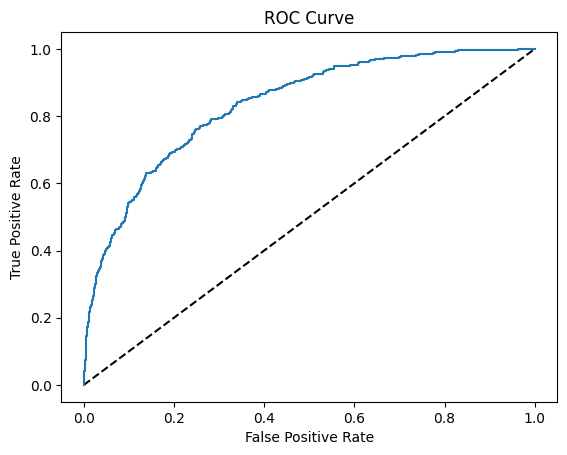

In [216]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(train[TARGET],oof_lgb)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr,label='LogisticRegression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

7. 提出

In [217]:
# submit_sample.csvを読み込みます。
submit = pd.read_csv("/content/sample_submit.csv", header=None)
submit.head(1)

,0,1
0,3489,0.119451


In [218]:
# テストデータを用いて予測します。
predict0 = models[0].predict(test)
predict1 = models[1].predict(test)
predict2 = models[2].predict(test)
predict = (predict0 + predict1 + predict2) / 3
submit[1] = predict

In [219]:
# 提出
submit.to_csv("submission.csv", index=False, header=None)